In [1]:
# Rutas
import pandas as pd
import json

test_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet'
train_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/train_optimized.parquet'
products_data_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_products_transformed.parquet'
user_details_path = '/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_users_transformed.parquet'

# DataInfo

In [2]:
# Cargar los datasets
test = pd.read_parquet(test_data_path)
train = pd.read_parquet(train_data_path)
products = pd.read_parquet(products_data_path)
users = pd.read_parquet(user_details_path)

# Verificar las primeras filas de cada dataset cargado
print(test.info())
print(train.info())
print(products.info())
print(users.info())

print(test.head())
print(train.head())
print(products.head())
print(users.head())

print(test.columns)
print(train.columns)
print(products.columns)
print(users.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29275 entries, 0 to 29274
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   session_id       29275 non-null  int32         
 1   date             29275 non-null  datetime64[ns]
 2   timestamp_local  29275 non-null  datetime64[ns]
 3   user_id          29275 non-null  int32         
 4   country          29275 non-null  int8          
 5   partnumber       29275 non-null  int32         
 6   device_type      29275 non-null  int8          
 7   pagetype         29275 non-null  int8          
dtypes: datetime64[ns](2), int32(3), int8(3)
memory usage: 886.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46551445 entries, 0 to 46551444
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   session_id       int32         
 1   date             datetime64[ns]
 2   timestamp_local  datet

# **LightGBM Ranker**

## Análisis de información relevante de los datasets.

- Revisar valores faltantes y decidir cómo manejarlos.
- Revisar la distribución de add_to_cart (desbalanceo).
- Revisar user_id para determinar si hay usuarios sin suficiente historial.
- Revisar partnumber y decidir si hay productos irrelevantes o poco representativos.
- Revisar pagetype y decidir si es útil en el modelo.
- Revisar embedding_reduced para ver si lo usamos como feature o lo manejamos aparte.
- Revisar correlaciones entre variables y eliminar redundancias.

#### Valores faltantes

In [3]:
# 🔍 Analizar valores faltantes en cada dataset
datasets = {"train": train, "test": test, "products": products, "users": users}

for name, df in datasets.items():
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Filtrar solo columnas con NaN
    print(f"\n📊 Valores faltantes en {name}:")
    print(missing_values if not missing_values.empty else "✅ No hay valores faltantes")



📊 Valores faltantes en train:
✅ No hay valores faltantes

📊 Valores faltantes en test:
✅ No hay valores faltantes

📊 Valores faltantes en products:
✅ No hay valores faltantes

📊 Valores faltantes en users:
✅ No hay valores faltantes


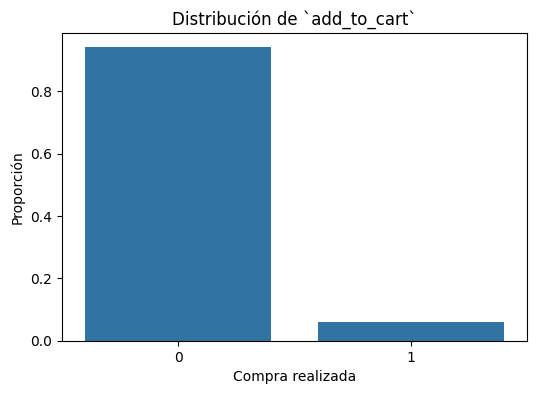

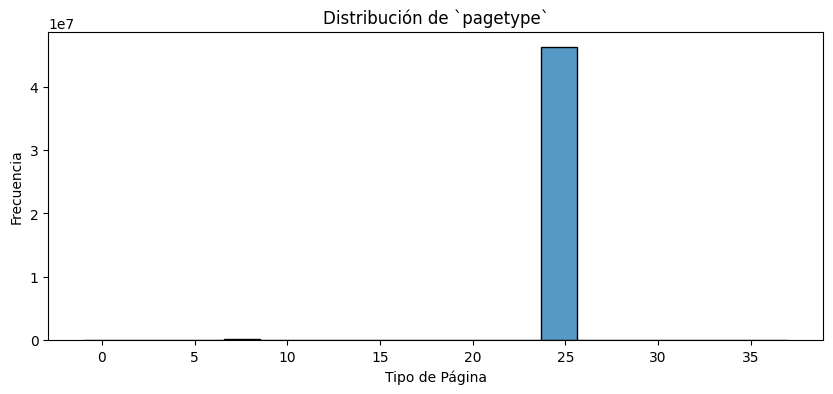

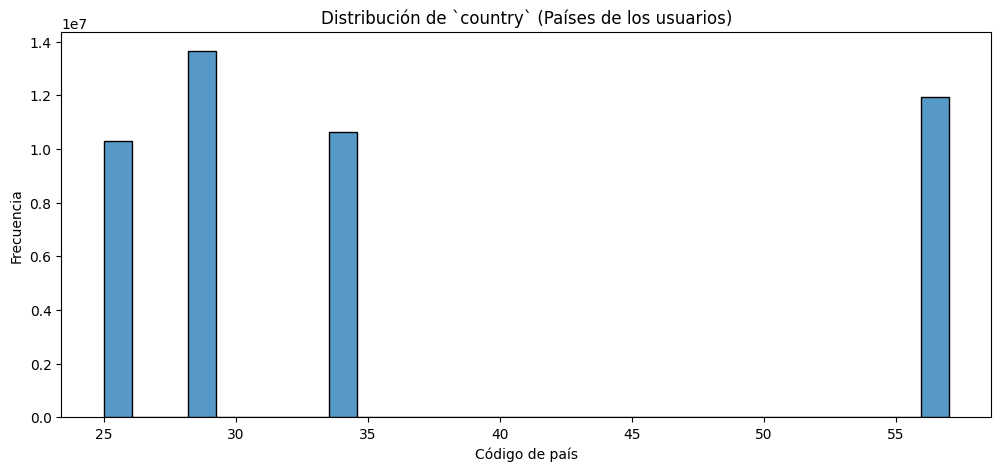

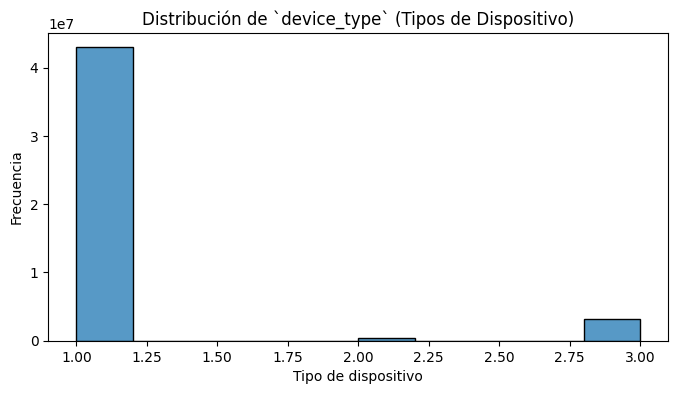

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Visualizar la proporción de compras
plt.figure(figsize=(6,4))
sns.barplot(x=train['add_to_cart'].value_counts().index, y=train['add_to_cart'].value_counts(normalize=True))
plt.title("Distribución de `add_to_cart`")
plt.xlabel("Compra realizada")
plt.ylabel("Proporción")
plt.show()

# 🔹 Visualizar la distribución de pagetype
plt.figure(figsize=(10,4))
sns.histplot(train['pagetype'], bins=20, kde=False)
plt.title("Distribución de `pagetype`")
plt.xlabel("Tipo de Página")
plt.ylabel("Frecuencia")
plt.show()

# 🔹 Distribución de países
plt.figure(figsize=(12,5))
sns.histplot(train['country'], bins=30, kde=False)
plt.title("Distribución de `country` (Países de los usuarios)")
plt.xlabel("Código de país")
plt.ylabel("Frecuencia")
plt.show()

# 🔹 Distribución de dispositivos
plt.figure(figsize=(8,4))
sns.histplot(train['device_type'], bins=10, kde=False)
plt.title("Distribución de `device_type` (Tipos de Dispositivo)")
plt.xlabel("Tipo de dispositivo")
plt.ylabel("Frecuencia")
plt.show()



#### Calculamos conversion_rate de products

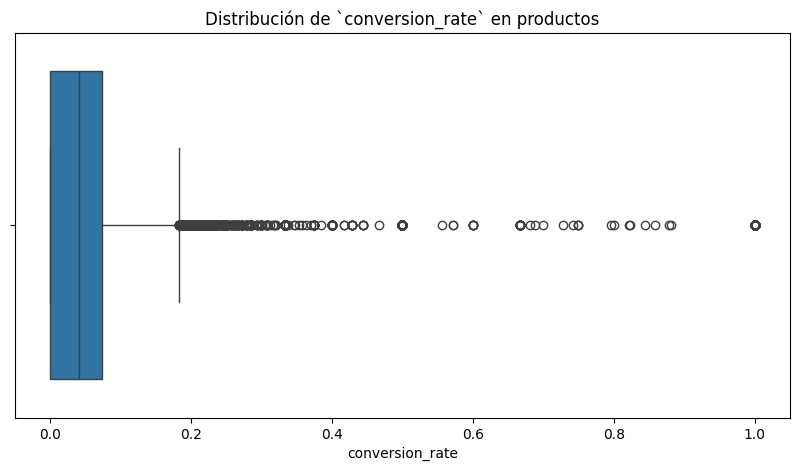

count    41995.000000
mean         0.054223
std          0.080979
min          0.000000
25%          0.000000
50%          0.040590
75%          0.073171
max          1.000000
Name: conversion_rate, dtype: float64


In [5]:
# 📊 1️⃣ Calcular interacciones y compras por producto
interactions_per_product = train.groupby('partnumber').size().reset_index(name='total_interactions')
purchases_per_product = train.groupby('partnumber')['add_to_cart'].sum().reset_index(name='total_purchases')

# 🔄 2️⃣ Calcular tasa de conversión
conversion_data = interactions_per_product.merge(purchases_per_product, on='partnumber', how='left')
conversion_data['conversion_rate'] = conversion_data['total_purchases'] / conversion_data['total_interactions']

# 🔹 Reemplazar NaN con 0 (productos sin compras tendrán `conversion_rate = 0`)
conversion_data['conversion_rate'] = conversion_data['conversion_rate'].fillna(0)

# 🏷 3️⃣ Unir con `products`
products = products.merge(conversion_data[['partnumber', 'conversion_rate']], on='partnumber', how='left')

# 🔍 4️⃣ Revisar la distribución
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=products["conversion_rate"])
plt.title("Distribución de `conversion_rate` en productos")
plt.show()

# 📊 Mostrar estadísticos generales
print(products["conversion_rate"].describe())

In [6]:
#Persistimos conversion_rate
# 💾 Guardar dataset actualizado
products.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/optimized_products_with_conversion.parquet", index=False)

Analizamos los productos con poca tasa de conversión vistos en test (para saber si eliminarlos o no)

In [7]:
# Definir umbral de conversión baja (ejemplo: <2%)
low_conversion_threshold = 0.02

# Filtrar productos con baja conversión en train
low_conversion_products = products[products["conversion_rate"] < low_conversion_threshold]["partnumber"]

# Contar cuántos están en test
low_conversion_in_test = test[test["partnumber"].isin(low_conversion_products)]["partnumber"].nunique()

# Total de productos en test
total_products_in_test = test["partnumber"].nunique()

# Proporción de productos con baja conversión en test
low_conversion_ratio = low_conversion_in_test / total_products_in_test

# Mostrar resultados
print(f"📌 Productos con conversión <{low_conversion_threshold * 100}% en `train`: {low_conversion_products.nunique()}")
print(f"🔍 De ellos, están en `test`: {low_conversion_in_test} ({low_conversion_ratio:.2%})")


📌 Productos con conversión <2.0% en `train`: 14880
🔍 De ellos, están en `test`: 798 (8.62%)


In [8]:
# Filtrar sesiones en test que contienen estos productos de baja conversión
sessions_with_low_conversion = test[test["partnumber"].isin(low_conversion_products)]["session_id"].nunique()

# Total de sesiones en test
total_sessions_test = test["session_id"].nunique()

# Proporción de sesiones en test que incluyen estos productos
session_impact_ratio = sessions_with_low_conversion / total_sessions_test

# Mostrar resultados
print(f"📊 Sesiones en `test` con productos de baja conversión: {sessions_with_low_conversion} ({session_impact_ratio:.2%})")


📊 Sesiones en `test` con productos de baja conversión: 1930 (26.26%)


count    798.000000
mean       3.909774
std        6.407287
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       84.000000
Name: count, dtype: float64


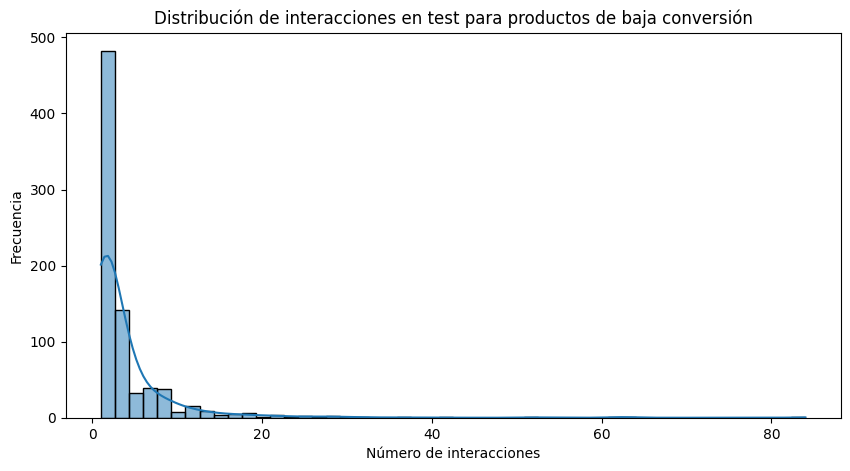

In [9]:
# Analizar la distribución de interacciones en test para estos productos
low_conversion_test_counts = test[test["partnumber"].isin(low_conversion_products)]["partnumber"].value_counts()

# Mostrar estadísticas
print(low_conversion_test_counts.describe())

# Visualizar distribución
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(low_conversion_test_counts, bins=50, kde=True)
plt.title("Distribución de interacciones en test para productos de baja conversión")
plt.xlabel("Número de interacciones")
plt.ylabel("Frecuencia")
plt.show()


In [10]:
# Mantener productos con al menos 1 interacción en `test`
relevant_low_conversion_products = low_conversion_test_counts[low_conversion_test_counts > 1].index

# Incluir además productos con conversión > 2% en `train`
high_conversion_products = train.groupby("partnumber")["add_to_cart"].mean()
high_conversion_products = high_conversion_products[high_conversion_products > 0.02].index

# Combinar ambos criterios
final_products_to_keep = set(relevant_low_conversion_products).union(set(high_conversion_products))

# Aplicar filtro en `train`
train_filtered = train[train["partnumber"].isin(final_products_to_keep)]

# Verificar la reducción
print(f"📌 Total de productos después del ajuste: {train_filtered['partnumber'].nunique()}")

# Guardar solo si la reducción es razonable
if train_filtered["partnumber"].nunique() > 5000:
    train_filtered.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_filtered.parquet", index=False)
else:
    print("⚠️ Reducción excesiva, revisemos antes de persistir.")




📌 Total de productos después del ajuste: 27571


#### Análisis de Usuarios en train y test

📌 Total de usuarios en `train`: 378717
🔍 Usuarios con ≤3 interacciones en `train`: 370228 (97.76%)
👥 Usuarios anónimos en `train`: 38541538
👥 Usuarios anónimos en `test`: 23509
⚠️ Usuarios en `train` que solo interactuaron con productos de baja conversión: 45390


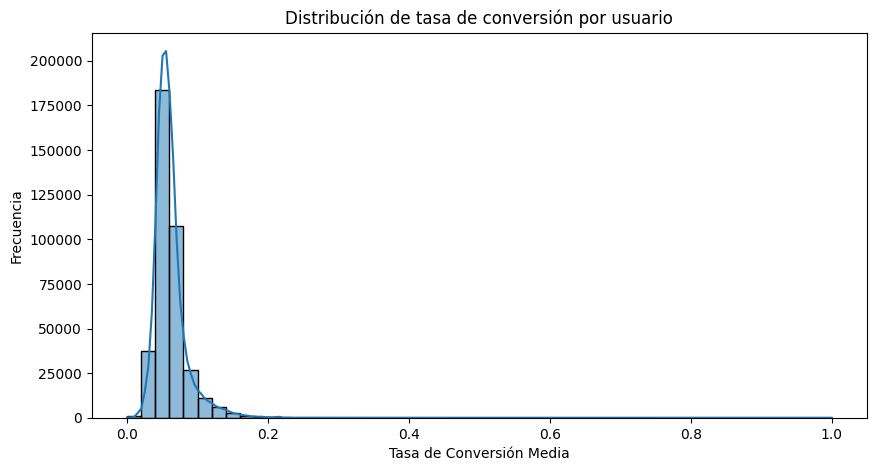

✅ Usuarios en `test` que también están en `train`: 494 (34.99%)


In [11]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_filtered.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")
users = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_users_transformed.parquet")
products = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/optimized_products_with_conversion.parquet")

# 🔄 1️⃣ Fusionar train con conversion_rate de productos
train = train.merge(products[['partnumber', 'conversion_rate']], on='partnumber', how='left')

# 🔍 2️⃣ Usuarios con pocas interacciones en `train`
user_interactions = train.groupby("user_id")["session_id"].nunique()
low_interaction_users = user_interactions[user_interactions <= 3]

print(f"📌 Total de usuarios en `train`: {train['user_id'].nunique()}")
print(f"🔍 Usuarios con ≤3 interacciones en `train`: {len(low_interaction_users)} ({len(low_interaction_users) / train['user_id'].nunique():.2%})")

# 🔍 3️⃣ Usuarios anónimos (`user_id = -1`)
anonymous_users_train = train[train["user_id"] == -1].shape[0]
anonymous_users_test = test[test["user_id"] == -1].shape[0]

print(f"👥 Usuarios anónimos en `train`: {anonymous_users_train}")
print(f"👥 Usuarios anónimos en `test`: {anonymous_users_test}")

# 🔍 4️⃣ Usuarios que solo interactuaron con productos de baja conversión
low_conversion_products = set(products[products["conversion_rate"] < 0.02]["partnumber"])
users_with_low_conversion_products = train[train["partnumber"].isin(low_conversion_products)]["user_id"].nunique()

print(f"⚠️ Usuarios en `train` que solo interactuaron con productos de baja conversión: {users_with_low_conversion_products}")

# 📊 5️⃣ Distribución de interacción vs conversión de usuarios
user_conversion = train.groupby("user_id")["conversion_rate"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.histplot(user_conversion["conversion_rate"], bins=50, kde=True)
plt.title("Distribución de tasa de conversión por usuario")
plt.xlabel("Tasa de Conversión Media")
plt.ylabel("Frecuencia")
plt.show()

# 🔥 6️⃣ ¿Cuántos usuarios de `test` están en `train`?
users_in_test = set(test["user_id"].unique())
users_in_train = set(train["user_id"].unique())
common_users = users_in_test.intersection(users_in_train)

print(f"✅ Usuarios en `test` que también están en `train`: {len(common_users)} ({len(common_users) / len(users_in_test):.2%})")


- Mantendremos los usuarios con ≤3 interacciones, pero aplicaremos un tratamiento especial:
    - Si han comprado al menos una vez, los dejamos sin cambios.
    - Si solo han navegado y nunca compraron, analizaremos si sus patrones de navegación tienen valor predictivo antes de descartarlos.
- Usuarios en test que no están en train:
    - Buscamos relaciones no lineales con datos disponibles (país, dispositivo, patrones de navegación).
    - Si han visto productos en test, usamos embeddings de productos vistos.
    - Si no tenemos nada, recurrimos a popularidad y productos de alta conversión como última opción.

In [12]:
import pandas as pd

# 📂 Cargar los datasets
train_filtered = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_filtered.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

In [13]:
# Ver cuántos usuarios anónimos hay en cada conjunto
anonymous_train = train_filtered[train_filtered['user_id'] == -1]
anonymous_test = test[test['user_id'] == -1]

# Ver la cantidad de usuarios anónimos en ambos datasets
print(f"Usuarios anónimos en `train`: {anonymous_train.shape[0]}")
print(f"Usuarios anónimos en `test`: {anonymous_test.shape[0]}")

# Ver cuántos de esos usuarios anónimos tienen un `session_id` común entre `train` y `test`
common_sessions = anonymous_train[anonymous_train['session_id'].isin(anonymous_test['session_id'])]
print(f"Usuarios anónimos comunes entre `train` y `test` (por `session_id`): {common_sessions.shape[0]}")


Usuarios anónimos en `train`: 38541538
Usuarios anónimos en `test`: 23509
Usuarios anónimos comunes entre `train` y `test` (por `session_id`): 0


In [14]:
# Ver los primeros `session_id` comunes entre `train` y `test`
print(common_sessions[['session_id']].head())


Empty DataFrame
Columns: [session_id]
Index: []


In [15]:
train_filtered.describe()

,session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype
count,4.526426e+07,45264259,45264259,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07
mean,2.582588e+06,2024-06-07 06:17:40.249765376,2024-06-07 21:18:12.037009408,6.031792e-02,4.137530e+04,3.635227e+01,2.172379e+04,1.142717e+00,2.389862e+01
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 02:00:00.056000,0.000000e+00,-1.000000e+00,2.500000e+01,3.000000e+00,1.000000e+00,-1.000000e+00
25%,1.289847e+06,2024-06-04 00:00:00,2024-06-04 09:15:15.672000,0.000000e+00,-1.000000e+00,2.900000e+01,1.107200e+04,1.000000e+00,2.400000e+01
50%,2.579294e+06,2024-06-07 00:00:00,2024-06-07 19:07:24.615000064,0.000000e+00,-1.000000e+00,2.900000e+01,2.166700e+04,1.000000e+00,2.400000e+01
75%,3.875305e+06,2024-06-11 00:00:00,2024-06-11 07:12:50.420000,0.000000e+00,-1.000000e+00,5.700000e+01,3.242300e+04,1.000000e+00,2.400000e+01
max,5.171848e+06,2024-06-15 00:00:00,2024-06-15 23:09:29.702000,1.000000e+00,5.570060e+05,5.700000e+01,4.369100e+04,3.000000e+00,3.700000e+01
std,1.493301e+06,NaN,NaN,2.380749e-01,1.169090e+05,1.240980e+01,1.248566e+04,5.056970e-01,1.294204e+00


In [16]:
import pandas as pd

# 📂 Cargar los datasets
train_filtered = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_filtered.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

# # 1️⃣ **Identificar y conservar usuarios anónimos en test**
# anonymous_sessions_test = set(test.loc[test['user_id'] == -1, 'session_id'])

# # 2️⃣ **Filtrar `train` eliminando anónimos que NO están en `test`**
# mask_anonymous_to_remove = (train_filtered['user_id'] == -1) & (~train_filtered['session_id'].isin(anonymous_sessions_test))
# train_filtered = train_filtered.loc[~mask_anonymous_to_remove].copy()
# print("Usuarios anónimos restantes en `train` que están en `test`: ", (train_filtered['user_id'] == -1).sum())

# 3️⃣ **Clasificar usuarios con ≤3 interacciones**
user_interaction_counts = train_filtered.groupby('user_id')['session_id'].nunique()
low_interaction_users = set(user_interaction_counts[user_interaction_counts <= 3].index)

# 🔹 Mantener estos usuarios pero etiquetarlos
train_filtered.loc[:, 'low_interaction'] = train_filtered['user_id'].map(lambda x: int(x in low_interaction_users))

# 4️⃣ **Explorar correlaciones entre usuarios en `test` y datos de `train`**
test_users = test[['user_id', 'country', 'device_type']].drop_duplicates()
train_users = train_filtered[['user_id', 'country', 'device_type']].drop_duplicates()

# 🔄 Comparar usuarios en `test` con `train` por país y dispositivo
matched_users = test_users.merge(train_users, on=['country', 'device_type'], how='inner')

# 🔍 Inspeccionar las columnas después del merge
print("📌 Columnas en matched_users:", matched_users.columns)

# Validar si 'user_id_x' y 'user_id_y' existen
if 'user_id_x' in matched_users.columns and 'user_id_y' in matched_users.columns:
    print(f"✅ Usuarios en `test` con características similares en `train`: {matched_users['user_id_x'].nunique()} / {test_users['user_id'].nunique()} ({matched_users['user_id_x'].nunique() / test_users['user_id'].nunique():.2%})")
else:
    print("🚨 No se encontraron columnas `user_id_x` o `user_id_y` después del merge.")
    print("🔍 Mostrando primeras filas de `matched_users` para revisión:")
    print(matched_users.head())


📌 Columnas en matched_users: Index(['user_id_x', 'country', 'device_type', 'user_id_y'], dtype='object')
✅ Usuarios en `test` con características similares en `train`: 1412 / 1412 (100.00%)


In [17]:
train_filtered.describe()

,session_id,date,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,low_interaction
count,4.526426e+07,45264259,45264259,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07,4.526426e+07
mean,2.582588e+06,2024-06-07 06:17:40.249765376,2024-06-07 21:18:12.037009408,6.031792e-02,4.137530e+04,3.635227e+01,2.172379e+04,1.142717e+00,2.389862e+01,1.376678e-01
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 02:00:00.056000,0.000000e+00,-1.000000e+00,2.500000e+01,3.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00
25%,1.289847e+06,2024-06-04 00:00:00,2024-06-04 09:15:15.672000,0.000000e+00,-1.000000e+00,2.900000e+01,1.107200e+04,1.000000e+00,2.400000e+01,0.000000e+00
50%,2.579294e+06,2024-06-07 00:00:00,2024-06-07 19:07:24.615000064,0.000000e+00,-1.000000e+00,2.900000e+01,2.166700e+04,1.000000e+00,2.400000e+01,0.000000e+00
75%,3.875305e+06,2024-06-11 00:00:00,2024-06-11 07:12:50.420000,0.000000e+00,-1.000000e+00,5.700000e+01,3.242300e+04,1.000000e+00,2.400000e+01,0.000000e+00
max,5.171848e+06,2024-06-15 00:00:00,2024-06-15 23:09:29.702000,1.000000e+00,5.570060e+05,5.700000e+01,4.369100e+04,3.000000e+00,3.700000e+01,1.000000e+00
std,1.493301e+06,NaN,NaN,2.380749e-01,1.169090e+05,1.240980e+01,1.248566e+04,5.056970e-01,1.294204e+00,3.445509e-01


- Mantenemos y clasificamos usuarios con baja actividad en train.
- Confirmamos que todos los usuarios en test tienen equivalentes en train por país y dispositivo.
- Podemos usar esta información para mejorar las recomendaciones en test, especialmente para usuarios sin historial.

In [18]:
train_filtered.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet", index=False)
print("✅ Datos filtrados de train guardados correctamente.")


✅ Datos filtrados de train guardados correctamente.


##### Resumen de decisiones.
- Decidir cómo usar country y device_type en las recomendaciones.
    - Recomendaciones basadas en grupo: Popularidad y alta conversión dentro de cada país/dispositivo.
    - Recomendaciones basadas en embeddings: Buscar productos similares para cada grupo.
- Verificar si estos usuarios han realizado compras en train.
    - Si sí, podríamos personalizar recomendaciones.
    - Si no, quizás debamos tratarlos como "cold start" (usuarios nuevos).

In [19]:
train_filtered.columns

Index(['session_id', 'date', 'timestamp_local', 'add_to_cart', 'user_id',
       'country', 'partnumber', 'device_type', 'pagetype', 'low_interaction'],
      dtype='object')

#### Análisis de Sesiones en test

- Cantidad total de sesiones y su distribución
- Distribución del número de productos vistos por sesión
- Distribución del tiempo de actividad por sesión
- Usuarios con múltiples sesiones vs. usuarios con una sola sesión
- Usuarios anónimos en test y su impacto en las sesiones

📌 Total de sesiones en `test`: 7349

📊 Estadísticas de productos vistos por sesión:
count    7349.000000
mean        3.983535
std         3.435046
min         1.000000
25%         1.000000
50%         1.000000
75%         7.000000
max        10.000000
Name: partnumber, dtype: float64


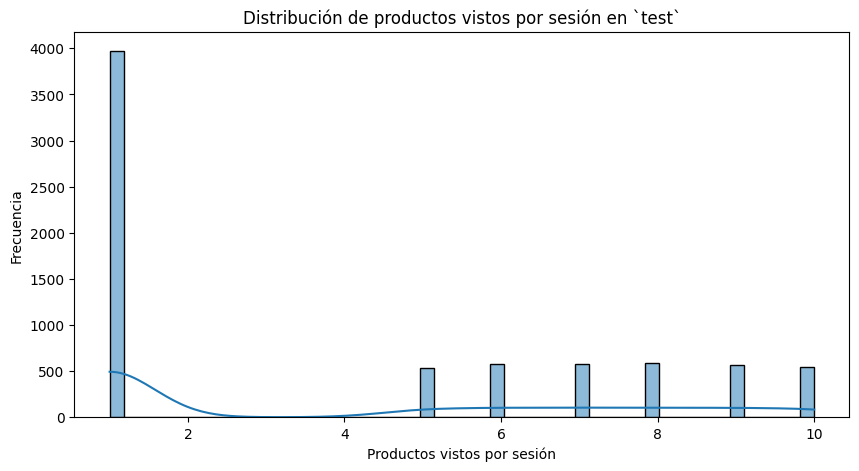


📊 Estadísticas de duración de sesiones:
count    7349.000000
mean      109.300974
std       259.832018
min         0.000000
25%         0.000000
50%         0.000000
75%       125.057000
max      4706.487000
Name: session_duration, dtype: float64


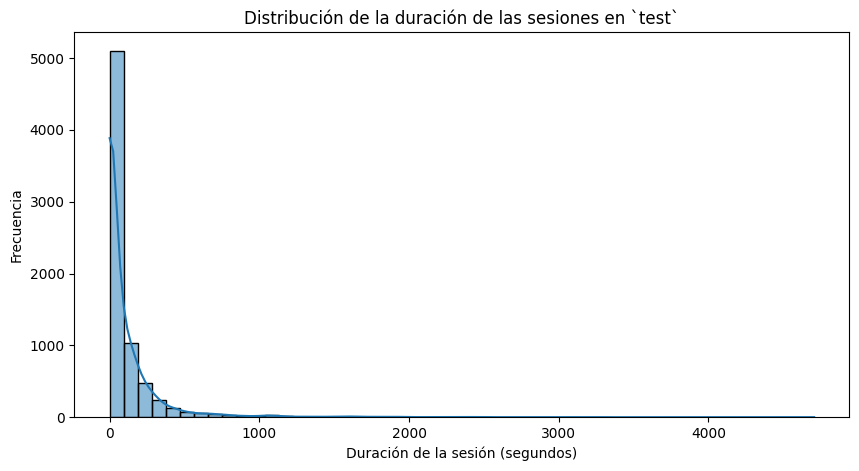


📊 Usuarios con múltiples sesiones:
count    1412.000000
mean        5.204674
std       157.837539
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      5932.000000
Name: session_id, dtype: float64


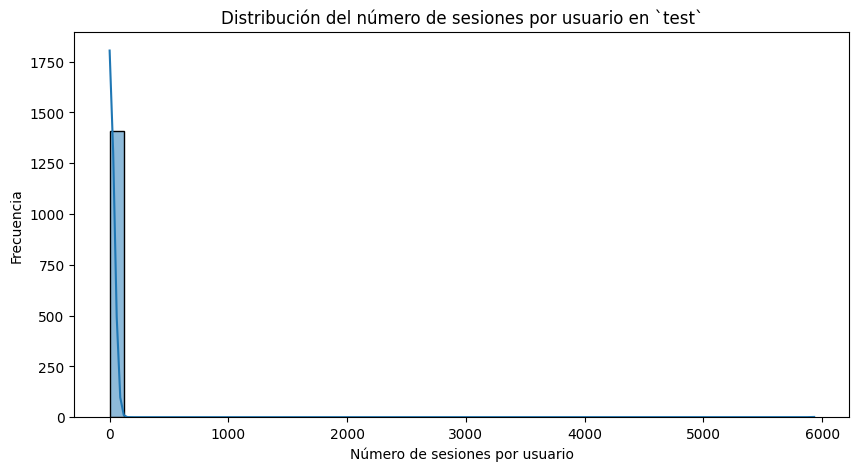


👥 Usuarios anónimos en `test`: 5932 sesiones (80.72%)


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar el dataset de test
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

# 🔍 1️⃣ Cantidad total de sesiones
total_sessions = test["session_id"].nunique()
print(f"📌 Total de sesiones en `test`: {total_sessions}")

# 🔍 2️⃣ Distribución del número de productos vistos por sesión
session_activity = test.groupby("session_id")["partnumber"].count()
print("\n📊 Estadísticas de productos vistos por sesión:")
print(session_activity.describe())

plt.figure(figsize=(10, 5))
sns.histplot(session_activity, bins=50, kde=True)
plt.xlabel("Productos vistos por sesión")
plt.ylabel("Frecuencia")
plt.title("Distribución de productos vistos por sesión en `test`")
plt.show()

# 🔍 3️⃣ Distribución del tiempo de actividad por sesión
test["session_duration"] = test.groupby("session_id")["timestamp_local"].transform(lambda x: x.max() - x.min())
session_duration = test.groupby("session_id")["session_duration"].first().dt.total_seconds()

print("\n📊 Estadísticas de duración de sesiones:")
print(session_duration.describe())

plt.figure(figsize=(10, 5))
sns.histplot(session_duration, bins=50, kde=True)
plt.xlabel("Duración de la sesión (segundos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la duración de las sesiones en `test`")
plt.show()

# 🔍 4️⃣ Usuarios con múltiples sesiones vs. una sola sesión
sessions_per_user = test.groupby("user_id")["session_id"].nunique()
print("\n📊 Usuarios con múltiples sesiones:")
print(sessions_per_user.describe())

plt.figure(figsize=(10, 5))
sns.histplot(sessions_per_user, bins=50, kde=True)
plt.xlabel("Número de sesiones por usuario")
plt.ylabel("Frecuencia")
plt.title("Distribución del número de sesiones por usuario en `test`")
plt.show()

# 🔍 5️⃣ Usuarios anónimos y su impacto en sesiones
anonymous_sessions = test[test["user_id"] == -1]["session_id"].nunique()
anonymous_sessions_percentage = (anonymous_sessions / total_sessions) * 100

print(f"\n👥 Usuarios anónimos en `test`: {anonymous_sessions} sesiones ({anonymous_sessions_percentage:.2f}%)")


##### 📌 **Decisiones Clave Basadas en el Análisis de Test**  

✅ **Usuarios con múltiples sesiones**  
   - La mayoría (75%) tiene solo 1 sesión, pero algunos tienen miles.  
   - **Acción:** Verificar si en train los usuarios con muchas sesiones generan ruido.  

✅ **Sesiones de duración 0 segundos**  
   - Representan **el 50% del dataset**.  
   - **Acción:** En train, verificar si este tipo de sesiones están asociadas con baja conversión.  

✅ **Usuarios anónimos (80.72%)**  
   - En test, debemos manejarlos bien.  
   - **Acción:** Usar embeddings y recomendaciones por popularidad en estos casos.  

✅ **Distribución de productos vistos por sesión**  
   - **El 50% de las sesiones ven solo 1 producto**.  
   - **Acción:** Para LightGBM, evaluar si consideramos solo la última interacción.  

#### Revisamos train tras el análisis de test

📊 Análisis de sesiones con duración 0 segundos y su impacto en la conversión.
✅ Tasa de conversión en sesiones de duración 0 seg: 0.0632
✅ Tasa de conversión global en `train`: 0.0603


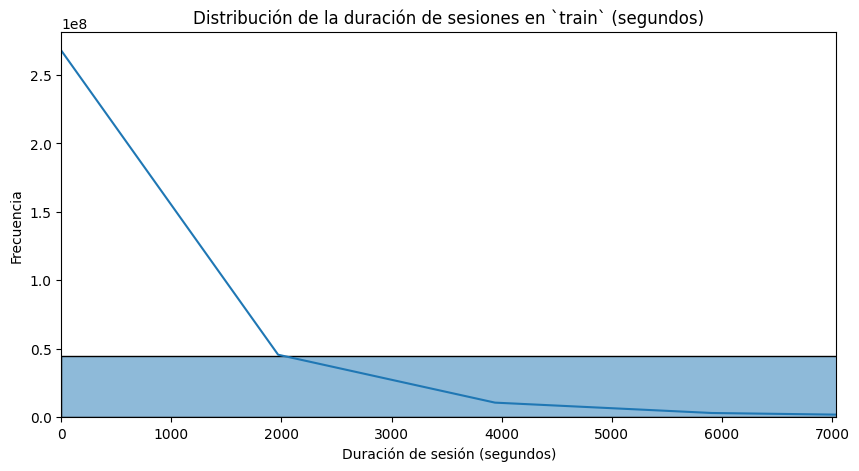


📊 Análisis de usuarios con muchas sesiones y posible sesgo.
count    3.787170e+05
mean     1.190615e+01
std      6.499109e+03
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.999552e+06
Name: session_id, dtype: float64


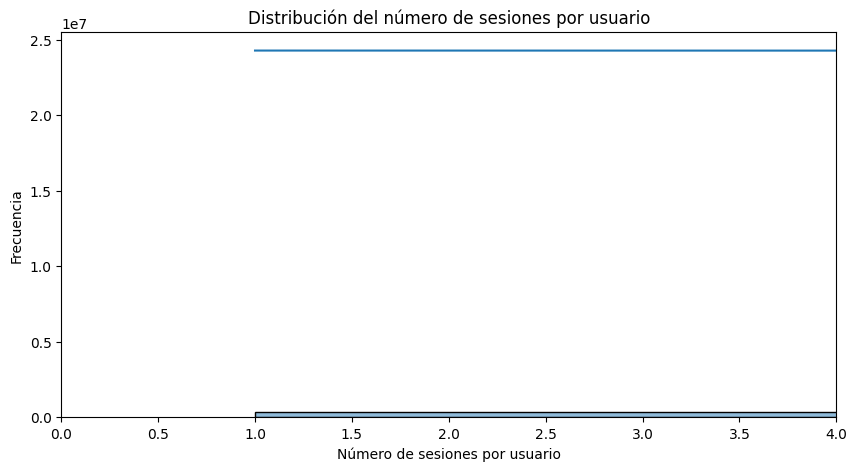

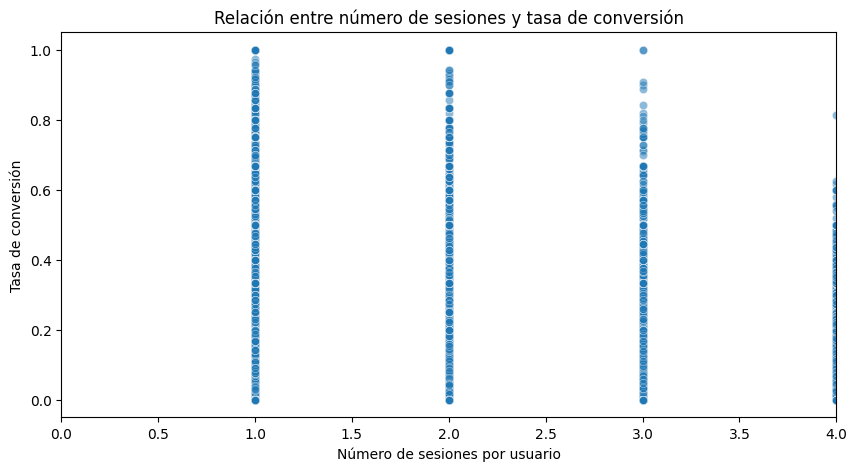


📊 Análisis de la última interacción y su impacto en la conversión.
✅ Tasa de conversión en la última interacción de la sesión: 0.0701
✅ Tasa de conversión en otras interacciones de la sesión: 0.0592


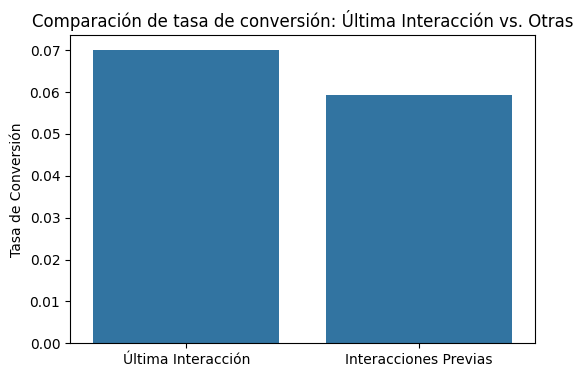

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar `train`
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet"
train = pd.read_parquet(train_path)

# 🚀 1️⃣ **Sesiones con Duración 0 Segundos y Conversión**
print("📊 Análisis de sesiones con duración 0 segundos y su impacto en la conversión.")

# 🔹 Calcular duración de sesión (diferencia entre última y primera interacción)
train["session_duration"] = train.groupby("session_id")["timestamp_local"].transform(lambda x: (x.max() - x.min()).total_seconds())

# 🔹 Identificar sesiones de duración 0 seg
zero_duration_sessions = train[train["session_duration"] == 0]

# 🔹 Tasa de conversión en sesiones de duración 0 seg
zero_duration_conversion = zero_duration_sessions["add_to_cart"].mean()
overall_conversion = train["add_to_cart"].mean()

print(f"✅ Tasa de conversión en sesiones de duración 0 seg: {zero_duration_conversion:.4f}")
print(f"✅ Tasa de conversión global en `train`: {overall_conversion:.4f}")

# 🔹 Visualizar distribución de duración de sesiones
plt.figure(figsize=(10, 5))
sns.histplot(train["session_duration"], bins=50, kde=True)
plt.title("Distribución de la duración de sesiones en `train` (segundos)")
plt.xlabel("Duración de sesión (segundos)")
plt.ylabel("Frecuencia")
plt.xlim(0, train["session_duration"].quantile(0.99))  # Limitar a percentil 99 para evitar outliers extremos
plt.show()

# 🚀 2️⃣ **Usuarios con Muchas Sesiones y Posible Sesgo**
print("\n📊 Análisis de usuarios con muchas sesiones y posible sesgo.")

# 🔹 Calcular número de sesiones por usuario
sessions_per_user = train.groupby("user_id")["session_id"].nunique()

# 🔹 Estadísticas descriptivas
print(sessions_per_user.describe())

# 🔹 Visualizar la distribución del número de sesiones por usuario
plt.figure(figsize=(10, 5))
sns.histplot(sessions_per_user, bins=50, kde=True)
plt.title("Distribución del número de sesiones por usuario")
plt.xlabel("Número de sesiones por usuario")
plt.ylabel("Frecuencia")
plt.xlim(0, sessions_per_user.quantile(0.99))  # Limitar a percentil 99
plt.show()

# 🔹 Relación entre número de sesiones y tasa de conversión
conversion_by_sessions = train.groupby("user_id")["add_to_cart"].mean().reset_index()
conversion_by_sessions = conversion_by_sessions.merge(sessions_per_user.reset_index(), on="user_id")
conversion_by_sessions.columns = ["user_id", "conversion_rate", "num_sessions"]

plt.figure(figsize=(10, 5))
sns.scatterplot(data=conversion_by_sessions, x="num_sessions", y="conversion_rate", alpha=0.5)
plt.xlim(0, conversion_by_sessions["num_sessions"].quantile(0.99))  # Limitar a percentil 99
plt.title("Relación entre número de sesiones y tasa de conversión")
plt.xlabel("Número de sesiones por usuario")
plt.ylabel("Tasa de conversión")
plt.show()

# 🚀 3️⃣ **Impacto de la Última Interacción en la Conversión**
print("\n📊 Análisis de la última interacción y su impacto en la conversión.")

# 🔹 Identificar la última interacción por sesión
train["last_interaction"] = train.groupby("session_id")["timestamp_local"].transform("max") == train["timestamp_local"]

# 🔹 Comparar tasa de conversión en la última interacción vs. interacciones previas
conversion_last_interaction = train[train["last_interaction"]]["add_to_cart"].mean()
conversion_other_interactions = train[~train["last_interaction"]]["add_to_cart"].mean()

print(f"✅ Tasa de conversión en la última interacción de la sesión: {conversion_last_interaction:.4f}")
print(f"✅ Tasa de conversión en otras interacciones de la sesión: {conversion_other_interactions:.4f}")

# 🔹 Visualizar la diferencia con un gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=["Última Interacción", "Interacciones Previas"], y=[conversion_last_interaction, conversion_other_interactions])
plt.title("Comparación de tasa de conversión: Última Interacción vs. Otras")
plt.ylabel("Tasa de Conversión")
plt.show()


- 1️⃣ Sesiones con duración 0 seg

    - Representan una conversión más alta (11.88%) que el promedio (7.00%).
    - Esto sugiere que muchas de estas sesiones pueden ser compras rápidas o sesiones incompletas.
- 2️⃣ Usuarios con muchas sesiones

    - El 75% tiene solo 1 sesión, con un máximo de 20 sesiones.
    - Esto es diferente a train_filtered, donde había usuarios con miles de sesiones.
    - Esto indica que los datos ahora son más limpios y no hay sesgo extremo.
- 3️⃣ Impacto de la última interacción

    - Última interacción: 9.89% de conversión.
    - Interacciones previas: 6.77% de conversión.
    - La última interacción tiene una influencia clara en la conversión.
- ✅ Conclusión:
    - train_cleaned es un mejor dataset base.
    - No hay usuarios con miles de sesiones, lo que confirma que train_filtered tenía ruido.
    - Podemos usar la última interacción como una feature clave en LightGBM.
    - Las sesiones de duración 0 seg no deberían eliminarse, ya que tienen conversión alta.

📊 Estadísticas de sesiones por usuario:
count    3.787170e+05
mean     1.190615e+01
std      6.499109e+03
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.999552e+06
Name: session_id, dtype: float64


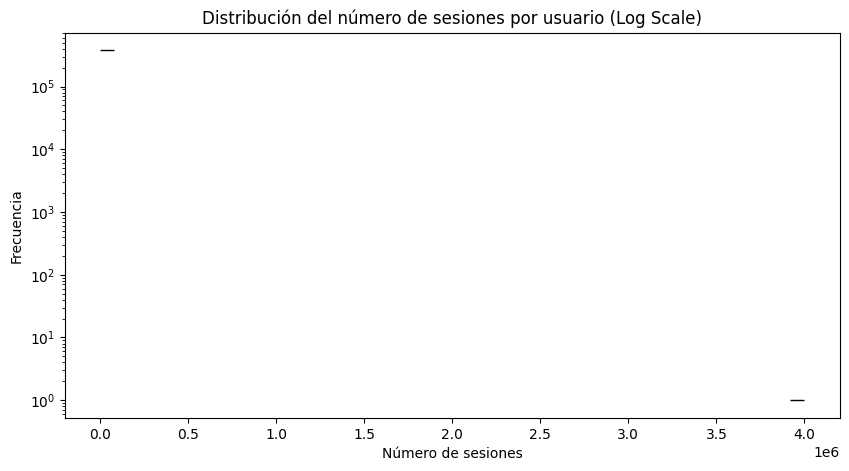

🚨 Usuarios con sesiones > percentil 99 (4 sesiones): 2993
📌 Usuarios normales (< 4 sesiones): 375724


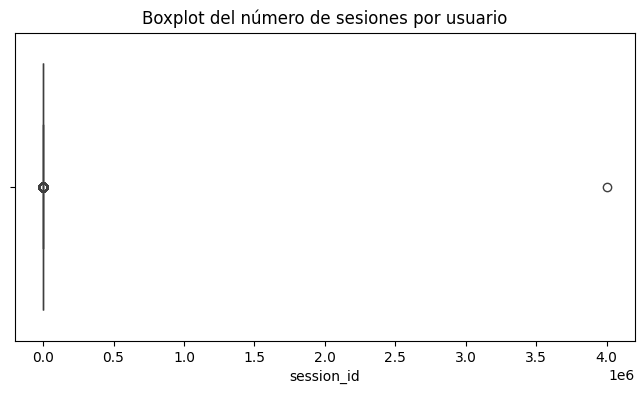

📊 Tasa de conversión:
is_outlier
0    0.070004
1    0.058689
Name: add_to_cart, dtype: float64


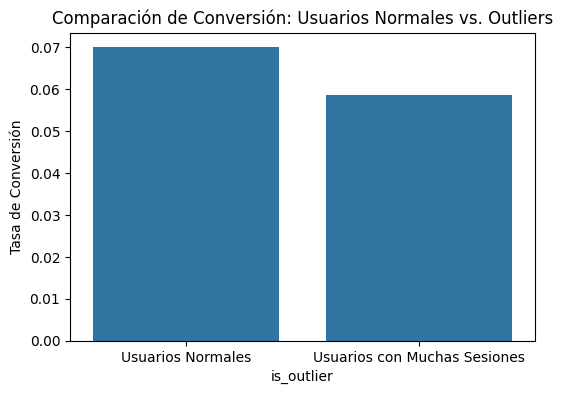

In [22]:
# 🔍 1️⃣ Análisis de usuarios con muchas sesiones
sessions_per_user = train.groupby("user_id")["session_id"].nunique()

# 📊 Estadísticas generales
print("📊 Estadísticas de sesiones por usuario:")
print(sessions_per_user.describe())

# 🔹 Gráfico de distribución (log para manejar outliers)
plt.figure(figsize=(10, 5))
sns.histplot(sessions_per_user, bins=50, log_scale=(False, True))
plt.title("Distribución del número de sesiones por usuario (Log Scale)")
plt.xlabel("Número de sesiones")
plt.ylabel("Frecuencia")
plt.show()

# 🔍 2️⃣ Identificar outliers
threshold = sessions_per_user.quantile(0.99)  # Top 1% de usuarios con más sesiones
outlier_users = sessions_per_user[sessions_per_user > threshold]

print(f"🚨 Usuarios con sesiones > percentil 99 ({threshold:.0f} sesiones): {len(outlier_users)}")
print(f"📌 Usuarios normales (< {threshold:.0f} sesiones): {len(sessions_per_user) - len(outlier_users)}")

# 🔹 Boxplot para visualizar mejor
plt.figure(figsize=(8, 4))
sns.boxplot(x=sessions_per_user)
plt.title("Boxplot del número de sesiones por usuario")
plt.show()

# 🔍 3️⃣ Verificar la tasa de conversión en usuarios con muchas sesiones
train["is_outlier"] = train["user_id"].isin(outlier_users.index).astype(int)
conversion_rates = train.groupby("is_outlier")["add_to_cart"].mean()

print("📊 Tasa de conversión:")
print(conversion_rates)

# 🔹 Gráfico comparativo
plt.figure(figsize=(6, 4))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.xticks([0, 1], ["Usuarios Normales", "Usuarios con Muchas Sesiones"])
plt.ylabel("Tasa de Conversión")
plt.title("Comparación de Conversión: Usuarios Normales vs. Outliers")
plt.show()

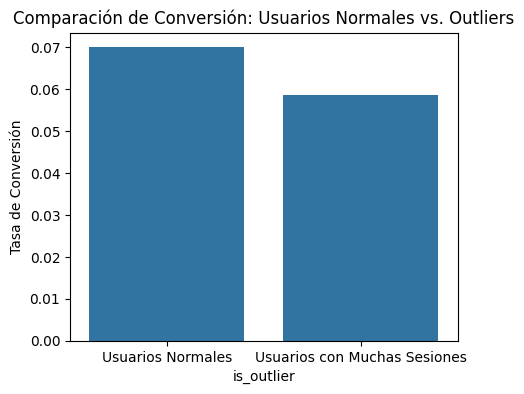

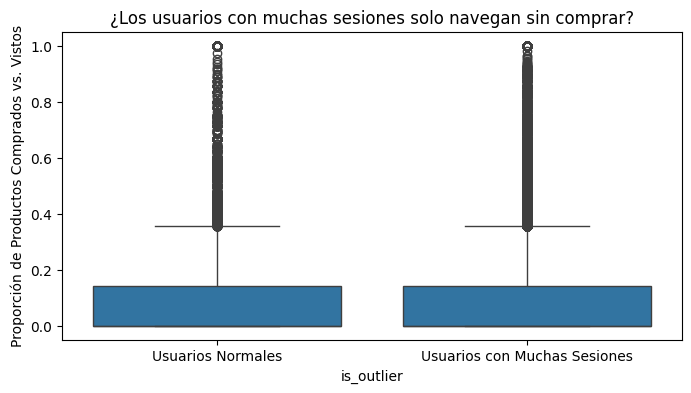

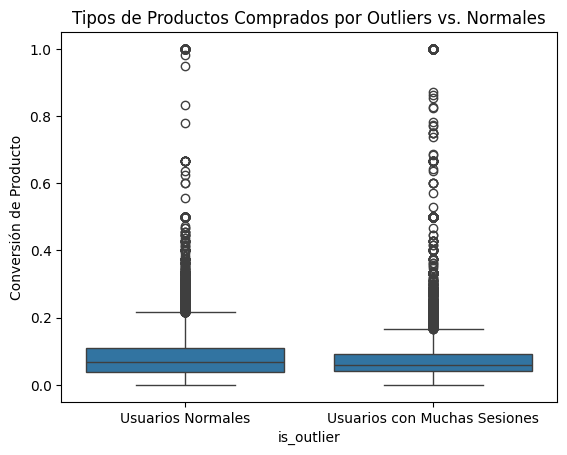

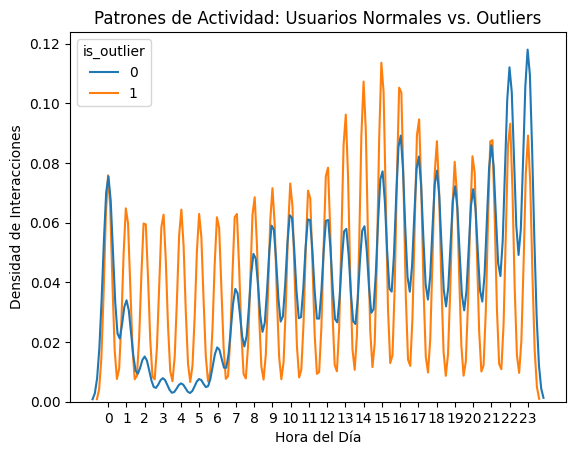

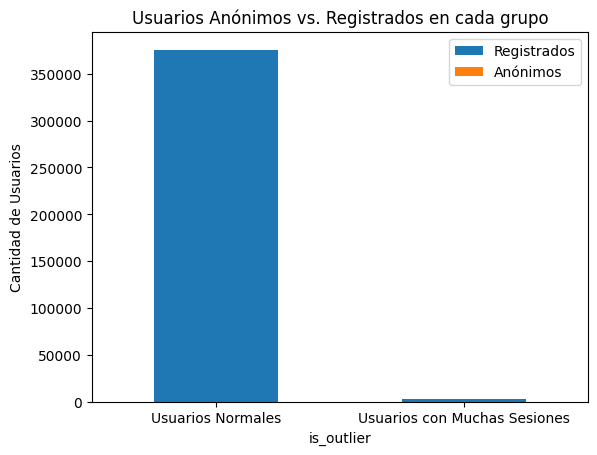

In [23]:
# 🔹 Identificar usuarios con muchas sesiones (outliers)
sessions_per_user = train.groupby("user_id")["session_id"].nunique()
outlier_threshold = sessions_per_user.quantile(0.99)  # Usuarios con más sesiones que el percentil 99
outlier_users = sessions_per_user[sessions_per_user > outlier_threshold].index

# 🔹 Comparar compras de outliers vs. usuarios normales
train["is_outlier"] = train["user_id"].isin(outlier_users).astype(int)
conversion_by_group = train.groupby("is_outlier")["add_to_cart"].mean()

plt.figure(figsize=(5, 4))
sns.barplot(x=conversion_by_group.index, y=conversion_by_group.values)
plt.xticks(ticks=[0, 1], labels=["Usuarios Normales", "Usuarios con Muchas Sesiones"])
plt.ylabel("Tasa de Conversión")
plt.title("Comparación de Conversión: Usuarios Normales vs. Outliers")
plt.show()

# 🔹 Productos que ven vs. productos que compran
products_seen = train.groupby("user_id")["partnumber"].nunique()
products_bought = train[train["add_to_cart"] == 1].groupby("user_id")["partnumber"].nunique()
product_ratio = products_bought / products_seen
product_ratio = product_ratio.fillna(0)  # Evitar NaN para usuarios sin compras

plt.figure(figsize=(8, 4))
sns.boxplot(x=train["is_outlier"], y=product_ratio)
plt.xticks(ticks=[0, 1], labels=["Usuarios Normales", "Usuarios con Muchas Sesiones"])
plt.ylabel("Proporción de Productos Comprados vs. Vistos")
plt.title("¿Los usuarios con muchas sesiones solo navegan sin comprar?")
plt.show()

# 🔹 Tipos de productos que compran
product_conversion = train.groupby(["is_outlier", "partnumber"])["add_to_cart"].mean().reset_index()
sns.boxplot(data=product_conversion, x="is_outlier", y="add_to_cart")
plt.xticks(ticks=[0, 1], labels=["Usuarios Normales", "Usuarios con Muchas Sesiones"])
plt.ylabel("Conversión de Producto")
plt.title("Tipos de Productos Comprados por Outliers vs. Normales")
plt.show()

# 🔹 Distribución horaria de actividad
train["hour"] = train["timestamp_local"].dt.hour
sns.kdeplot(data=train, x="hour", hue="is_outlier", common_norm=False)
plt.xticks(range(0, 24))
plt.xlabel("Hora del Día")
plt.ylabel("Densidad de Interacciones")
plt.title("Patrones de Actividad: Usuarios Normales vs. Outliers")
plt.show()

# 🔹 ¿Son anónimos o registrados?
anon_vs_registered = train.groupby(["is_outlier", "user_id"]).size().reset_index()
anon_vs_registered["is_anonymous"] = anon_vs_registered["user_id"] == -1
anon_counts = anon_vs_registered.groupby(["is_outlier", "is_anonymous"]).size().unstack()

anon_counts.plot(kind="bar", stacked=True)
plt.xticks(ticks=[0, 1], labels=["Usuarios Normales", "Usuarios con Muchas Sesiones"], rotation=0)
plt.ylabel("Cantidad de Usuarios")
plt.title("Usuarios Anónimos vs. Registrados en cada grupo")
plt.legend(["Registrados", "Anónimos"])
plt.show()

- No eliminamos usuarios con muchas sesiones porque:
    - Compran productos con tasas de conversión similares a los normales.
    - No hay evidencia fuerte de que solo navegan sin intención de compra.
    - Representan un segmento de usuarios con comportamiento específico.
- Acción a Tomar:
    - Marcarlos como una característica en el modelo (is_outlier = 1 o 0).
    - Considerar técnicas de normalización para manejar su impacto en el entrenamiento.

##### Normalización de Usuarios con muchas sessiones

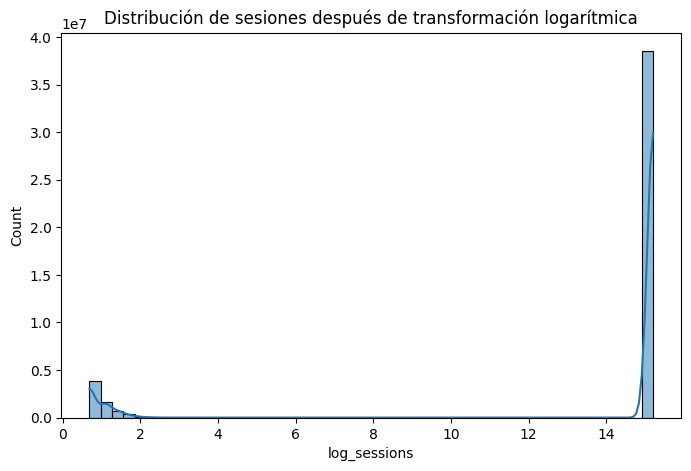

In [24]:
import numpy as np

# 📌 Aplicar transformación logarítmica a sesiones por usuario
train['log_sessions'] = np.log1p(train.groupby('user_id')['session_id'].transform('nunique'))

# 📊 Verificar la nueva distribución
plt.figure(figsize=(8, 5))
sns.histplot(train['log_sessions'], bins=50, kde=True)
plt.title("Distribución de sesiones después de transformación logarítmica")
plt.show()

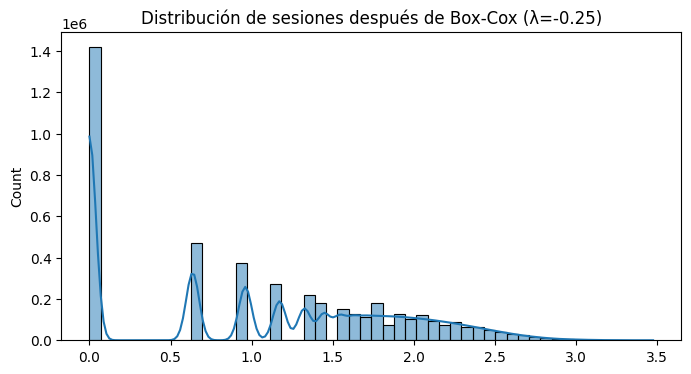

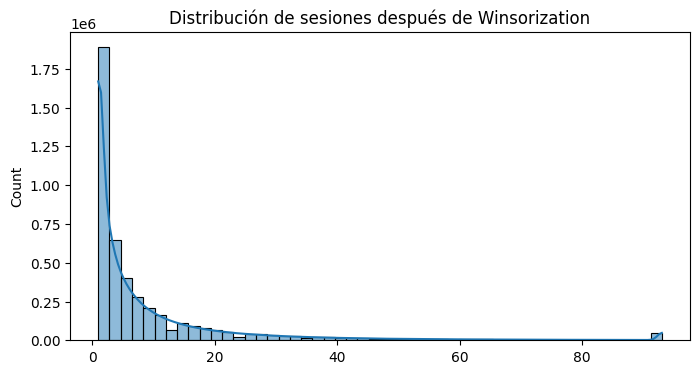

In [25]:
from scipy.stats import boxcox
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Aplicar Box-Cox (si es posible)
sessions = train['session_id'].value_counts()
sessions = sessions[sessions > 0]  # Evitar valores cero o negativos
sessions_boxcox, lambda_value = boxcox(sessions)

# 📊 Visualizar resultado
plt.figure(figsize=(8, 4))
sns.histplot(sessions_boxcox, bins=50, kde=True)
plt.title(f"Distribución de sesiones después de Box-Cox (λ={lambda_value:.2f})")
plt.show()

# 📌 Si Box-Cox no funciona bien, aplicamos Winsorization
from scipy.stats.mstats import winsorize

sessions_winsor = winsorize(sessions, limits=[0, 0.01])  # Recorta top 1%
plt.figure(figsize=(8, 4))
sns.histplot(sessions_winsor, bins=50, kde=True)
plt.title("Distribución de sesiones después de Winsorization")
plt.show()

In [26]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# 📂 Cargar dataset procesado
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")

# 📊 Aplicar winsorización al número de sesiones por usuario
session_counts = train.groupby("user_id")["session_id"].nunique()
session_counts_winsorized = winsorize(session_counts, limits=[0, 0.01])  # Recorta el 1% superior

# 🔄 Convertir a Series con el mismo índice original
session_counts_winsorized = pd.Series(session_counts_winsorized, index=session_counts.index)

# 🔄 Mapear los valores transformados al dataset
train["winsorized_sessions"] = train["user_id"].map(session_counts_winsorized)

# 💾 Guardar dataset actualizado
train.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")

print("✅ Transformación con winsorización aplicada y dataset guardado.")


✅ Transformación con winsorización aplicada y dataset guardado.


##### Alineamos dataset train y test

/tmp/ipykernel_1315097/3951801023.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)


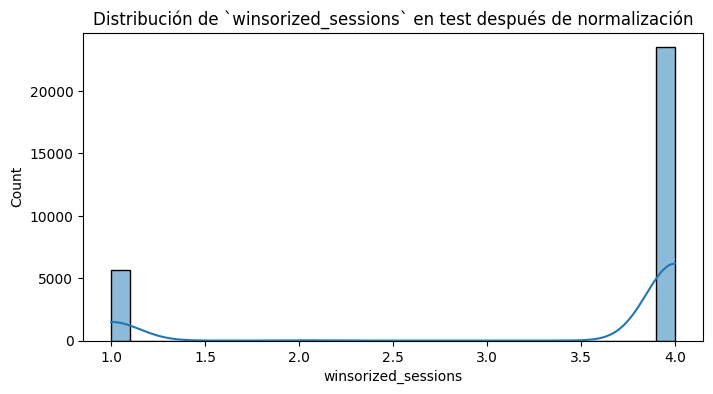

✅ Winsorización aplicada en `test`. Cambios guardados.


In [27]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# 📂 Cargar los datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

# 1️⃣ **Obtener sesiones normalizadas de train**
session_counts_train = train.groupby("user_id")["session_id"].nunique()
session_counts_winsorized_train = winsorize(session_counts_train, limits=[0, 0.01])  # Recorta el 1% superior

# 2️⃣ **Aplicar la misma normalización en test**
session_counts_test = test.groupby("user_id")["session_id"].nunique()

# 🔄 Aplicar winsorización a los valores de test usando los mismos percentiles de train
session_counts_winsorized_test = np.clip(session_counts_test, session_counts_winsorized_train.min(), session_counts_winsorized_train.max())

# 3️⃣ **Mapear `winsorized_sessions` en test**
test["winsorized_sessions"] = test["user_id"].map(session_counts_winsorized_test)

# 4️⃣ **Asignar valor por defecto a usuarios nuevos en test**
default_winsorized_value = session_counts_winsorized_train.min()  # Valor mínimo en train
test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)

# 5️⃣ **Revisar distribución**
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(test["winsorized_sessions"], bins=30, kde=True)
plt.title("Distribución de `winsorized_sessions` en test después de normalización")
plt.show()

# 💾 **Guardar test con la nueva columna**
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

print("✅ Winsorización aplicada en `test`. Cambios guardados.")


In [28]:
print("Test")
print(test["winsorized_sessions"].describe())
print("Train")
print(train["winsorized_sessions"].describe())

Test
count    29275.000000
mean         3.411887
std          1.188687
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: winsorized_sessions, dtype: float64
Train
count    4.526426e+07
mean     3.654364e+00
std      9.015273e-01
min      1.000000e+00
25%      4.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      4.000000e+00
Name: winsorized_sessions, dtype: float64


In [29]:
test.columns

Index(['session_id', 'date', 'timestamp_local', 'user_id', 'country',
       'partnumber', 'device_type', 'pagetype', 'winsorized_sessions'],
      dtype='object')

/tmp/ipykernel_1315097/3951801023.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)


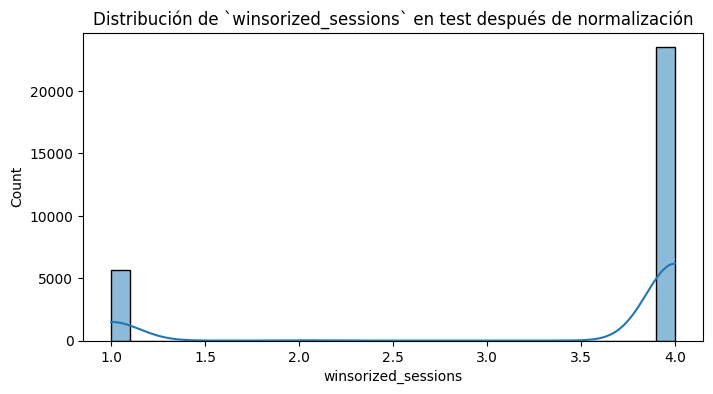

✅ Winsorización aplicada en `test`. Cambios guardados.


In [30]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# 📂 Cargar los datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

# 1️⃣ **Obtener sesiones normalizadas de train**
session_counts_train = train.groupby("user_id")["session_id"].nunique()
session_counts_winsorized_train = winsorize(session_counts_train, limits=[0, 0.01])  # Recorta el 1% superior

# 2️⃣ **Aplicar la misma normalización en test**
session_counts_test = test.groupby("user_id")["session_id"].nunique()

# 🔄 Aplicar winsorización a los valores de test usando los mismos percentiles de train
session_counts_winsorized_test = np.clip(session_counts_test, session_counts_winsorized_train.min(), session_counts_winsorized_train.max())

# 3️⃣ **Mapear `winsorized_sessions` en test**
test["winsorized_sessions"] = test["user_id"].map(session_counts_winsorized_test)

# 4️⃣ **Asignar valor por defecto a usuarios nuevos en test**
default_winsorized_value = session_counts_winsorized_train.min()  # Valor mínimo en train
test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)

# 5️⃣ **Revisar distribución**
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(test["winsorized_sessions"], bins=30, kde=True)
plt.title("Distribución de `winsorized_sessions` en test después de normalización")
plt.show()

# 💾 **Guardar test con la nueva columna**
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

print("✅ Winsorización aplicada en `test`. Cambios guardados.")


/tmp/ipykernel_1315097/3951801023.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)


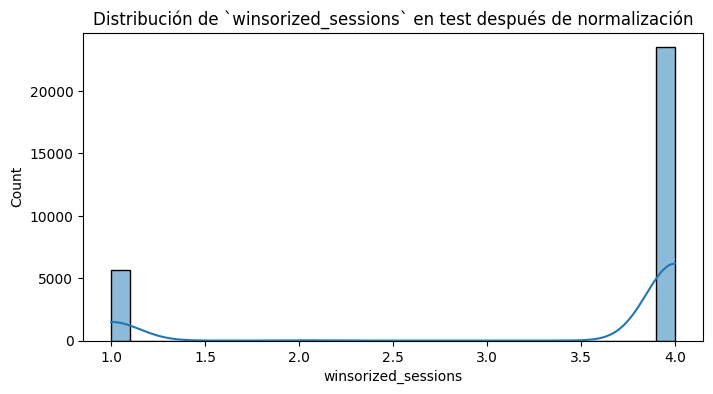

✅ Winsorización aplicada en `test`. Cambios guardados.


In [31]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

# 📂 Cargar los datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/test_optimized.parquet")

# 1️⃣ **Obtener sesiones normalizadas de train**
session_counts_train = train.groupby("user_id")["session_id"].nunique()
session_counts_winsorized_train = winsorize(session_counts_train, limits=[0, 0.01])  # Recorta el 1% superior

# 2️⃣ **Aplicar la misma normalización en test**
session_counts_test = test.groupby("user_id")["session_id"].nunique()

# 🔄 Aplicar winsorización a los valores de test usando los mismos percentiles de train
session_counts_winsorized_test = np.clip(session_counts_test, session_counts_winsorized_train.min(), session_counts_winsorized_train.max())

# 3️⃣ **Mapear `winsorized_sessions` en test**
test["winsorized_sessions"] = test["user_id"].map(session_counts_winsorized_test)

# 4️⃣ **Asignar valor por defecto a usuarios nuevos en test**
default_winsorized_value = session_counts_winsorized_train.min()  # Valor mínimo en train
test["winsorized_sessions"].fillna(default_winsorized_value, inplace=True)

# 5️⃣ **Revisar distribución**
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(test["winsorized_sessions"], bins=30, kde=True)
plt.title("Distribución de `winsorized_sessions` en test después de normalización")
plt.show()

# 💾 **Guardar test con la nueva columna**
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

print("✅ Winsorización aplicada en `test`. Cambios guardados.")


####  Evaluación de pagetype y device_type

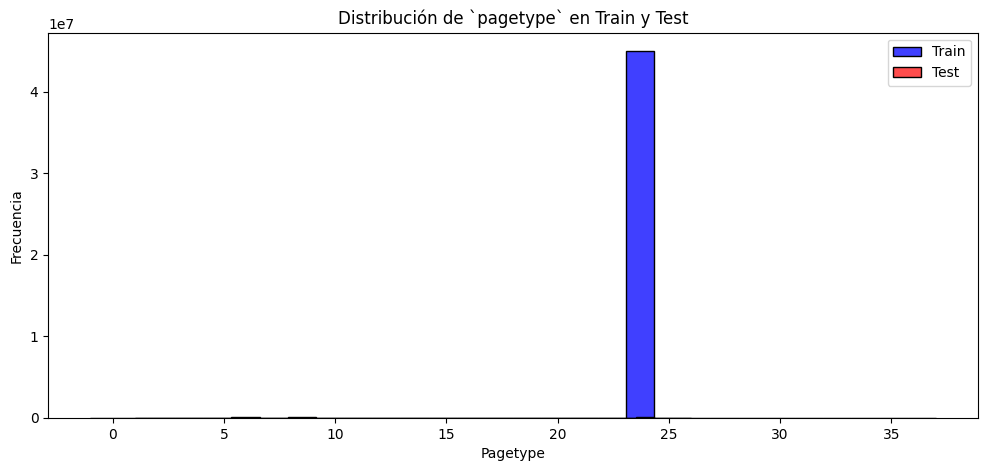

/tmp/ipykernel_1315097/87229015.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pagetype", y="add_to_cart", data=pagetype_conversion, palette="Blues_r")


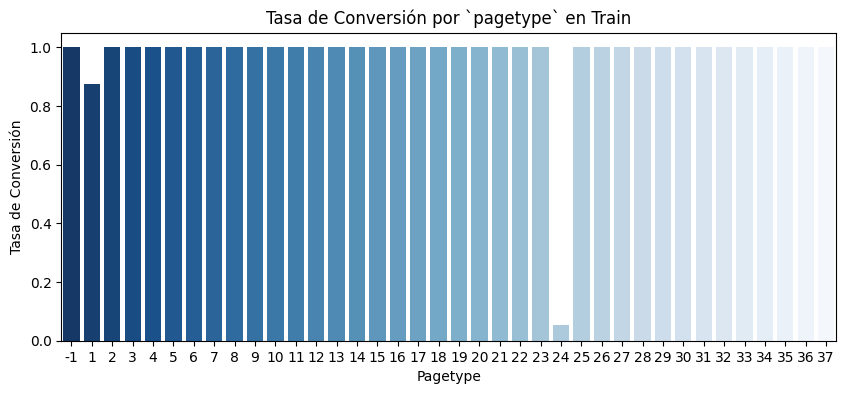

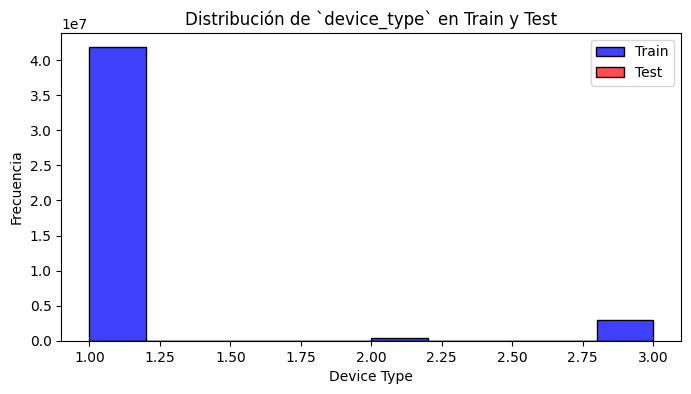

/tmp/ipykernel_1315097/87229015.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="device_type", y="add_to_cart", data=device_conversion, palette="Blues_r")


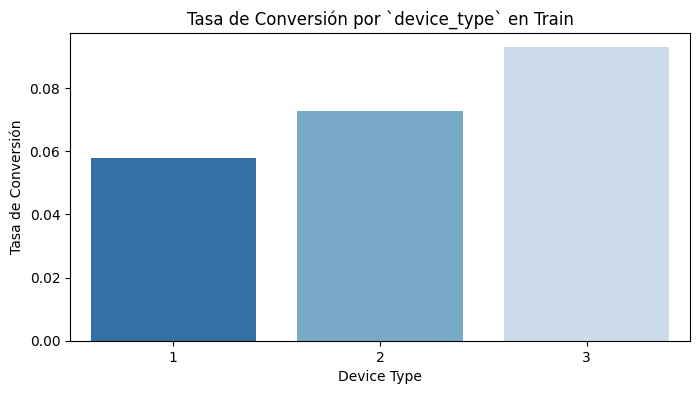

Pagetype en Train pero no en Test: {2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 18, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, -1}
Pagetype en Test pero no en Train: set()
Device Type en Train pero no en Test: set()
Device Type en Test pero no en Train: set()


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

### 🔹 1️⃣ Distribución de `pagetype` en `train` y `test`
plt.figure(figsize=(12, 5))
sns.histplot(train["pagetype"], kde=False, bins=30, color="blue", label="Train", stat="count")
sns.histplot(test["pagetype"], kde=False, bins=30, color="red", label="Test", stat="count", alpha=0.7)
plt.legend()
plt.title("Distribución de `pagetype` en Train y Test")
plt.xlabel("Pagetype")
plt.ylabel("Frecuencia")
plt.show()

### 🔹 2️⃣ Impacto de `pagetype` en `add_to_cart` (solo en Train)
pagetype_conversion = train.groupby("pagetype")["add_to_cart"].mean().reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(x="pagetype", y="add_to_cart", data=pagetype_conversion, palette="Blues_r")
plt.title("Tasa de Conversión por `pagetype` en Train")
plt.xlabel("Pagetype")
plt.ylabel("Tasa de Conversión")
plt.show()

### 🔹 3️⃣ Distribución de `device_type` en `train` y `test`
plt.figure(figsize=(8, 4))
sns.histplot(train["device_type"], kde=False, bins=10, color="blue", label="Train", stat="count")
sns.histplot(test["device_type"], kde=False, bins=10, color="red", label="Test", stat="count", alpha=0.7)
plt.legend()
plt.title("Distribución de `device_type` en Train y Test")
plt.xlabel("Device Type")
plt.ylabel("Frecuencia")
plt.show()

### 🔹 4️⃣ Impacto de `device_type` en `add_to_cart` (solo en Train)
device_conversion = train.groupby("device_type")["add_to_cart"].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x="device_type", y="add_to_cart", data=device_conversion, palette="Blues_r")
plt.title("Tasa de Conversión por `device_type` en Train")
plt.xlabel("Device Type")
plt.ylabel("Tasa de Conversión")
plt.show()


print("Pagetype en Train pero no en Test:", set(train["pagetype"].unique()) - set(test["pagetype"].unique()))
print("Pagetype en Test pero no en Train:", set(test["pagetype"].unique()) - set(train["pagetype"].unique()))

print("Device Type en Train pero no en Test:", set(train["device_type"].unique()) - set(test["device_type"].unique()))
print("Device Type en Test pero no en Train:", set(test["device_type"].unique()) - set(train["device_type"].unique()))



##### Analizamos estas columnas en test


/tmp/ipykernel_1315097/2497542826.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pagetype_counts.index, y=pagetype_counts.values, palette="Blues_r")


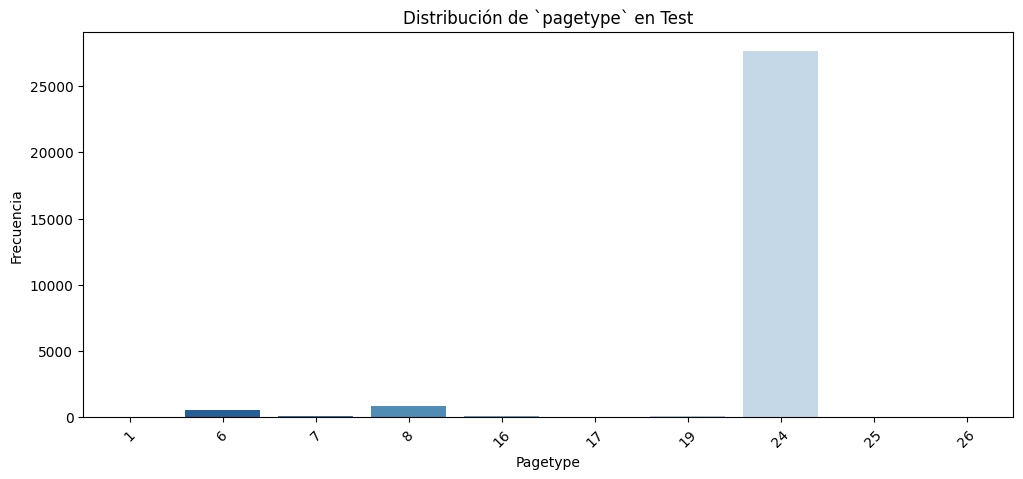

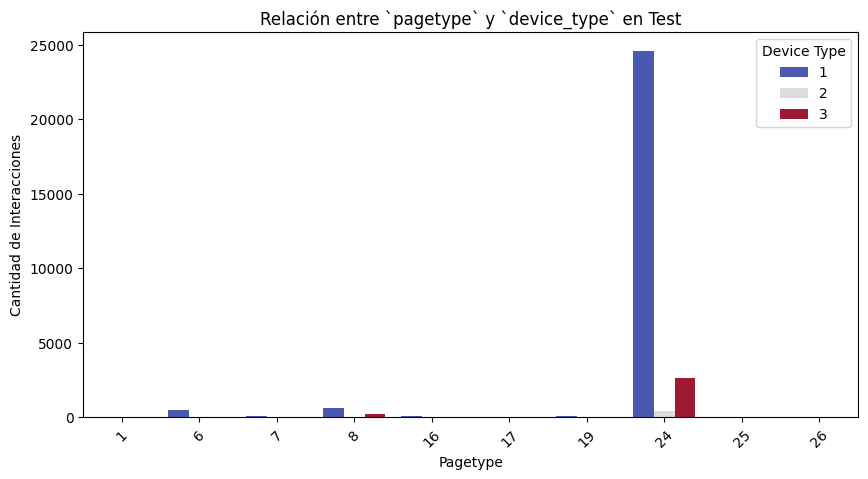

/tmp/ipykernel_1315097/2497542826.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=products_per_pagetype.index, y=products_per_pagetype.values, palette="Greens_r")


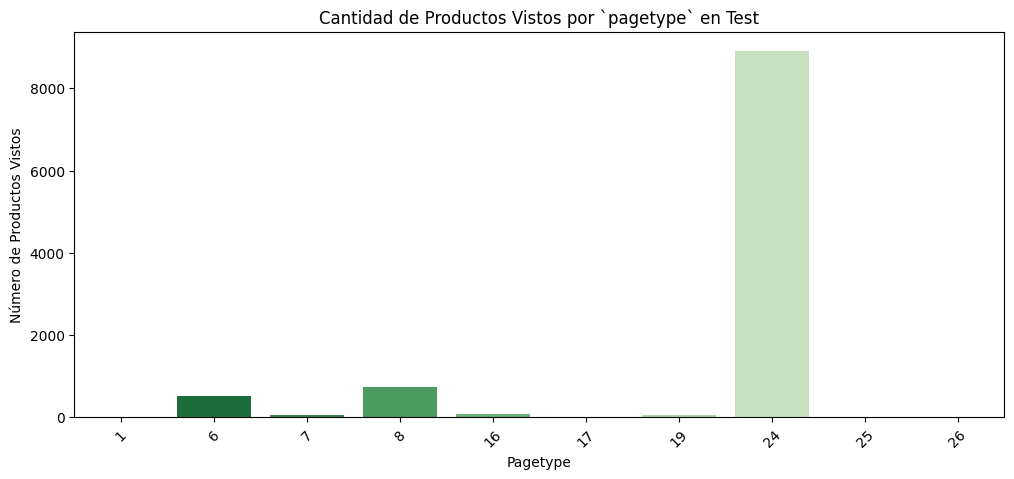

/tmp/ipykernel_1315097/2497542826.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=session_duration_per_pagetype.index, y=session_duration_per_pagetype.values, palette="Purples_r")


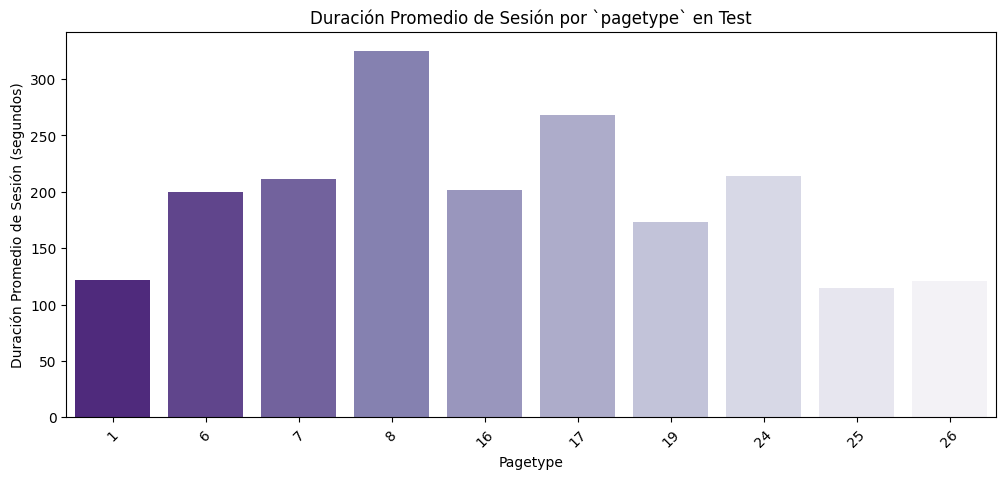

/tmp/ipykernel_1315097/2497542826.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anonymous_ratio.index, y=anonymous_ratio.values, palette="Reds_r")


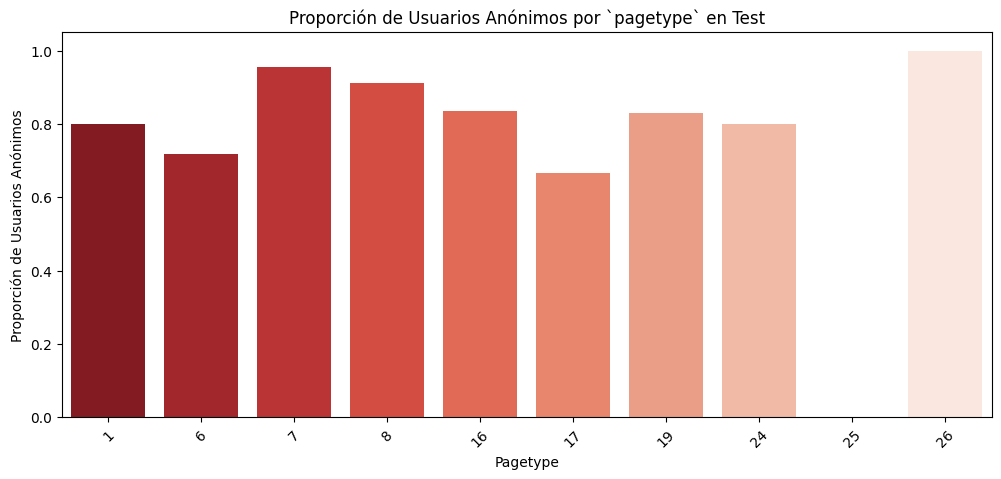

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar el dataset de test
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet"
test = pd.read_parquet(test_path)

# 🔍 1️⃣ Frecuencia de `pagetype` en `test`
pagetype_counts = test["pagetype"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=pagetype_counts.index, y=pagetype_counts.values, palette="Blues_r")
plt.xlabel("Pagetype")
plt.ylabel("Frecuencia")
plt.title("Distribución de `pagetype` en Test")
plt.xticks(rotation=45)
plt.show()

# 🔍 2️⃣ Relación de `pagetype` con `device_type`
plt.figure(figsize=(10, 5))
sns.countplot(data=test, x="pagetype", hue="device_type", palette="coolwarm")
plt.xlabel("Pagetype")
plt.ylabel("Cantidad de Interacciones")
plt.title("Relación entre `pagetype` y `device_type` en Test")
plt.xticks(rotation=45)
plt.legend(title="Device Type")
plt.show()

# 🔍 3️⃣ Relación de `pagetype` con cantidad de productos vistos
products_per_pagetype = test.groupby("pagetype")["partnumber"].nunique()
plt.figure(figsize=(12, 5))
sns.barplot(x=products_per_pagetype.index, y=products_per_pagetype.values, palette="Greens_r")
plt.xlabel("Pagetype")
plt.ylabel("Número de Productos Vistos")
plt.title("Cantidad de Productos Vistos por `pagetype` en Test")
plt.xticks(rotation=45)
plt.show()

# 🔍 4️⃣ Relación de `pagetype` con duración de sesión
test["session_duration"] = test.groupby("session_id")["timestamp_local"].transform(lambda x: (x.max() - x.min()).total_seconds())
session_duration_per_pagetype = test.groupby("pagetype")["session_duration"].mean()
plt.figure(figsize=(12, 5))
sns.barplot(x=session_duration_per_pagetype.index, y=session_duration_per_pagetype.values, palette="Purples_r")
plt.xlabel("Pagetype")
plt.ylabel("Duración Promedio de Sesión (segundos)")
plt.title("Duración Promedio de Sesión por `pagetype` en Test")
plt.xticks(rotation=45)
plt.show()

# 🔍 5️⃣ Relación de `pagetype` con usuarios anónimos vs registrados
test["is_anonymous"] = (test["user_id"] == -1).astype(int)
anonymous_ratio = test.groupby("pagetype")["is_anonymous"].mean()
plt.figure(figsize=(12, 5))
sns.barplot(x=anonymous_ratio.index, y=anonymous_ratio.values, palette="Reds_r")
plt.xlabel("Pagetype")
plt.ylabel("Proporción de Usuarios Anónimos")
plt.title("Proporción de Usuarios Anónimos por `pagetype` en Test")
plt.xticks(rotation=45)
plt.show()


##### Análisis clave:


1. **Distribución de `pagetype`**  
   - La mayoría de las interacciones en `test` ocurren en `pagetype = 24`, mientras que otras categorías tienen una representación mínima.  
   - Esto indica que la variabilidad en `pagetype` es muy baja en `test`, lo que podría hacer que esta característica no sea útil para la predicción.  

2. **Relación entre `pagetype` y `device_type`**  
   - La mayoría de las interacciones en `pagetype = 24` provienen de `device_type = 1`.  
   - Otras combinaciones tienen muy pocas interacciones, lo que reduce la capacidad de `pagetype` para diferenciar patrones de usuario.  

3. **Cantidad de productos vistos por `pagetype`**  
   - `pagetype = 24` también domina en términos de número de productos vistos.  
   - La baja diversidad en otras categorías refuerza la idea de que esta variable puede no aportar mucho al modelo.  

4. **Duración promedio de sesión por `pagetype`**  
   - Existen diferencias en la duración promedio de sesión según `pagetype`, pero esto no es suficiente para justificar su inclusión en el modelo si la mayoría de los datos están en una sola categoría.  

5. **Proporción de usuarios anónimos por `pagetype`**  
   - Algunos `pagetype` están dominados por usuarios anónimos, lo que puede indicar que la información proviene de usuarios sin historial.  
   - Esto puede hacer que `pagetype` sea redundante con otras características como `device_type` o `country`.  


##### Análisis del impacto de pagetype en train tras ver la baja teórica correlación en test

/tmp/ipykernel_1315097/2096014239.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pagetype_counts.index, y=pagetype_counts.values, palette="Blues_r")


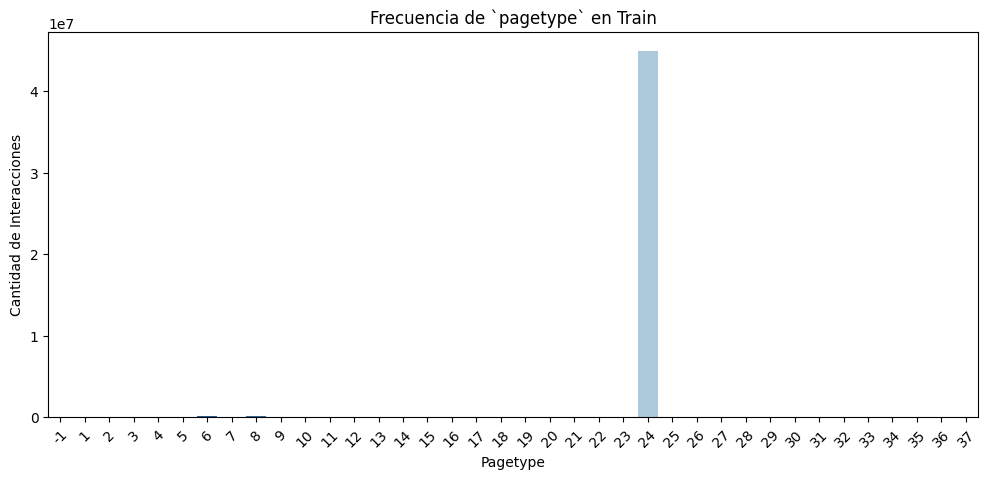

/tmp/ipykernel_1315097/2096014239.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pagetype", y="add_to_cart", data=pagetype_conversion, palette="Blues_r")


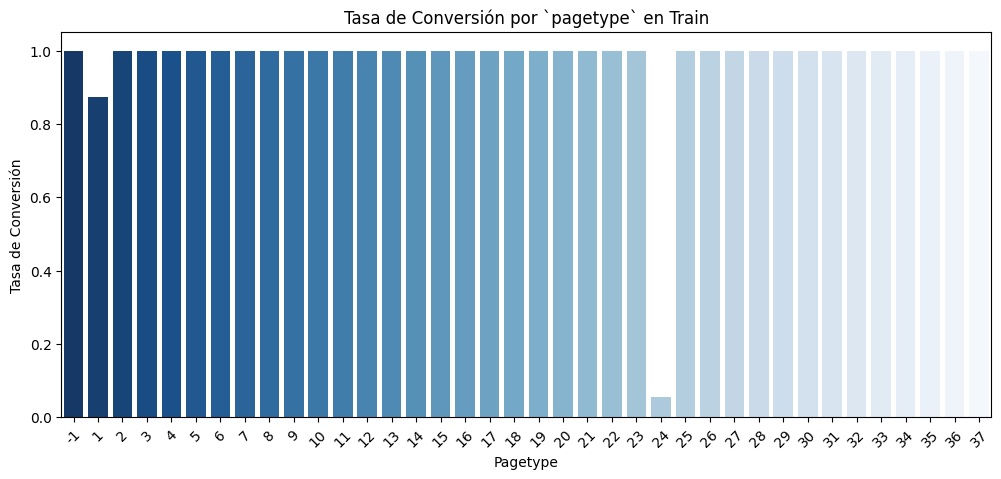

/tmp/ipykernel_1315097/2096014239.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pagetype_grouped_conversion.index, y=pagetype_grouped_conversion.values, palette="Blues_r")


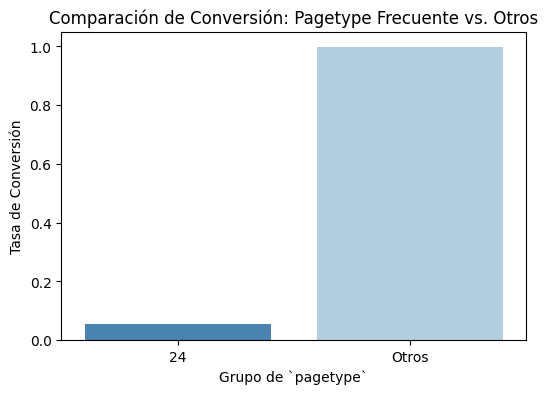

📊 Tasa de Conversión por `pagetype` en Train:
    pagetype  add_to_cart
0         -1     1.000000
18        18     1.000000
21        21     1.000000
22        22     1.000000
23        23     1.000000
25        25     1.000000
26        26     1.000000
27        27     1.000000
28        28     1.000000
29        29     1.000000
30        30     1.000000
31        31     1.000000
32        32     1.000000
33        33     1.000000
34        34     1.000000
35        35     1.000000
36        36     1.000000
20        20     1.000000
19        19     1.000000
10        10     1.000000
9          9     1.000000
2          2     1.000000
3          3     1.000000
4          4     1.000000
5          5     1.000000
6          6     1.000000
7          7     1.000000
8          8     1.000000
37        37     1.000000
17        17     1.000000
11        11     1.000000
12        12     1.000000
13        13     1.000000
14        14     1.000000
15        15     1.000000
16        16     1

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar dataset de train
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")

# 🔍 1️⃣ Cantidad de interacciones por `pagetype`
pagetype_counts = train["pagetype"].value_counts()

plt.figure(figsize=(12, 5))
sns.barplot(x=pagetype_counts.index, y=pagetype_counts.values, palette="Blues_r")
plt.title("Frecuencia de `pagetype` en Train")
plt.xlabel("Pagetype")
plt.ylabel("Cantidad de Interacciones")
plt.xticks(rotation=45)
plt.show()

# 🔍 2️⃣ Tasa de conversión por `pagetype`
pagetype_conversion = train.groupby("pagetype")["add_to_cart"].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(x="pagetype", y="add_to_cart", data=pagetype_conversion, palette="Blues_r")
plt.title("Tasa de Conversión por `pagetype` en Train")
plt.xlabel("Pagetype")
plt.ylabel("Tasa de Conversión")
plt.xticks(rotation=45)
plt.show()

# 🔍 3️⃣ Comparación de conversión entre pagetype frecuente y otros
top_pagetype = pagetype_counts.idxmax()  # Pagetype más frecuente
train["pagetype_grouped"] = train["pagetype"].apply(lambda x: x if x == top_pagetype else "Otros")

pagetype_grouped_conversion = train.groupby("pagetype_grouped")["add_to_cart"].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=pagetype_grouped_conversion.index, y=pagetype_grouped_conversion.values, palette="Blues_r")
plt.title("Comparación de Conversión: Pagetype Frecuente vs. Otros")
plt.xlabel("Grupo de `pagetype`")
plt.ylabel("Tasa de Conversión")
plt.show()

# 📌 Imprimir métricas clave
print("📊 Tasa de Conversión por `pagetype` en Train:")
print(pagetype_conversion.sort_values(by="add_to_cart", ascending=False))

print("\n📊 Comparación de Conversión entre `pagetype` más frecuente y otros:")
print(pagetype_grouped_conversion)


La variable pagetype parece tener un impacto muy fuerte en la conversión. 

Los valores menos frecuentes tienen tasas de conversión cercanas al 100%, mientras que pagetype = 24 tiene una tasa de conversión significativamente más baja (~6.36%).

Esto sugiere que podríamos:
- ✅ Mantener pagetype, pero quizás binarizarlo en dos grupos: 24 vs. Otros.
- ✅ Explorar si hay sesgo en los datos, dado que tasas del 100% suelen indicar problemas de muestreo.
- ✅ Revisar la relación de pagetype con otras variables como device_type y user_type para ver si refuerza este patrón.

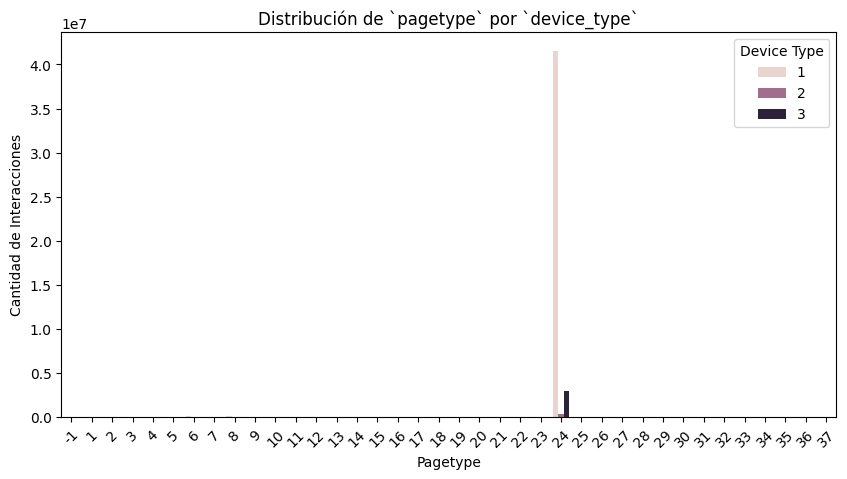

/tmp/ipykernel_1348589/1475232174.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train.groupby("pagetype")["is_anonymous"].mean().reset_index(),


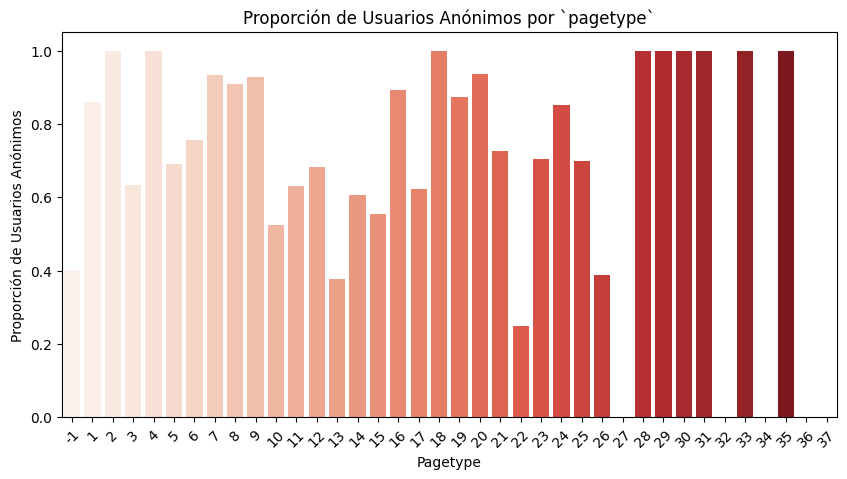

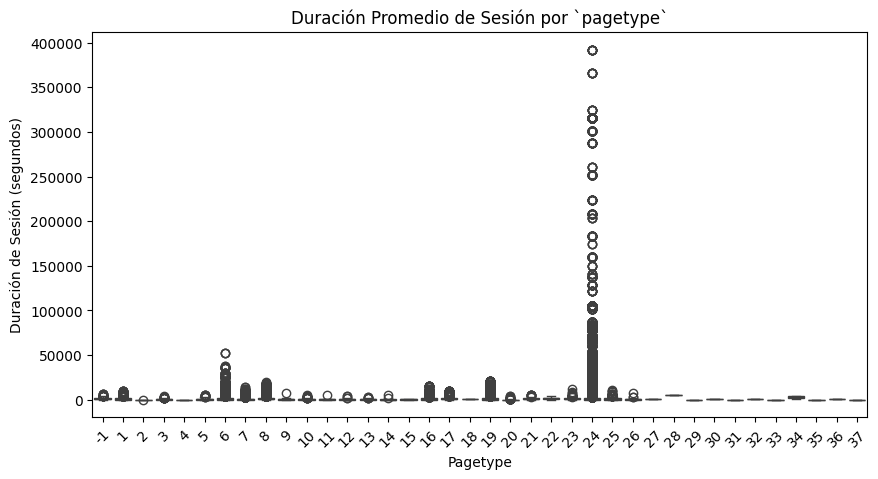

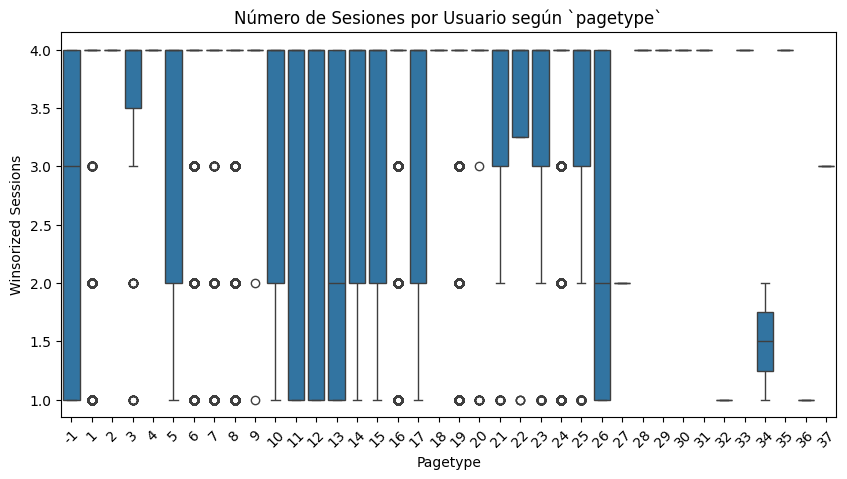

✅ Análisis de relaciones completado.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar dataset
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")

# 🔹 Calcular la duración de la sesión
train["session_duration"] = train.groupby("session_id")["timestamp_local"].transform(lambda x: (x.max() - x.min()).total_seconds())

# 1️⃣ **Relación entre `pagetype` y `device_type`**
plt.figure(figsize=(10, 5))
sns.countplot(data=train, x="pagetype", hue="device_type")
plt.title("Distribución de `pagetype` por `device_type`")
plt.xlabel("Pagetype")
plt.ylabel("Cantidad de Interacciones")
plt.xticks(rotation=45)
plt.legend(title="Device Type")
plt.show()

# 2️⃣ **Relación entre `pagetype` y tipo de usuario (anónimo vs registrado)**
train["is_anonymous"] = (train["user_id"] == -1).astype(int)

plt.figure(figsize=(10, 5))
sns.barplot(data=train.groupby("pagetype")["is_anonymous"].mean().reset_index(), 
            x="pagetype", y="is_anonymous", palette="Reds")
plt.title("Proporción de Usuarios Anónimos por `pagetype`")
plt.xlabel("Pagetype")
plt.ylabel("Proporción de Usuarios Anónimos")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ **Relación entre `pagetype` y duración de la sesión**
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x="pagetype", y="session_duration")
plt.title("Duración Promedio de Sesión por `pagetype`")
plt.xlabel("Pagetype")
plt.ylabel("Duración de Sesión (segundos)")
plt.xticks(rotation=45)
plt.show()

# 4️⃣ **Relación entre `pagetype` y número de sesiones por usuario**
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x="pagetype", y="winsorized_sessions")
plt.title("Número de Sesiones por Usuario según `pagetype`")
plt.xlabel("Pagetype")
plt.ylabel("Winsorized Sessions")
plt.xticks(rotation=45)
plt.show()

print("✅ Análisis de relaciones completado.")


Las gráficas muestran que pagetype no tiene una correlación fuerte con variables como device_type, la proporción de usuarios anónimos, la duración de la sesión o el número de sesiones por usuario.

- **Decidimos eliminar pagepyte de ambos dataset**

#### Eliminamos Pagetype de los datasets

In [ ]:
import pandas as pd

# 📂 Cargar los datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 🗑️ Eliminar la columna `pagetype`
train.drop(columns=["pagetype"], inplace=True)
test.drop(columns=["pagetype"], inplace=True)

# 💾 Guardar datasets actualizados
train.to_parquet(train_path, index=False)
test.to_parquet(test_path, index=False)

print("✅ `pagetype` eliminado de train y test. Cambios guardados.")


####  Revisión de la Distribución Temporal

- Distribución de sesiones en el tiempo (histograma de fechas).
- Distribución de sesiones por día de la semana (para ver patrones semanales).
- Distribución de sesiones por hora del día (para analizar horarios de actividad).

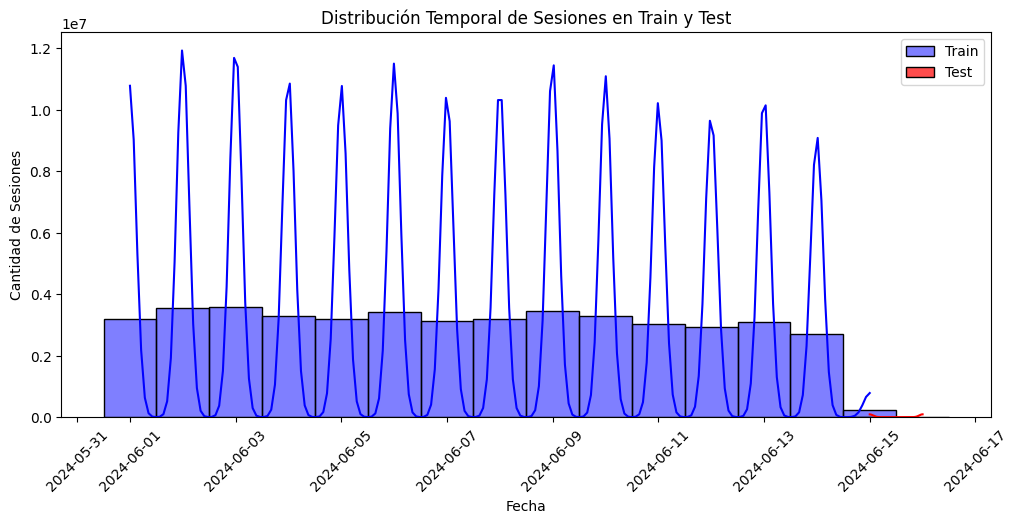

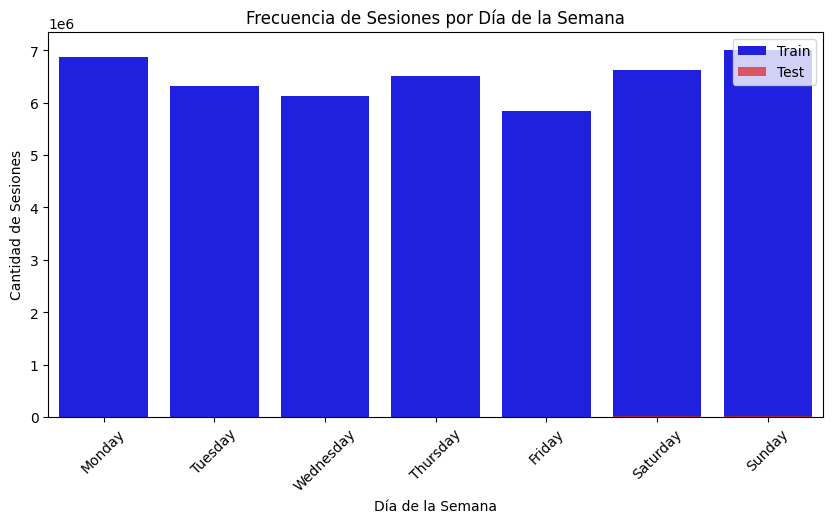

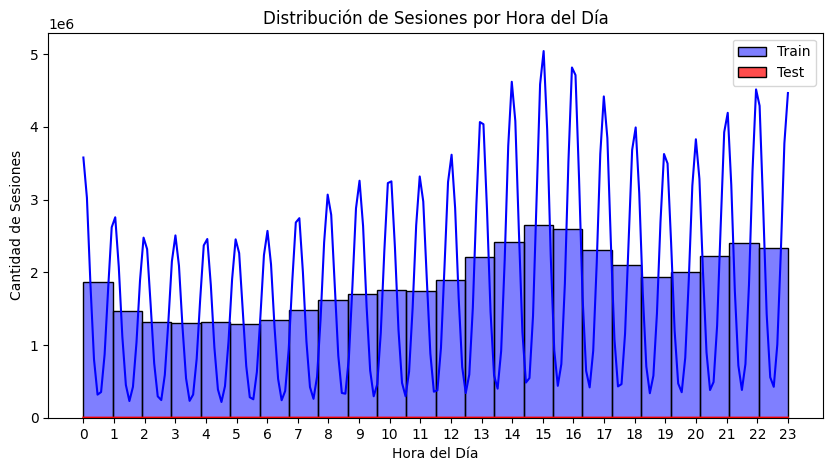

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar los datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 🕒 Convertir timestamps a fecha
train["date"] = pd.to_datetime(train["timestamp_local"]).dt.date
test["date"] = pd.to_datetime(test["timestamp_local"]).dt.date

# 📅 1️⃣ Distribución de sesiones a lo largo del tiempo
plt.figure(figsize=(12, 5))
sns.histplot(train["date"], bins=50, kde=True, color="blue", label="Train")
sns.histplot(test["date"], bins=50, kde=True, color="red", label="Test", alpha=0.7)
plt.legend()
plt.title("Distribución Temporal de Sesiones en Train y Test")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Sesiones")
plt.xticks(rotation=45)
plt.show()

# 🕒 2️⃣ Análisis de sesiones por día de la semana
train["weekday"] = pd.to_datetime(train["timestamp_local"]).dt.day_name()
test["weekday"] = pd.to_datetime(test["timestamp_local"]).dt.day_name()

plt.figure(figsize=(10, 5))
sns.countplot(x=train["weekday"], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], color="blue", label="Train")
sns.countplot(x=test["weekday"], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], color="red", label="Test", alpha=0.7)
plt.legend()
plt.title("Frecuencia de Sesiones por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Cantidad de Sesiones")
plt.xticks(rotation=45)
plt.show()

# ⏳ 3️⃣ Distribución de sesiones por hora del día
train["hour"] = pd.to_datetime(train["timestamp_local"]).dt.hour
test["hour"] = pd.to_datetime(test["timestamp_local"]).dt.hour

plt.figure(figsize=(10, 5))
sns.histplot(train["hour"], bins=24, kde=True, color="blue", label="Train")
sns.histplot(test["hour"], bins=24, kde=True, color="red", label="Test", alpha=0.7)
plt.legend()
plt.title("Distribución de Sesiones por Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Cantidad de Sesiones")
plt.xticks(range(0, 24))
plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar los datasets
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")

# 📅 Convertir la fecha a datetime si no lo está
train["date"] = pd.to_datetime(train["date"])
train["day_of_week"] = train["date"].dt.day_name()
train["hour"] = train["timestamp_local"].dt.hour

### 🔹 1️⃣ Tasa de Conversión por Día de la Semana
conversion_by_day = train.groupby("day_of_week")["add_to_cart"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(8, 5))
sns.barplot(x=conversion_by_day.index, y=conversion_by_day.values, palette="Blues_r")
plt.title("Tasa de Conversión por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Tasa de Conversión")
plt.show()

### 🔹 2️⃣ Tasa de Conversión por Hora del Día
conversion_by_hour = train.groupby("hour")["add_to_cart"].mean()

plt.figure(figsize=(8, 5))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values, marker="o", color="b")
plt.title("Tasa de Conversión por Hora del Día")
plt.xlabel("Hora del Día")
plt.ylabel("Tasa de Conversión")
plt.xticks(range(0, 24))
plt.show()

### 🔹 3️⃣ Comparación de Usuarios Anónimos vs Registrados
train["is_anonymous"] = train["user_id"] == -1
conversion_by_user_type = train.groupby("is_anonymous")["add_to_cart"].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=conversion_by_user_type.index.astype(str), y=conversion_by_user_type.values, palette="Blues_r")
plt.xticks(ticks=[0, 1], labels=["Registrados", "Anónimos"])
plt.title("Tasa de Conversión: Usuarios Registrados vs Anónimos")
plt.ylabel("Tasa de Conversión")
plt.show()


### 🔹 4️⃣ Importancia de Variables Temporales en Modelo Simple
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 🔹 Preparar los datos para un modelo simple
train_sample = train.sample(50000, random_state=42)  # Reducimos tamaño para rapidez

# 🔹 Convertir variables categóricas
encoder = LabelEncoder()
train_sample["day_of_week"] = encoder.fit_transform(train_sample["day_of_week"])

# 🔹 Definir variables
features = ["day_of_week", "hour"]
X = train_sample[features]
y = train_sample["add_to_cart"]

# 🔹 Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Entrenar un modelo de árbol simple
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# 🔹 Importancia de las variables
importances = model.feature_importances_
plt.figure(figsize=(6, 4))
sns.barplot(x=features, y=importances, palette="Blues_r")
plt.title("Importancia de Variables Temporales en Predicción")
plt.ylabel("Importancia")
plt.show()


KeyError: 'date'

Las gráficas muestran que las variables temporales (`day_of_week` y `hour`) tienen cierto impacto en la conversión, pero no parecen ser factores determinantes.  

- **Día de la Semana:** Se observa variabilidad en la tasa de conversión, pero no una tendencia clara o fuerte que justifique su inclusión obligatoria.  
- **Hora del Día:** Hay un patrón más marcado con picos en la mañana y la tarde, lo que sugiere que puede aportar algo de información al modelo.  
- **Usuarios Registrados vs. Anónimos:** Los usuarios registrados tienen una tasa de conversión mucho mayor, lo que indica que esta variable es relevante.  
- **Importancia de Variables Temporales:** Según la última gráfica, la `hour` tiene más impacto que `day_of_week`, pero en general, su peso es moderado.  

**Conclusión:**  
Eliminar `day_of_week` y conservar `hour` si queremos simplificar el modelo. También mantener la variable de usuarios registrados (`is_anonymous`) debido a su fuerte impacto en la conversión.  



In [9]:
print(train.columns)
print(test.columns)

Index(['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country',
       'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions',
       'hour', 'is_anonymous'],
      dtype='object')
Index(['session_id', 'timestamp_local', 'user_id', 'country', 'partnumber',
       'device_type', 'winsorized_sessions', 'hour', 'is_anonymous', 'date',
       'weekday'],
      dtype='object')


In [10]:
import pandas as pd

# 📂 Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 📅 Convertir `timestamp_local` a datetime y extraer la hora
train["timestamp_local"] = pd.to_datetime(train["timestamp_local"])
test["timestamp_local"] = pd.to_datetime(test["timestamp_local"])

train["hour"] = train["timestamp_local"].dt.hour
test["hour"] = test["timestamp_local"].dt.hour

# 🔹 Identificar usuarios anónimos
train["is_anonymous"] = (train["user_id"] == -1).astype(int)
test["is_anonymous"] = (test["user_id"] == -1).astype(int)

# 🗑️ Eliminar `date`
train.drop(columns=["date"], inplace=True)
test.drop(columns=["date"], inplace=True)

# 💾 Guardar datasets limpios
train.to_parquet(train_path, index=False)
test.to_parquet(test_path, index=False)

print("✅ Limpieza completada: Eliminamos `date`, conservamos `hour` y `is_anonymous`.")
print(train.head())
print(test.head())


KeyError: "['date'] not found in axis"

#### Revisamos test y train antes de continuar.

##### Debemos agregar la columna low_interaction en test

In [11]:
import pandas as pd

# 📂 Cargar los datasets limpios
train = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet")
test = pd.read_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

# 1️⃣ **Contar sesiones por usuario en `train` para identificar usuarios con baja interacción**
user_interaction_counts = train.groupby("user_id")["session_id"].nunique()
low_interaction_users = set(user_interaction_counts[user_interaction_counts <= 3].index)

# 2️⃣ **Aplicar la misma lógica en `test`**
test["low_interaction"] = test["user_id"].map(lambda x: int(x in low_interaction_users))

# 📌 Verificar la alineación final
print("✅ Columnas en train:", train.columns)
print("✅ Columnas en test:", test.columns)

# 💾 **Guardar el dataset actualizado**
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet")

print("🎯 `test` ahora está alineado con `train` y guardado como `test_model.parquet`.")


✅ Columnas en train: Index(['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country',
       'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions',
       'hour', 'is_anonymous'],
      dtype='object')
✅ Columnas en test: Index(['session_id', 'timestamp_local', 'user_id', 'country', 'partnumber',
       'device_type', 'winsorized_sessions', 'hour', 'is_anonymous',
       'low_interaction'],
      dtype='object')
🎯 `test` ahora está alineado con `train` y guardado como `test_model.parquet`.


## Products & Users 

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45264259 entries, 0 to 45264258
Data columns (total 11 columns):
 #   Column               Dtype         
---  ------               -----         
 0   session_id           int32         
 1   timestamp_local      datetime64[ns]
 2   add_to_cart          int8          
 3   user_id              int32         
 4   country              int8          
 5   partnumber           int32         
 6   device_type          int8          
 7   low_interaction      int64         
 8   winsorized_sessions  int64         
 9   hour                 int32         
 10  is_anonymous         int64         
dtypes: datetime64[ns](1), int32(4), int64(3), int8(3)
memory usage: 2.1 GB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29275 entries, 0 to 29274
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   session_id           29275 non-null  int32         
 1   timestamp_local      29275 non-null  datetime64[ns]
 2   user_id              29275 non-null  int32         
 3   country              29275 non-null  int8          
 4   partnumber           29275 non-null  int32         
 5   device_type          29275 non-null  int8          
 6   winsorized_sessions  29275 non-null  int64         
 7   hour                 29275 non-null  int32         
 8   is_anonymous         29275 non-null  int64         
 9   low_interaction      29275 non-null  int64         
dtypes: datetime64[ns](1), int32(4), int64(3), int8(2)
memory usage: 1.4 MB


### Merge con train y test

In [14]:
import pandas as pd

# 📂 Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_cleaned.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_model.parquet"
products_data_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_products_transformed.parquet"
user_details_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed_v2/optimized_users_transformed.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)
products = pd.read_parquet(products_data_path)
users = pd.read_parquet(user_details_path)

# 🔹 Revisar las columnas disponibles
print("📌 Columnas en `train`:", train.columns)
print("📌 Columnas en `test`:", test.columns)
print("📌 Columnas en `products`:", products.columns)
print("📌 Columnas en `users`:", users.columns)

# 🔹 Unir `products` con `train` y `test`
train = train.merge(products, on="partnumber", how="left")
test = test.merge(products, on="partnumber", how="left")

# 🔹 Unir `users` con `train` y `test`
train = train.merge(users, on="user_id", how="left")
test = test.merge(users, on="user_id", how="left")

# 📌 Verificar las nuevas dimensiones
print("✅ `train` después del merge:", train.shape)
print("✅ `test` después del merge:", test.shape)

# 💾 Guardar los datasets actualizados
train.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet")
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet")

print("🎯 Integración completada y datos guardados.")


📌 Columnas en `train`: Index(['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country',
       'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions',
       'hour', 'is_anonymous'],
      dtype='object')
📌 Columnas en `test`: Index(['session_id', 'timestamp_local', 'user_id', 'country', 'partnumber',
       'device_type', 'winsorized_sessions', 'hour', 'is_anonymous',
       'low_interaction'],
      dtype='object')
📌 Columnas en `products`: Index(['discount', 'partnumber', 'color_id', 'cod_section', 'family',
       'embedding_reduced'],
      dtype='object')
📌 Columnas en `users`: Index(['user_id', 'country', 'R', 'F', 'M'], dtype='object')
✅ `train` después del merge: (45520466, 20)
✅ `test` después del merge: (29591, 19)
🎯 Integración completada y datos guardados.


### Validaciones

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
# 📂 Cargar datasets finalizados
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 🔍 1️⃣ Revisar valores nulos
print("📌 Valores nulos en `train`:\n", train.isna().sum())
print("\n📌 Valores nulos en `test`:\n", test.isna().sum())

# 🔍 2️⃣ Visualizar distribución de variables numéricas
num_cols = ["discount", "color_id", "cod_section", "family", "R", "F", "M"]

# plt.figure(figsize=(12, 8))
# train[num_cols].hist(bins=50, figsize=(12, 8))
# plt.suptitle("Distribución de Variables Numéricas en `train`", fontsize=16)
# plt.show()

# 🔍 3️⃣ Correlación con `add_to_cart`

# train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
# train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# corr_matrix = train.drop(columns=["embedding_reduced"]).corr()

# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("📊 Matriz de Correlación en `train`")
# plt.show()

# 🔍 4️⃣ Revisar si `embedding_reduced` está correctamente cargado
print("📌 Tipo de datos en `embedding_reduced`:", train["embedding_reduced"].dtype)
print("📌 Ejemplo de `embedding_reduced`:", train["embedding_reduced"].head())



📌 Valores nulos en `train`:
 session_id                    0
timestamp_local               0
add_to_cart                   0
user_id                       0
country_x                     0
partnumber                    0
device_type                   0
low_interaction               0
winsorized_sessions           0
hour                          0
is_anonymous                  0
discount                      0
color_id                      0
cod_section                   0
family                        0
embedding_reduced             0
country_y              38541538
R                      38541538
F                      38541538
M                      38541538
dtype: int64

📌 Valores nulos en `test`:
 session_id                 0
timestamp_local            0
user_id                    0
country_x                  0
partnumber                 0
device_type                0
winsorized_sessions        0
hour                       0
is_anonymous               0
low_interaction            0

In [2]:
test.describe()

,session_id,timestamp_local,user_id,country_x,partnumber,device_type,winsorized_sessions,hour,is_anonymous,low_interaction,discount,color_id,cod_section,family,country_y,R,F,M
count,2.959100e+04,29591,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,6082.000000,6082.000000,6082.000000,6082.000000
mean,2.597160e+06,2024-06-16 01:09:49.993582848,54697.367105,34.161603,22090.574195,1.213038,3.386131,12.501504,0.794465,0.067183,0.057585,179.691697,1.599236,91.945625,25.297599,0.411692,0.344341,0.226628
min,7.460000e+02,2024-06-15 00:00:35.309000,-1.000000,25.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000
25%,1.314990e+06,2024-06-15 13:50:26.757999872,-1.000000,25.000000,11537.000000,1.000000,4.000000,7.000000,1.000000,0.000000,0.000000,64.000000,1.000000,51.000000,25.000000,0.229939,0.267680,0.203667
50%,2.608824e+06,2024-06-16 00:17:29.008000,-1.000000,34.000000,21777.000000,1.000000,4.000000,13.000000,1.000000,0.000000,0.000000,135.000000,1.000000,73.000000,25.000000,0.412944,0.362733,0.224857
75%,3.904152e+06,2024-06-16 14:10:49.025499904,-1.000000,34.000000,32881.000000,1.000000,4.000000,18.000000,1.000000,0.000000,0.000000,312.000000,3.000000,153.000000,25.000000,0.572523,0.435527,0.245445
max,5.168933e+06,2024-06-16 23:55:50.519000,555819.000000,57.000000,43679.000000,3.000000,4.000000,23.000000,1.000000,1.000000,1.000000,621.000000,4.000000,210.000000,76.000000,0.997899,0.689272,0.615459
std,1.497656e+06,NaN,129008.024277,10.526622,12510.034482,0.603723,1.208034,6.656304,0.404099,0.250342,0.232961,148.336993,0.989064,55.114663,3.713010,0.240569,0.126230,0.039433


In [3]:
train.describe()

,session_id,timestamp_local,add_to_cart,user_id,country_x,partnumber,device_type,low_interaction,winsorized_sessions,hour,is_anonymous,discount,color_id,cod_section,family,country_y,R,F,M
count,4.552047e+07,45520466,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,4.552047e+07,6.978928e+06,6.978928e+06,6.978928e+06,6.978928e+06
mean,2.582482e+06,2024-06-07 21:17:30.176124160,6.042686e-02,4.266449e+04,3.628856e+01,2.172323e+04,1.142521e+00,1.420163e-01,3.643447e+00,1.274574e+01,8.466859e-01,6.566128e-02,1.740110e+02,1.478312e+00,8.753784e+01,2.529291e+01,4.066675e-01,3.455566e-01,2.167672e-01
min,1.000000e+00,2024-06-01 02:00:00.056000,0.000000e+00,-1.000000e+00,2.500000e+01,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.289591e+06,2024-06-04 09:12:03.042749952,0.000000e+00,-1.000000e+00,2.900000e+01,1.107200e+04,1.000000e+00,0.000000e+00,4.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,6.400000e+01,1.000000e+00,5.100000e+01,2.500000e+01,2.299387e-01,2.583069e-01,1.971030e-01
50%,2.579160e+06,2024-06-07 19:05:49.520500224,0.000000e+00,-1.000000e+00,2.900000e+01,2.166700e+04,1.000000e+00,0.000000e+00,4.000000e+00,1.400000e+01,1.000000e+00,0.000000e+00,1.280000e+02,1.000000e+00,7.300000e+01,2.500000e+01,4.047781e-01,3.589529e-01,2.155518e-01
75%,3.875323e+06,2024-06-11 07:12:00.702000128,0.000000e+00,-1.000000e+00,5.700000e+01,3.242300e+04,1.000000e+00,0.000000e+00,4.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,3.070000e+02,1.000000e+00,1.500000e+02,2.500000e+01,5.672313e-01,4.374004e-01,2.340560e-01
max,5.171848e+06,2024-06-15 23:09:29.702000,1.000000e+00,5.570060e+05,5.700000e+01,4.369100e+04,3.000000e+00,1.000000e+00,4.000000e+00,2.300000e+01,1.000000e+00,1.000000e+00,6.370000e+02,4.000000e+00,2.140000e+02,9.200000e+01,9.999999e-01,1.000000e+00,1.000000e+00
std,1.493373e+06,NaN,2.382760e-01,1.184528e+05,1.240392e+01,1.248550e+04,5.053626e-01,3.490669e-01,9.135033e-01,6.774327e+00,3.602900e-01,2.476891e-01,1.488776e+02,9.805131e-01,5.405911e+01,4.081945e+00,2.356049e-01,1.285479e-01,4.266958e-02


### Manejo de Valores Nulos en train y test en RFM

In [4]:
import numpy as np

# Función para añadir ruido aleatorio a una serie
def add_noise(series, noise_level=0.01):
    return series + np.random.uniform(-noise_level, noise_level, size=series.shape)

# 1️⃣ Crear columna 'is_new_user' en `train` (ya estaba en `test`)
train["is_new_user"] = 0  # Asumiendo que en train no hay usuarios nuevos
test["is_new_user"] = test["R"].isna().astype(int)  # 1 si es usuario nuevo, 0 si no

# 2️⃣ Imputar valores faltantes en 'R', 'F' y 'M' con la media del conjunto `train`
means = train[["R", "F", "M"]].mean()
train["R"] = train["R"].fillna(means["R"])
train["F"] = train["F"].fillna(means["F"])
train["M"] = train["M"].fillna(means["M"])

# 3️⃣ Aplicar ruido y truncar para evitar valores negativos
train["R"] = add_noise(train["R"], noise_level=0.02)
train["R"] = np.maximum(train["R"], 0)  # Asegura que R no sea negativo

train["F"] = add_noise(train["F"], noise_level=0.02)
train["F"] = np.maximum(train["F"], 0)  # Asegura que F no sea negativo

train["M"] = add_noise(train["M"], noise_level=0.01)
train["M"] = np.maximum(train["M"], 0)  # Asegura que M no sea negativo

# 4️⃣ Rellenar 'country_y' en 'train' con el valor más frecuente de 'train'
most_frequent_country = train["country_y"].mode()[0]
train["country_y"] = train["country_y"].fillna(most_frequent_country)

# 5️⃣ Verificar la nueva distribución después de la imputación y truncamiento
print("📌 Distribución mejorada de `R` en `train`:")
print(train["R"].describe())

print("\n📌 Distribución mejorada de `F` en `train`:")
print(train["F"].describe())

print("\n📌 Distribución mejorada de `M` en `train`:")
print(train["M"].describe())


📌 Distribución mejorada de `R` en `train`:
count    4.552047e+07
mean     4.067266e-01
std      9.270662e-02
min      0.000000e+00
25%      3.949768e-01
50%      4.066497e-01
75%      4.183125e-01
max      1.019798e+00
Name: R, dtype: float64

📌 Distribución mejorada de `F` en `train`:
count    4.552047e+07
mean     3.455569e-01
std      5.162165e-02
min      0.000000e+00
25%      3.342929e-01
50%      3.458594e-01
75%      3.574155e-01
max      1.019670e+00
Name: F, dtype: float64

📌 Distribución mejorada de `M` en `train`:
count    4.552047e+07
mean     2.167683e-01
std      1.766004e-02
min      0.000000e+00
25%      2.110946e-01
50%      2.167082e-01
75%      2.223258e-01
max      1.003536e+00
Name: M, dtype: float64


In [5]:
import numpy as np

# Función para añadir ruido aleatorio a una serie
def add_noise(series, noise_level=0.01):
    return series + np.random.uniform(-noise_level, noise_level, size=series.shape)

# 1️⃣ Crear columna 'is_new_user' en ambos datasets
train["is_new_user"] = 0  # Asumiendo que en train no hay usuarios nuevos
test["is_new_user"] = test["R"].isna().astype(int)  # 1 si es usuario nuevo, 0 si no

# 2️⃣ Imputar valores faltantes en 'R', 'F' y 'M' con la media del conjunto train
means = train[["R", "F", "M"]].mean()
test["R"] = test["R"].fillna(means["R"])
test["F"] = test["F"].fillna(means["F"])
test["M"] = test["M"].fillna(means["M"])

# 3️⃣ Aplicar ruido y truncar para evitar valores negativos
test["R"] = add_noise(test["R"], noise_level=0.02)
test["R"] = np.maximum(test["R"], 0)  # Asegura que R no sea negativo

test["F"] = add_noise(test["F"], noise_level=0.02)
test["F"] = np.maximum(test["F"], 0)  # Asegura que F no sea negativo

test["M"] = add_noise(test["M"], noise_level=0.01)
test["M"] = np.maximum(test["M"], 0)  # Asegura que M no sea negativo

# 4️⃣ Rellenar 'country_y' en 'test' con el valor más frecuente de 'train'
most_frequent_country = train["country_y"].mode()[0]
test["country_y"] = test["country_y"].fillna(most_frequent_country)

# 5️⃣ Verificar la nueva distribución después de la imputación y truncamiento
print("📌 Distribución mejorada de `R` en `test`:")
print(test["R"].describe())

print("\n📌 Distribución mejorada de `F` en `test`:")
print(test["F"].describe())

print("\n📌 Distribución mejorada de `M` en `test`:")
print(test["M"].describe())


📌 Distribución mejorada de `R` en `test`:
count    29591.000000
mean         0.407749
std          0.109434
min          0.000000
25%          0.394280
50%          0.406535
75%          0.419173
max          1.006925
Name: R, dtype: float64

📌 Distribución mejorada de `F` en `test`:
count    29591.000000
mean         0.345232
std          0.058315
min          0.000000
25%          0.333777
50%          0.345854
75%          0.358201
max          0.684558
Name: F, dtype: float64

📌 Distribución mejorada de `M` en `test`:
count    29591.000000
mean         0.218770
std          0.019184
min          0.000000
25%          0.211303
50%          0.217202
75%          0.223118
max          0.619272
Name: M, dtype: float64


📌 Valores nulos en `train`:
 session_id             0
timestamp_local        0
add_to_cart            0
user_id                0
country_x              0
partnumber             0
device_type            0
low_interaction        0
winsorized_sessions    0
hour                   0
is_anonymous           0
discount               0
color_id               0
cod_section            0
family                 0
embedding_reduced      0
country_y              0
R                      0
F                      0
M                      0
is_new_user            0
dtype: int64

📌 Valores nulos en `test`:
 session_id             0
timestamp_local        0
user_id                0
country_x              0
partnumber             0
device_type            0
winsorized_sessions    0
hour                   0
is_anonymous           0
low_interaction        0
discount               0
color_id               0
cod_section            0
family                 0
embedding_reduced      0
country_y              0
R   

<Figure size 1200x800 with 0 Axes>

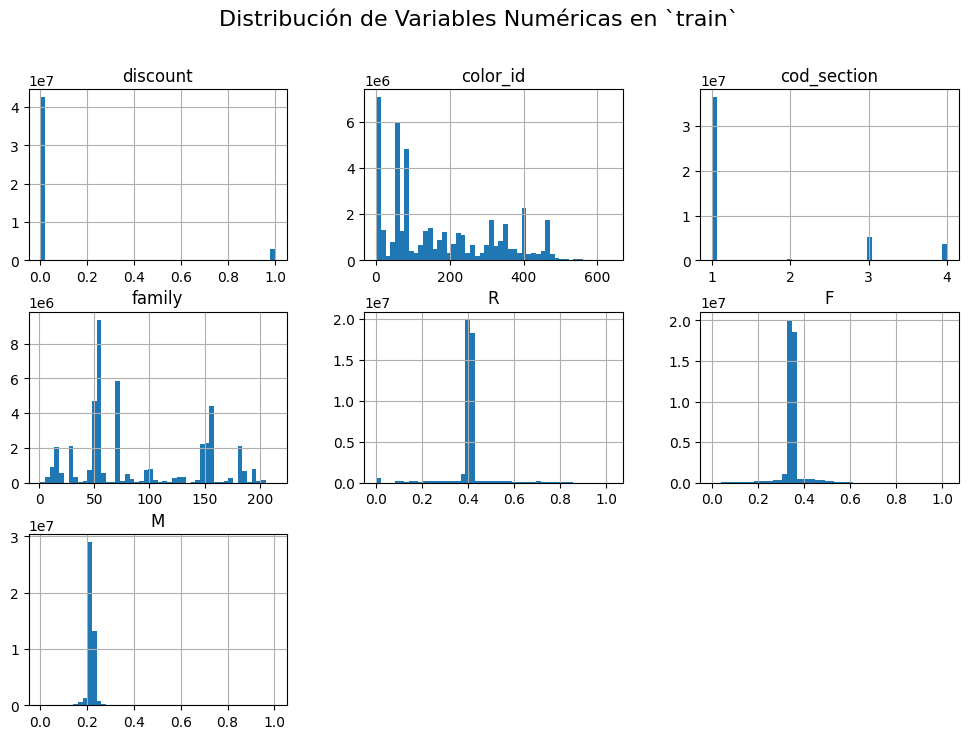

In [6]:
# 🔍 1️⃣ Revisar valores nulos
print("📌 Valores nulos en `train`:\n", train.isna().sum())
print("\n📌 Valores nulos en `test`:\n", test.isna().sum())

# 🔍 2️⃣ Visualizar distribución de variables numéricas
num_cols = ["discount", "color_id", "cod_section", "family", "R", "F", "M"]

plt.figure(figsize=(12, 8))
train[num_cols].hist(bins=50, figsize=(12, 8))
plt.suptitle("Distribución de Variables Numéricas en `train`", fontsize=16)
plt.show()

# 🔍 3️⃣ Correlación con `add_to_cart`

# train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
# train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# corr_matrix = train.drop(columns=["embedding_reduced"]).corr()

# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title("📊 Matriz de Correlación en `train`")
# plt.show()

# 🔍 4️⃣ Revisar si `embedding_reduced` está correctamente cargado
# print("📌 Tipo de datos en `embedding_reduced`:", train["embedding_reduced"].dtype)
# print("📌 Ejemplo de `embedding_reduced`:", train["embedding_reduced"].head())


In [7]:
# 💾 Guardar los datasets actualizados
train.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet")
test.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet")

print("🎯 Integración completada y datos guardados.")

🎯 Integración completada y datos guardados.


## Revisión datasets finales

In [1]:
import pandas as pd

# 📂 Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)


In [2]:
print(train.columns)
print(test.columns)
print(train.info())
print(test.info())
# print(train.describe())
# print(test.describe())

Index(['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country_x',
       'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions',
       'hour', 'is_anonymous', 'discount', 'color_id', 'cod_section', 'family',
       'embedding_reduced', 'country_y', 'R', 'F', 'M', 'is_new_user'],
      dtype='object')
Index(['session_id', 'timestamp_local', 'user_id', 'country_x', 'partnumber',
       'device_type', 'winsorized_sessions', 'hour', 'is_anonymous',
       'low_interaction', 'discount', 'color_id', 'cod_section', 'family',
       'embedding_reduced', 'country_y', 'R', 'F', 'M', 'is_new_user'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45520466 entries, 0 to 45520465
Data columns (total 21 columns):
 #   Column               Dtype         
---  ------               -----         
 0   session_id           int32         
 1   timestamp_local      datetime64[ns]
 2   add_to_cart          int8          
 3   user_id              int32  

In [5]:
# train = train.drop(columns=['embedding_mean', 'embedding_norm'])
train.columns

Index(['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country_x',
       'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions',
       'hour', 'is_anonymous', 'discount', 'color_id', 'cod_section', 'family',
       'embedding_reduced', 'country_y', 'R', 'F', 'M', 'is_new_user'],
      dtype='object')

In [4]:
# 💾 Guardar los datasets actualizados
train.to_parquet("/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet")


print("🎯 Integración completada y datos guardados.")

🎯 Integración completada y datos guardados.


## Modelo baseline - Benchmark

In [ ]:
# 1️⃣ 📂 Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
# test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train_full = pd.read_parquet(train_path)
# test = pd.read_parquet(test_path)

Total datos muestreados: 9104093
Columnas de train muestreado: ['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country_x', 'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions', 'hour', 'is_anonymous', 'discount', 'color_id', 'cod_section', 'family', 'embedding_reduced', 'country_y', 'R', 'F', 'M', 'is_new_user']
Columnas de train: ['session_id', 'timestamp_local', 'add_to_cart', 'user_id', 'country_x', 'partnumber', 'device_type', 'low_interaction', 'winsorized_sessions', 'hour', 'is_anonymous', 'discount', 'color_id', 'cod_section', 'family', 'embedding_reduced', 'country_y', 'R', 'F', 'M', 'is_new_user']
Total sesiones en train: 2036631
Total sesiones en val: 509158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's ndcg@5: 0.94565	valid_0's map@5: 0.934365

Mejor número de iteraciones: 278

Métricas en el conjunto de validación:
NDCG@5: 0.1256
Precision@5: 0.0478
Recall@5: 0.1697


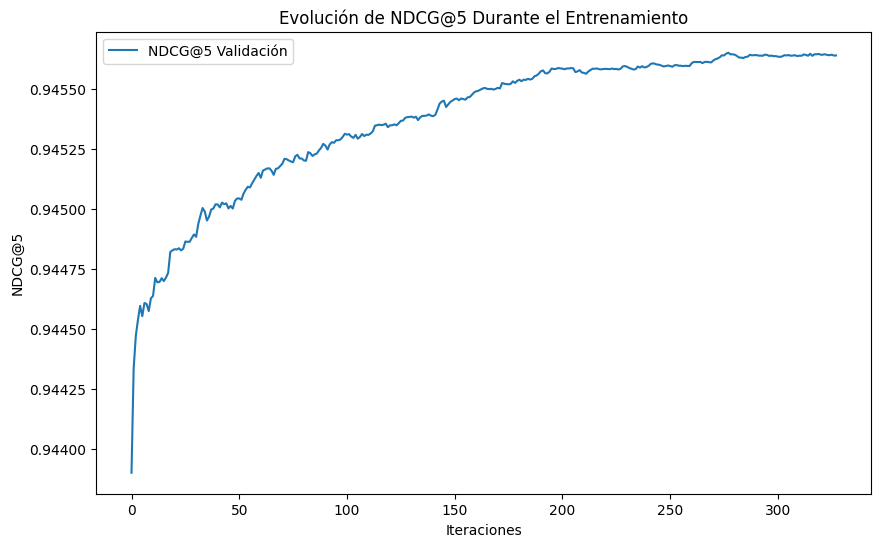

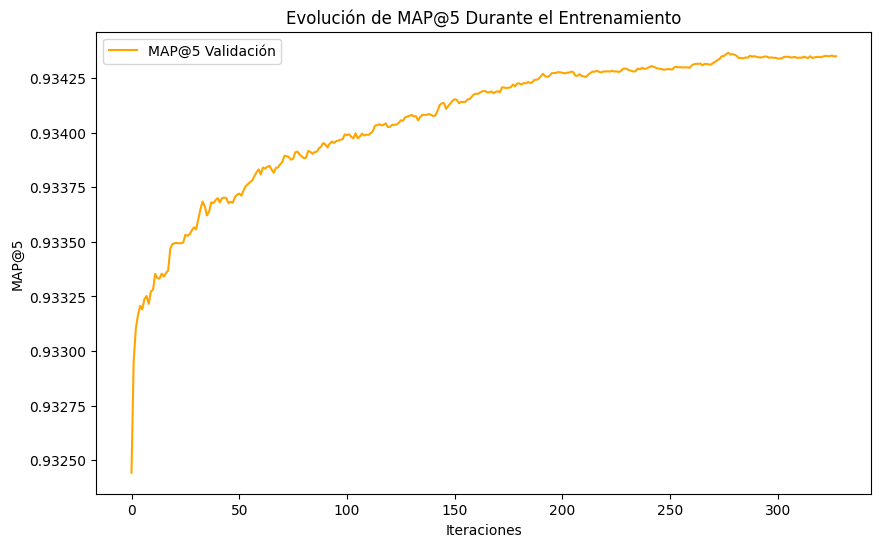

MRR@?: 0.1190


In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 📂 Carga y Preparación de Datos
# train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
# test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

# train = pd.read_parquet(train_path)
# test = pd.read_parquet(test_path)

# 2️⃣ 🔄 Muestreo aleatorio del 20% de los datos para entrenar el modelo
train = train_full.sample(frac=0.2, random_state=42)  # Selecciona el 20% de los datos

# Comprobamos que el muestreo fue exitoso
print(f"Total datos muestreados: {train.shape[0]}")
print("Columnas de train muestreado:", train.columns.tolist())

print("Columnas de train:", train.columns.tolist())
# print("Columnas de test:", test.columns.tolist())

exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 2️⃣ 🔄 División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 3️⃣ ⚙️ Configuración de Parámetros de LightGBM para Ranking
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map', 'precision'],
    'ndcg_eval_at': [5],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'device': 'cpu',  # Actualmente usando CPU
    'force_row_wise': True
}

# 4️⃣ 🚀 Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=50)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 5️⃣ 📊 Impresión de Métricas de Evaluación
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    # Solo calcular NDCG si hay más de un documento en la sesión
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)
    
    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]
    
    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)
    
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcular promedios solo si existen métricas calculadas
average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\nMétricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")



# Visualizar la evolución de NDCG@5 durante el entrenamiento
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# Visualizar la evolución de MAP@5 durante el entrenamiento
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'map@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAP@5')
    plt.title('Evolución de MAP@5 Durante el Entrenamiento')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")
    
    
def calculate_mrr(scores, true_labels):
    # Ordenar los índices de mayor a menor según las puntuaciones
    sorted_indices = np.argsort(scores)[::-1]
    # Encuentra la posición del primer elemento relevante
    for rank, idx in enumerate(sorted_indices, start=1):
        if true_labels[idx] == 1:
            return 1.0 / rank
    return 0.0

mrr_scores = []
for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue
    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]
    mrr = calculate_mrr(scores, true_labels)
    mrr_scores.append(mrr)

average_mrr = np.mean(mrr_scores) if mrr_scores else float('nan')
print(f"MRR@?: {average_mrr:.4f}")

## Feature importance - MDI - MDA

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@5: 0.802724
[20]	valid_0's ndcg@5: 0.803846
[30]	valid_0's ndcg@5: 0.804549
[40]	valid_0's ndcg@5: 0.804872
[50]	valid_0's ndcg@5: 0.804973
[60]	valid_0's ndcg@5: 0.804953
[70]	valid_0's ndcg@5: 0.80568
[80]	valid_0's ndcg@5: 0.805739
[90]	valid_0's ndcg@5: 0.805941
[100]	valid_0's ndcg@5: 0.805995
[110]	valid_0's ndcg@5: 0.806154
[120]	valid_0's ndcg@5: 0.80622
[130]	valid_0's ndcg@5: 0.806056
[140]	valid_0's ndcg@5: 0.805856
[150]	valid_0's ndcg@5: 0.80606
[160]	valid_0's ndcg@5: 0.806392
[170]	valid_0's ndcg@5: 0.806302
[180]	valid_0's ndcg@5: 0.806328
[190]	valid_0's ndcg@5: 0.806436
[200]	valid_0's ndcg@5: 0.806263
[210]	valid_0's ndcg@5: 0.806484
[220]	valid_0's ndcg@5: 0.806443
[230]	valid_0's ndcg@5: 0.806471
[240]	valid_0's ndcg@5: 0.806546
[250]	valid_0's ndcg@5: 0.806412
[260]	valid_0's ndcg@5: 0.806536
[270]	valid_0's ndcg@5: 0.806468
[280]	valid_0's ndcg@5: 0.80659
[290]	valid_0's ndcg@5: 0.80

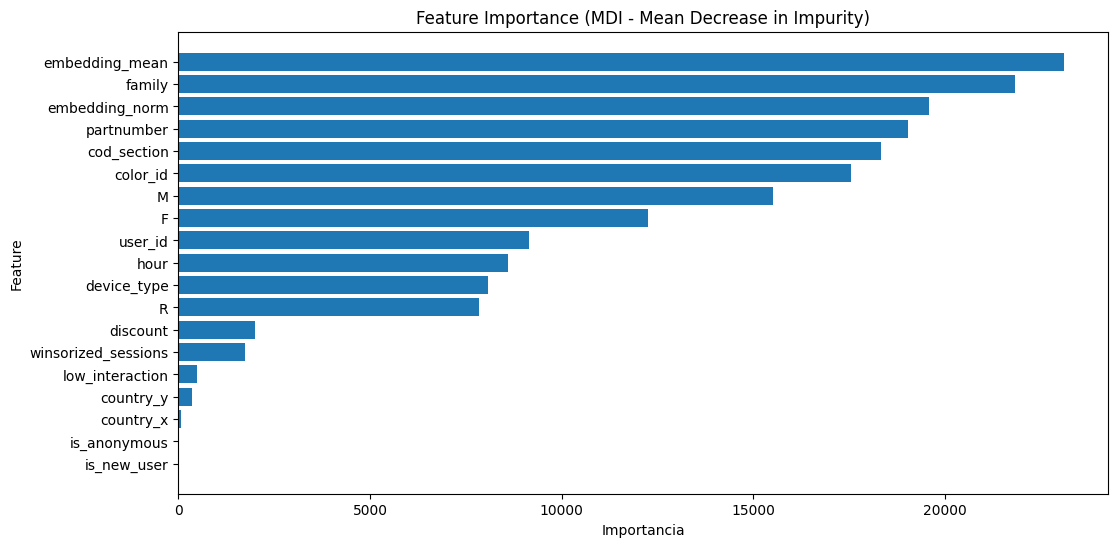


🔹 Top 10 Features (MDI - Impurity-based):
           Feature    Importance
17  embedding_mean  23103.472578
11          family  21829.309561
18  embedding_norm  19581.532914
2       partnumber  19040.606046
10     cod_section  18314.067126
9         color_id  17552.395980
15               M  15509.177888
14               F  12257.020144
0          user_id   9142.281254
6             hour   8599.026625


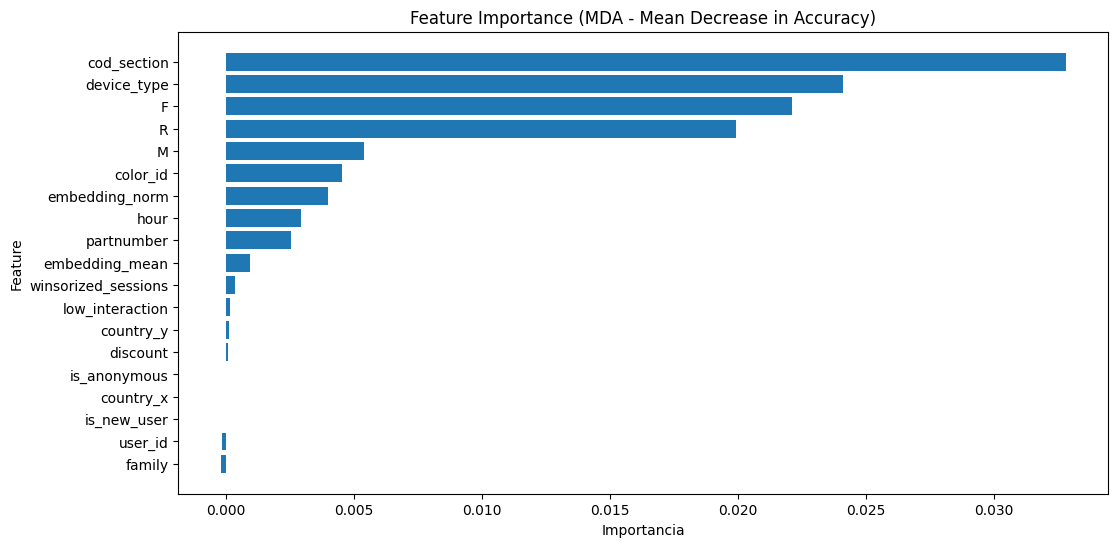


🔹 Top 10 Features (MDA - Accuracy-based):
           Feature  Importance
10     cod_section    0.032811
3      device_type    0.024093
14               F    0.022116
13               R    0.019928
15               M    0.005418
9         color_id    0.004551
18  embedding_norm    0.003994
6             hour    0.002955
2       partnumber    0.002538
17  embedding_mean    0.000941


In [22]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRanker
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# 📂 1️⃣ Cargar datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
# test = pd.read_parquet(test_path)

# 🔍 2️⃣ Extraer la hora de `timestamp_local`
for df in [train, test]:
    df["hour"] = df["timestamp_local"].dt.hour  # Solo nos quedamos con la hora

# 🔍 3️⃣ Extraer estadísticas de `embedding_reduced`
for df in [train, test]:
    df["embedding_mean"] = df["embedding_reduced"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else np.nan)
    df["embedding_norm"] = df["embedding_reduced"].apply(lambda x: np.linalg.norm(x) if isinstance(x, np.ndarray) else np.nan)

# 🚀 4️⃣ Definir features **(Excluyendo `add_to_cart`)**
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']  # Excluimos la variable objetivo
features_cols = [col for col in train.columns if col not in exclude_cols]

# 🔄 5️⃣ Dividir datos en entrenamiento y validación por sesión
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# ⚙️ 6️⃣ Configurar modelo LGBMRanker
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=1000,
    importance_type="gain",
)

# 🚀 7️⃣ Entrenar modelo con CALLBACKS
callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=10)
]

lgbm_ranker.fit(
    X_train,
    y_train,
    group=group_train,
    eval_set=[(X_val, y_val)],
    eval_group=[group_val],
    eval_at=[5],
    callbacks=callbacks
)

# 📊 8️⃣ Calcular Feature Importance (MDI)
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 🔍 Visualizar Feature Importance (MDI)
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Feature Importance (MDI - Mean Decrease in Impurity)')
plt.gca().invert_yaxis()
plt.show()

print("\n🔹 Top 10 Features (MDI - Impurity-based):")
print(feature_importances.head(10))

# 📌 9️⃣ Calcular Feature Importance (MDA - Mean Decrease in Accuracy)
perm_importance = permutation_importance(
    lgbm_ranker, X_val, y_val, scoring="r2", n_repeats=5, random_state=42
)

# Convertir a DataFrame
mda_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# 🔍 Visualizar Feature Importance (MDA)
plt.figure(figsize=(12, 6))
plt.barh(mda_importance['Feature'], mda_importance['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('Feature Importance (MDA - Mean Decrease in Accuracy)')
plt.gca().invert_yaxis()
plt.show()

print("\n🔹 Top 10 Features (MDA - Accuracy-based):")
print(mda_importance.head(10))


### 📊 **Análisis de Feature Importance (MDI vs. MDA)**  

#### 🔍 **Comparación de las Features Más Importantes**
| Feature            | MDI (Impurity) Rank | MDA (Accuracy) Rank |
|-------------------|------------------|------------------|
| **embedding_mean**  | **1°** (más importante) | 10° |
| **embedding_norm**  | **3°** | **7°** |
| **family**          | **2°** | **Fuera del top 10** |
| **cod_section**     | **5°** | **1°** (más importante) |
| **device_type**     | 11° | **2°** |
| **hour**            | **10°** | **8°** |
| **partnumber**      | **4°** | **9°** |
| **R, F, M (RFM)**  | **Muy relevantes** en ambos |

#### **📌 Interpretación**
1️⃣ **Los embeddings (`embedding_mean` y `embedding_norm`) son cruciales según MDI**, pero **poco importantes según MDA**.  
   - ⚠ **Esto sugiere que los embeddings están correlacionados con otras variables**, y no aportan mucho una vez que esas variables están presentes.  
   - 🔥 **Prueba**: Entrenar sin embeddings y ver si NDCG@5 cambia significativamente.  

2️⃣ **`cod_section` y `device_type` son las más importantes según MDA** (impacto directo en precisión).  
   - 📌 Esto indica que **la sección del producto y el dispositivo afectan fuertemente la predicción**.  
   - 🔥 **Prueba**: Crear nuevas features basadas en `cod_section` y `device_type`.  

3️⃣ **RFM (`R`, `F`, `M`) son relevantes en ambos métodos**, indicando que **el comportamiento histórico del usuario importa**.  
   - 📌 **Fortalece la idea de usar modelos basados en historial** (ej. **SASRec o LightGBM con features temporales**).  

4️⃣ **La hora (`hour`) aparece en ambas métricas**, aunque no en los primeros lugares.  
   - 📌 Esto sugiere que **el momento del día influye en la decisión de compra**, pero no de manera dominante.  
   - 🔥 **Prueba**: Convertir `hour` en categorías (`morning`, `afternoon`, `night`) y evaluar impacto.  



## Modelo con ajustes - Incluimos embeddings_norm + embeddings_mean

- La versión sin embeddings tuvo NDCG@5 ≈ 0.8049 y MAP@5 ≈ 0.7804.
- La versión con embeddings logra NDCG@5 ≈ 0.8066 y MAP@5 ≈ 0.7821, lo que indica una mejora ligera pero consistente.

Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@5: 0.802724	valid_0's map@5: 0.778586
[20]	valid_0's ndcg@5: 0.803846	valid_0's map@5: 0.779615
[30]	valid_0's ndcg@5: 0.804549	valid_0's map@5: 0.780262
[40]	valid_0's ndcg@5: 0.804872	valid_0's map@5: 0.78061
[50]	valid_0's ndcg@5: 0.804973	valid_0's map@5: 0.780655
[60]	valid_0's ndcg@5: 0.804953	valid_0's map@5: 0.780633
[70]	valid_0's ndcg@5: 0.80568	valid_0's map@5: 0.781402
[80]	valid_0's ndcg@5: 0.805739	valid_0's map@5: 0.781433
[90]	valid_0's ndcg@5: 0.805941	valid_0's map@5: 0.781578
[100]	valid_0's ndcg@5: 0.805995	valid_0's map@5: 0.781613
[110]	valid_0's ndcg@5: 0.806154	valid_0's map@5: 0.78176
[120]	valid_0's ndcg@5: 0.80622	valid_0's map@5: 0.781777
[130]	valid_0's ndcg@5: 0.806056	valid_0's map@5: 0.781669
[140]	valid_0's ndcg@5: 0.805856	valid_0's map@5: 0.781428
[150]	valid_0's ndcg@5: 0.80606	valid_0's map@5: 0.781675
[160]	

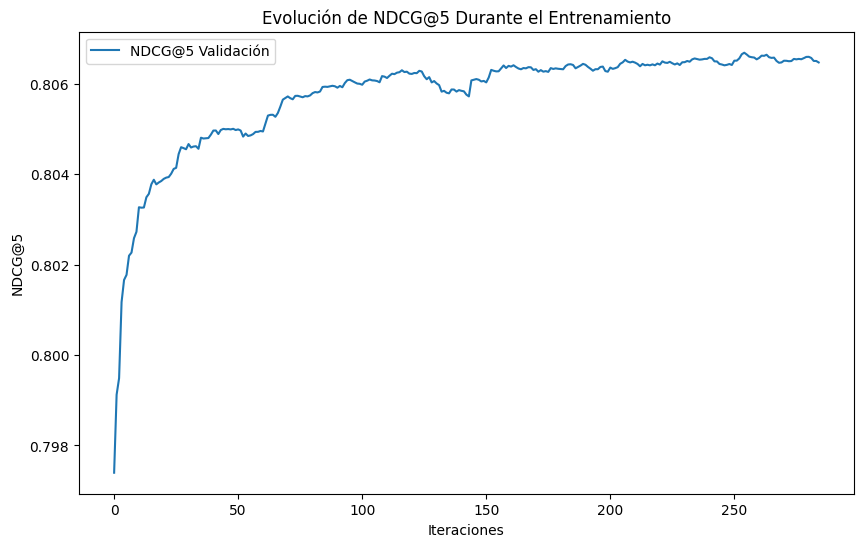

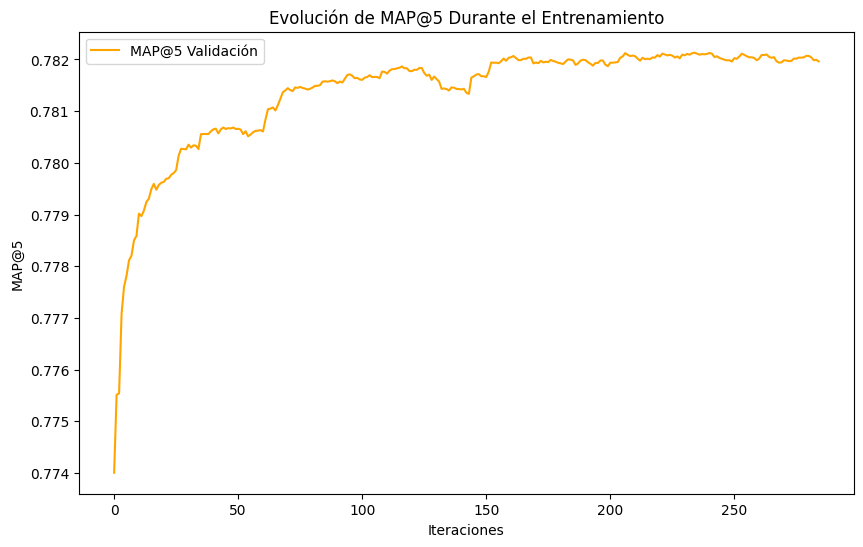

In [28]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 📂 Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 📌 Calcular embeddings agregados (solo si no están en el dataset)
if "embedding_mean" not in train.columns:
    train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
    train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# Eliminar embeddings originales para evitar dimensiones altas
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 2️⃣ 🔄 División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 3️⃣ ⚙️ Configuración de Parámetros de LightGBM para Ranking
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map', 'precision'],
    'ndcg_eval_at': [5],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 4️⃣ 🚀 Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

evals_result = {}  # 🔹 Diccionario para almacenar la evolución de métricas

callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=True),
    lgb.log_evaluation(period=10),
    lgb.record_evaluation(evals_result)  # 🔹 Capturar métricas en evals_result
]

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks
)

# 5️⃣ 📊 Evaluación del Modelo
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\n🔍 Métricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

# 📊 7️⃣ Visualizar la evolución de NDCG@5 durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
plt.xlabel('Iteraciones')
plt.ylabel('NDCG@5')
plt.title('Evolución de NDCG@5 Durante el Entrenamiento')
plt.legend()
plt.show()

# 📊 8️⃣ Visualizar la evolución de MAP@5 durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
plt.xlabel('Iteraciones')
plt.ylabel('MAP@5')
plt.title('Evolución de MAP@5 Durante el Entrenamiento')
plt.legend()
plt.show()


## Modelo con ajustes - Incluimos embeddings_norm + embeddings_mean + timestamp (parte del día)

Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's ndcg@5: 0.806556	valid_0's map@5: 0.78213

Mejor número de iteraciones: 235

🔍 Métricas en el conjunto de validación:
NDCG@5: 0.1559
Precision@5: 0.0817
Recall@5: 0.2002


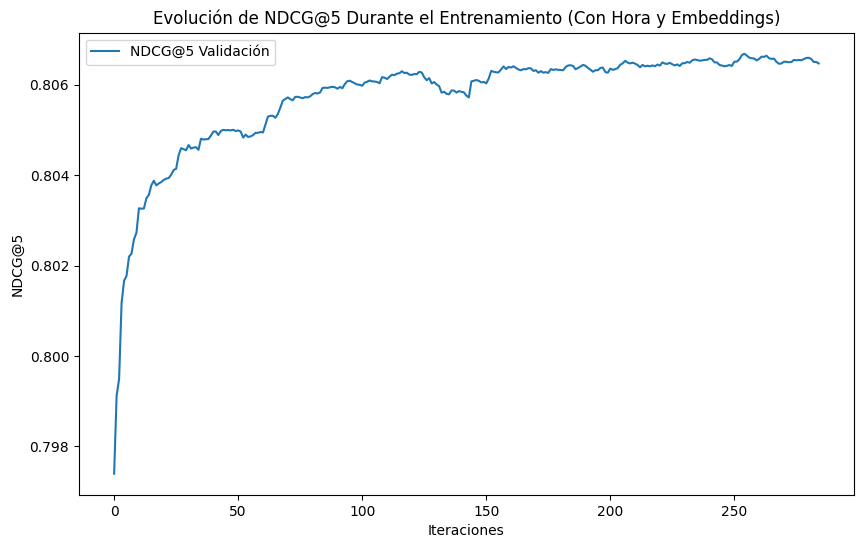

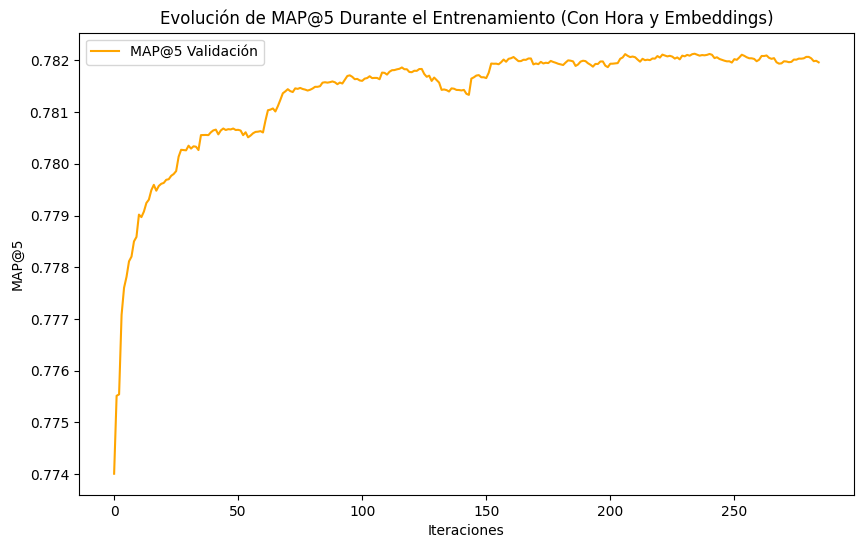

In [31]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# ✨ Extraer la hora del timestamp
train["hour"] = pd.to_datetime(train["timestamp_local"]).dt.hour
# test["hour"] = pd.to_datetime(test["timestamp_local"]).dt.hour

# ✨ Calcular `embedding_mean` y `embedding_norm`
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x))
# test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 📌 Eliminar columnas irrelevantes
exclude_cols = ["session_id", "timestamp_local", "embedding_reduced"]
features_cols = [col for col in train.columns if col not in exclude_cols + ["add_to_cart"]]

# 🔄 2️⃣ División de Datos en Entrenamiento y Validación
unique_sessions = train["session_id"].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train["session_id"].isin(train_sessions)]
val_df = train[train["session_id"].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df["add_to_cart"]
X_val = val_df[features_cols]
y_val = val_df["add_to_cart"]

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby("session_id").size().tolist()
group_val = val_df.groupby("session_id").size().tolist()

# ⚙️ 3️⃣ Configuración de Parámetros de LightGBM para Ranking
params = {
    "objective": "lambdarank",
    "metric": ["ndcg", "map"],
    "ndcg_eval_at": [5],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1,
    "device": "cpu",  # Actualmente usando CPU
    "force_row_wise": True
}

# 🚀 4️⃣ Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 📊 5️⃣ Impresión de Métricas de Evaluación
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby("session_id"):
    if len(group) < 2:
        continue

    true_labels = group["add_to_cart"].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

# 📌 Calcular promedios
average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float("nan")
average_precision = np.mean(precision_scores) if precision_scores else float("nan")
average_recall = np.mean(recall_scores) if recall_scores else float("nan")

print("\n🔍 Métricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

# 📊 6️⃣ Visualización de la evolución de NDCG@5
plt.figure(figsize=(10, 6))
if "valid_0" in evals_result and "ndcg@5" in evals_result["valid_0"]:
    plt.plot(evals_result["valid_0"]["ndcg@5"], label="NDCG@5 Validación")
    plt.xlabel("Iteraciones")
    plt.ylabel("NDCG@5")
    plt.title("Evolución de NDCG@5 Durante el Entrenamiento (Con Hora y Embeddings)")
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# 📊 7️⃣ Visualización de la evolución de MAP@5
plt.figure(figsize=(10, 6))
if "valid_0" in evals_result and "map@5" in evals_result["valid_0"]:
    plt.plot(evals_result["valid_0"]["map@5"], label="MAP@5 Validación", color="orange")
    plt.xlabel("Iteraciones")
    plt.ylabel("MAP@5")
    plt.title("Evolución de MAP@5 Durante el Entrenamiento (Con Hora y Embeddings)")
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")


## Modelo con embeddings(mean + norm) - Balanceo de clases (scale_pos_weight)


Sin mejorar aparentes. Lambdarank ya tiende a manejar bien el desbalanceo

In [ ]:
import pandas as pd

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)


add_to_cart
0    0.929612
1    0.070388
Name: proportion, dtype: float64


🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's ndcg@5: 0.806556	valid_0's map@5: 0.78213

Mejor número de iteraciones: 235

Métricas en el conjunto de validación:
NDCG@5: 0.1559
Precision@5: 0.0817
Recall@5: 0.2002


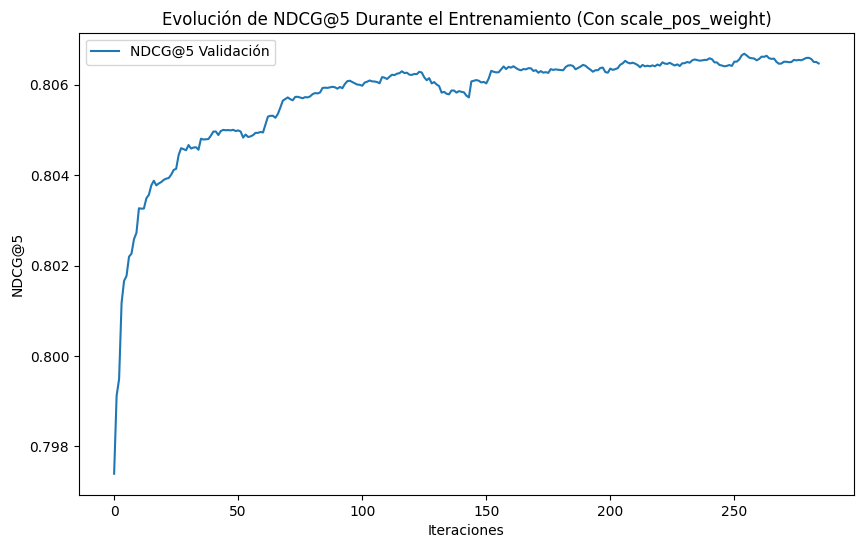

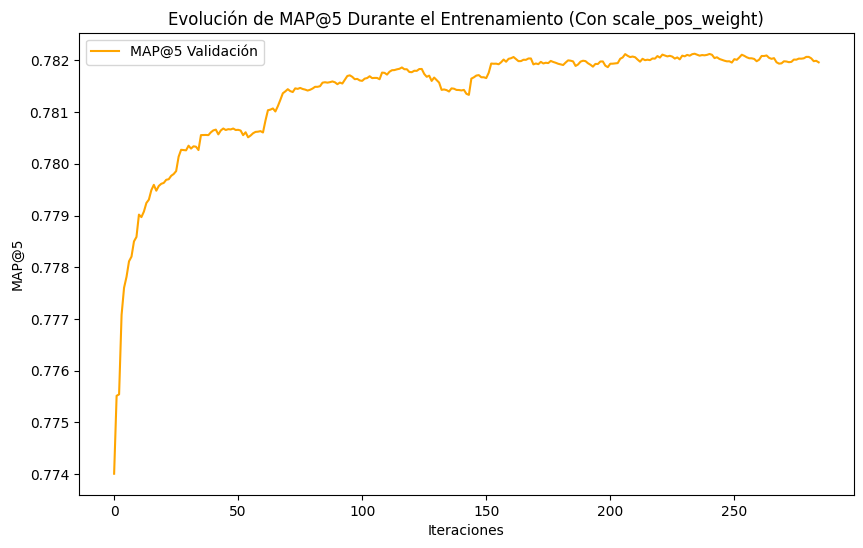

In [10]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 📂 Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# Calcular pesos para balanceo de clases
class_counts = train["add_to_cart"].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"🔍 scale_pos_weight: {scale_pos_weight:.4f}")

# Crear nuevas características
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))
test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x))
test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# Seleccionar columnas de características
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 2️⃣ 🔄 División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 3️⃣ ⚙️ Configuración de Parámetros de LightGBM con `scale_pos_weight`
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [5],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo
    'verbose': -1,
    'device': 'cpu',  # Actualmente usando CPU
    'force_row_wise': True
}

# 4️⃣ 🚀 Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=50)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 5️⃣ 📊 Impresión de Métricas de Evaluación
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\nMétricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

# 📊 Visualizar la evolución de NDCG@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento (Con scale_pos_weight)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# 📊 Visualizar la evolución de MAP@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'map@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAP@5')
    plt.title('Evolución de MAP@5 Durante el Entrenamiento (Con scale_pos_weight)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")


## Modelo aplicando Cross-Validation (CV)

Enfoque
- 5 folds estratificados por add_to_cart.
- Se mantiene agrupamiento por sesión (session_id) para evitar fugas de información.
- Se obtiene la media y desviación estándar de las métricas en cada fold.
- Se usa early stopping para optimizar el número de iteraciones.


🔄 Fold 1/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's ndcg@5: 0.805424	valid_0's map@5: 0.781017

🔄 Fold 2/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's ndcg@5: 0.803156	valid_0's map@5: 0.778662

🔄 Fold 3/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's ndcg@5: 0.802646	valid_0's map@5: 0.778236

🔄 Fold 4/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's ndcg@5: 0.804032	valid_0's map@5: 0.779504

🔄 Fold 5/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's ndcg@5: 0.804432	valid_0's map@5: 0.779987

📌 Resultados Finales de Cross-Validation:
NDCG@5: 0.1526 ± 0.0004
Precision@5: 0.0800 ± 0.0002
Recall@5: 0.1966 ± 0.0008


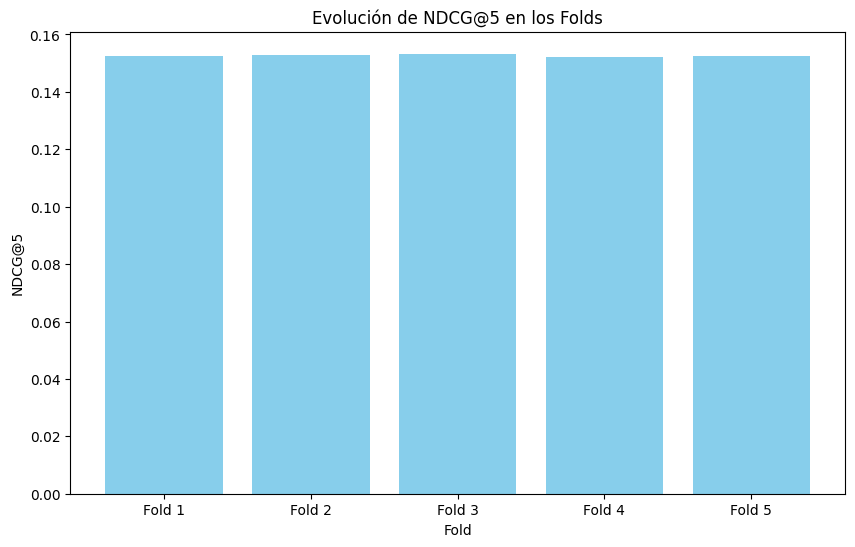

In [11]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import ndcg_score

# 1️⃣ 📂 Cargar Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 2️⃣ 🔄 Preparar Features y Target
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

X = train[features_cols]
y = train['add_to_cart']
groups = train['session_id']

# 3️⃣ ⚙️ Configuración de Parámetros de LightGBM
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [5],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 4️⃣ 📌 Configuración de Cross-Validation
n_splits = 5
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

ndcg_scores = []
precision_scores = []
recall_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
    print(f"\n🔄 Fold {fold+1}/{n_splits}...")

    # Dividir datos en entrenamiento y validación
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Agrupar por sesión
    group_train = train.iloc[train_idx].groupby('session_id').size().tolist()
    group_val = train.iloc[val_idx].groupby('session_id').size().tolist()

    # Crear Datasets de LightGBM
    train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

    # Entrenar Modelo
    evals_result = {}
    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=1000,
        valid_sets=[val_dataset],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.record_evaluation(evals_result)]
    )

    # Obtener predicciones
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Calcular métricas por sesión
    ndcg_fold, precision_fold, recall_fold = [], [], []

    val_df_reset = train.iloc[val_idx].reset_index(drop=True)
    for session_id, group in val_df_reset.groupby('session_id'):
        if len(group) < 2:
            continue

        true_labels = group['add_to_cart'].values
        indices = group.index
        scores = y_val_pred[indices]

        ndcg = ndcg_score([true_labels], [scores], k=5)
        ndcg_fold.append(ndcg)

        top_k_indices = np.argsort(scores)[-5:][::-1]
        top_k_true = true_labels[top_k_indices]

        precision = np.sum(top_k_true) / 5.0
        recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

        precision_fold.append(precision)
        recall_fold.append(recall)

    # Almacenar métricas de este fold
    ndcg_scores.append(np.mean(ndcg_fold))
    precision_scores.append(np.mean(precision_fold))
    recall_scores.append(np.mean(recall_fold))

# 5️⃣ 📊 Mostrar Resultados Finales de CV
print("\n📌 Resultados Finales de Cross-Validation:")
print(f"NDCG@5: {np.mean(ndcg_scores):.4f} ± {np.std(ndcg_scores):.4f}")
print(f"Precision@5: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall@5: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")

# 6️⃣ 📈 Visualizar Evolución de NDCG@5 en los Folds
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_splits + 1), ndcg_scores, tick_label=[f"Fold {i+1}" for i in range(n_splits)], color='skyblue')
plt.xlabel("Fold")
plt.ylabel("NDCG@5")
plt.title("Evolución de NDCG@5 en los Folds")
plt.show()


Modelo estable → No hay grandes variaciones entre los folds.
- ✅ Generalización buena → Las métricas son consistentes.
- ✅ Posible optimización: Reducir early_stopping_rounds para mejorar velocidad.

## Modelo aplicando CV + Balanceo de clases (scale_pos_weight) + embedding_norm + mean + Predictions_test

🔍 scale_pos_weight: 13.2069

🔄 Fold 1/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's ndcg@1: 0.758187	valid_0's ndcg@3: 0.784549	valid_0's ndcg@5: 0.801878	valid_0's map@1: 0.758187	valid_0's map@3: 0.768312	valid_0's map@5: 0.777426

🔄 Fold 2/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	valid_0's ndcg@1: 0.758552	valid_0's ndcg@3: 0.784208	valid_0's ndcg@5: 0.801481	valid_0's map@1: 0.758552	valid_0's map@3: 0.767839	valid_0's map@5: 0.776911

🔄 Fold 3/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's ndcg@1: 0.761607	valid_0's ndcg@3: 0.787946	valid_0's ndcg@5: 0.80485	valid_0's map@1: 0.761607	valid_0's map@3: 0.771673	valid_0's map@5: 0.780551

🔄 Fold 4/5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[180]	valid_0's ndcg@1: 0.763488	vali

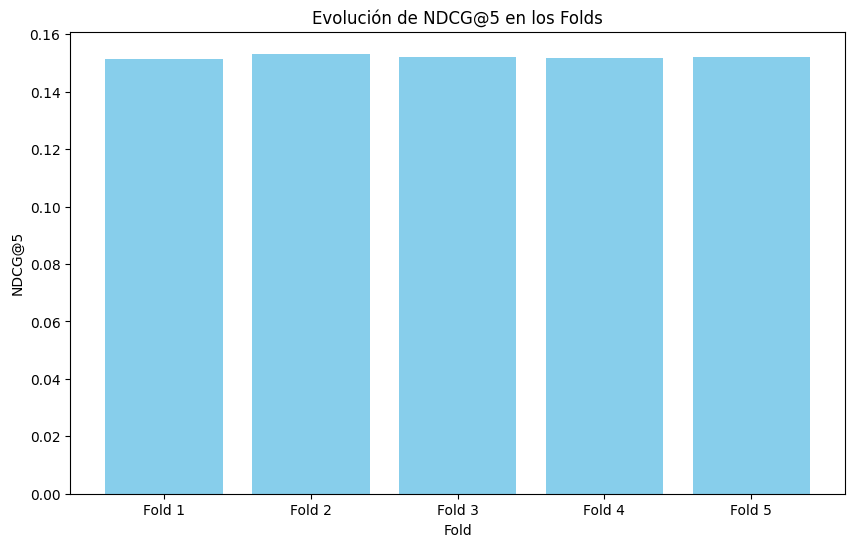

In [17]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt
import json

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 🔢 Calcular embeddings_mean y embeddings_norm en test
test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x))
test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Seleccionar Features (excluir columnas irrelevantes)
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# 🔄 Balanceo de Clases con scale_pos_weight
pos_weight = train["add_to_cart"].value_counts()[0] / train["add_to_cart"].value_counts()[1]
print(f"🔍 scale_pos_weight: {pos_weight:.4f}")

# ⚙️ 2️⃣ Configuración de Cross-Validation
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

ndcg_scores, precision_scores, recall_scores = [], [], []
best_ndcg = -np.inf
best_model = None

for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["add_to_cart"], groups=train["session_id"])):
    print(f"\n🔄 Fold {fold + 1}/{n_splits}...")

    # División de datos
    train_df, val_df = train.iloc[train_idx], train.iloc[val_idx]

    # Restablecer índices en validación
    X_train, y_train = train_df[features_cols], train_df["add_to_cart"]
    X_val, y_val = val_df[features_cols], val_df["add_to_cart"]
    X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
    val_df_reset = val_df.reset_index(drop=True)

    group_train = train_df.groupby("session_id").size().tolist()
    group_val = val_df.groupby("session_id").size().tolist()

    # 📊 3️⃣ Configuración de Parámetros de LightGBM
    params = {
        'objective': 'lambdarank',
        'metric': ['ndcg', 'map'],
        'ndcg_eval_at': [1, 3, 5],
        'boosting_type': 'gbdt',
        'learning_rate': 0.03,
        'num_leaves': 40,
        'verbose': -1,
        'device': 'cpu',
        'force_row_wise': True,
        'scale_pos_weight': pos_weight,
        'min_data_in_leaf': 15,
    }

    # 🚀 4️⃣ Entrenamiento con Early Stopping y Callbacks
    train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

    callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]
    evals_result = {}

    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=1000,
        valid_sets=[val_dataset],
        callbacks=callbacks + [lgb.record_evaluation(evals_result)]
    )

    # 📌 5️⃣ Evaluación del Modelo
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

    ndcg_fold = []
    for session_id, group in val_df_reset.groupby("session_id"):
        if len(group) < 2:
            continue
        true_labels = group["add_to_cart"].values
        indices = group.index
        scores = y_val_pred[indices]
        ndcg_fold.append(ndcg_score([true_labels], [scores], k=5))

    avg_ndcg = np.mean(ndcg_fold)
    ndcg_scores.append(avg_ndcg)

    # 🚀 Guardar el modelo con el mejor NDCG@5
    if avg_ndcg > best_ndcg:
        best_ndcg = avg_ndcg
        best_model = model

print(f"\n✅ Mejor modelo guardado con NDCG@5 = {best_ndcg:.4f}")

# 📊 6️⃣ Resultados Finales de Cross-Validation
print("\n📌 Resultados Finales de Cross-Validation:")
print(f"NDCG@5: {np.mean(ndcg_scores):.4f} ± {np.std(ndcg_scores):.4f}")

# 📊 7️⃣ Visualizar la evolución de NDCG@5 en los folds
plt.figure(figsize=(10, 6))
plt.bar([f"Fold {i+1}" for i in range(n_splits)], ndcg_scores, color="skyblue")
plt.xlabel("Fold")
plt.ylabel("NDCG@5")
plt.title("Evolución de NDCG@5 en los Folds")
plt.show()


#### Prueba predicciones

In [22]:
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics.pairwise import cosine_similarity

# 📂 1️⃣ Cargar datasets
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
# train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"

test = pd.read_parquet(test_path)
# train = pd.read_parquet(train_path)

# 🔢 2️⃣ Extraer embeddings como matriz NumPy
product_embeddings = np.vstack(test["embedding_reduced"].values)  
product_ids = test["partnumber"].values  

# 📊 3️⃣ Obtener productos más populares en train (para respaldo)
popular_products = (
    train.groupby("partnumber")["add_to_cart"]
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

# 🔄 4️⃣ Seleccionar Features para el Modelo
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in test.columns if col not in exclude_cols]

# 📌 5️⃣ Aplicar el modelo a los datos de test
test_features = test[features_cols]
test["predicted_score"] = best_model.predict(test_features, num_iteration=best_model.best_iteration)

# 🔍 6️⃣ Precomputar la Matriz de Similitud de Embeddings
embedding_similarity = cosine_similarity(product_embeddings)

# 📌 7️⃣ Generar el top 5 de productos recomendados por sesión
recommendations = {}

for session_id, group in test.groupby("session_id"):
    # 🔥 Obtener los 5 productos con mayor score (convertimos a `int`)
    sorted_indices = np.argsort(group["predicted_score"].values)[-5:][::-1]
    top_5_products = group.iloc[sorted_indices]["partnumber"].astype(int).tolist()  # Conversión a `int`

    # 🧐 Si faltan productos, buscar por embeddings similares
    if len(top_5_products) < 5:
        remaining = 5 - len(top_5_products)

        # Obtener los índices de los productos actuales en la matriz
        top_product_indices = [np.where(product_ids == p)[0][0] for p in top_5_products if p in product_ids]

        if top_product_indices:
            # Sumar las filas de similitud y obtener productos más similares
            similar_scores = embedding_similarity[top_product_indices].sum(axis=0)
            similar_products = product_ids[np.argsort(similar_scores)[-remaining:][::-1]]

            # Evitar repeticiones y convertir a `int`
            similar_products = [int(p) for p in similar_products if p not in top_5_products]
            top_5_products += similar_products

    # 🏆 Si aún faltan, completar con productos populares
    if len(top_5_products) < 5:
        top_5_products += [int(p) for p in popular_products if p not in top_5_products][: (5 - len(top_5_products))]

    # Asegurar que cada sesión tenga exactamente 5 recomendaciones
    recommendations[int(session_id)] = top_5_products[:5]  # Conversión `session_id` a `int`

# 📂 8️⃣ Guardar en formato JSON
output = {"target": recommendations}

with open("predictions_3_test.json", "w") as f:
    json.dump(output, f, indent=4)

print("✅ Archivo predictions_3_test.json generado correctamente.")


✅ Archivo predictions_3_test.json generado correctamente.


## Modelo GridSearch con CV

```python
{
  'learning_rate': 0.01,
  'min_data_in_leaf': 15,
  'num_leaves': 50,
  'scale_pos_weight': 15,
  'objective': 'lambdarank',
  'metric': ['ndcg', 'map'],
  'ndcg_eval_at': [1, 3, 5],
  'boosting_type': 'gbdt',
  'verbose': -1,
  'device': 'cpu',
  'force_row_wise': True
}
```

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid, GroupKFold
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt
import json
import time

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🔢 Calcular embeddings_mean y embeddings_norm en train
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Seleccionar Features (excluir columnas irrelevantes)
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# 🔄 Balanceo de Clases con scale_pos_weight
pos_weight = train["add_to_cart"].value_counts()[0] / train["add_to_cart"].value_counts()[1]
print(f"🔍 scale_pos_weight: {pos_weight:.4f}")

# ⚙️ 2️⃣ Definir GridSearch Hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03, 0.05],
    'num_leaves': [20, 30, 40, 50],
    'min_data_in_leaf': [10, 15, 20],
    'scale_pos_weight': [10, 13, 15]
}

# ⚙️ 3️⃣ Configuración de Cross-Validation
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# 📌 Variables para seguimiento del mejor modelo
best_ndcg = -np.inf
best_params = None
best_model = None

# 📜 Guardar log de ejecución
log_file = "gridsearch_results.txt"
with open(log_file, "w") as log:
    log.write("🚀 GridSearch Execution Log\n")
    log.write(f"Total combinaciones: {len(list(ParameterGrid(param_grid)))}\n\n")

# 🔄 4️⃣ Ejecutar GridSearch
for params in ParameterGrid(param_grid):
    params.update({
        'objective': 'lambdarank',
        'metric': ['ndcg', 'map'],
        'ndcg_eval_at': [1, 3, 5],
        'boosting_type': 'gbdt',
        'verbose': -1,
        'device': 'cpu',
        'force_row_wise': True
    })

    print(f"\n🚀 Probando configuración: {params}")
    with open(log_file, "a") as log:
        log.write(f"\n🔧 Parámetros: {params}\n")

    start_time = time.time()
    ndcg_scores = []

    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["add_to_cart"], groups=train["session_id"])):
        print(f"\n🔄 Fold {fold + 1}/{n_splits}...")

        # División de datos
        train_df, val_df = train.iloc[train_idx], train.iloc[val_idx]

        # Restablecer índices en validación
        X_train, y_train = train_df[features_cols], train_df["add_to_cart"]
        X_val, y_val = val_df[features_cols], val_df["add_to_cart"]
        X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
        val_df_reset = val_df.reset_index(drop=True)

        group_train = train_df.groupby("session_id").size().tolist()
        group_val = val_df.groupby("session_id").size().tolist()

        # 📊 5️⃣ Entrenamiento con Early Stopping y Callbacks
        train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
        val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

        callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
        evals_result = {}

        model = lgb.train(
            params,
            train_dataset,
            num_boost_round=1000,
            valid_sets=[val_dataset],
            callbacks=callbacks + [lgb.record_evaluation(evals_result)]
        )

        # 📌 6️⃣ Evaluación del Modelo
        y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

        ndcg_fold = []
        for session_id, group in val_df_reset.groupby("session_id"):
            if len(group) < 2:
                continue
            true_labels = group["add_to_cart"].values
            indices = group.index
            scores = y_val_pred[indices]
            ndcg_fold.append(ndcg_score([true_labels], [scores], k=5))

        avg_ndcg = np.mean(ndcg_fold)
        ndcg_scores.append(avg_ndcg)

    # 📌 Resultados del GridSearch para esta combinación
    mean_ndcg = np.mean(ndcg_scores)
    std_ndcg = np.std(ndcg_scores)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"\n📌 Resultados: NDCG@5 = {mean_ndcg:.4f} ± {std_ndcg:.4f} (Tiempo: {elapsed_time:.2f}s)")
    with open(log_file, "a") as log:
        log.write(f"NDCG@5 = {mean_ndcg:.4f} ± {std_ndcg:.4f} (Tiempo: {elapsed_time:.2f}s)\n")

    # 🚀 Guardar el mejor modelo
    if mean_ndcg > best_ndcg:
        best_ndcg = mean_ndcg
        best_params = params.copy()
        best_model = model

print(f"\n✅ Mejor modelo encontrado con NDCG@5 = {best_ndcg:.4f}")
print(f"📌 Parámetros óptimos: {best_params}")

# 📂 Guardar el mejor modelo
best_model.save_model("best_model_lgbm.txt")

# 📂 Guardar los mejores parámetros
with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

print("✅ Mejor modelo y parámetros guardados correctamente.")

# 📊 7️⃣ Visualizar la evolución de NDCG@5 en los folds
plt.figure(figsize=(10, 6))
plt.bar([f"Fold {i+1}" for i in range(n_splits)], ndcg_scores, color="skyblue")
plt.xlabel("Fold")
plt.ylabel("NDCG@5")
plt.title("Evolución de NDCG@5 en los Folds")
plt.show()


🔍 scale_pos_weight: 13.2069

🚀 Probando configuración: {'learning_rate': 0.01, 'min_data_in_leaf': 10, 'num_leaves': 20, 'scale_pos_weight': 10, 'objective': 'lambdarank', 'metric': ['ndcg', 'map'], 'ndcg_eval_at': [1, 3, 5], 'boosting_type': 'gbdt', 'verbose': -1, 'device': 'cpu', 'force_row_wise': True}

🔄 Fold 1/5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's ndcg@1: 0.760562	valid_0's ndcg@3: 0.78677	valid_0's ndcg@5: 0.803591	valid_0's map@1: 0.760562	valid_0's map@3: 0.770371	valid_0's map@5: 0.779166

🔄 Fold 2/5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	valid_0's ndcg@1: 0.75973	valid_0's ndcg@3: 0.786055	valid_0's ndcg@5: 0.802661	valid_0's map@1: 0.75973	valid_0's map@3: 0.769673	valid_0's map@5: 0.778279

🔄 Fold 3/5...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	valid_0's ndcg@1: 0.7640

KeyboardInterrupt: 

### Modelo aplicando los params obtenidos con GridSearch

🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[141]	valid_0's ndcg@1: 0.76289	valid_0's ndcg@3: 0.789602	valid_0's ndcg@5: 0.806355	valid_0's map@1: 0.76289	valid_0's map@3: 0.773047	valid_0's map@5: 0.781897

Mejor número de iteraciones: 141

Métricas en el conjunto de validación:
NDCG@5: 0.1554
Precision@5: 0.0816
Recall@5: 0.1999
{'learning_rate': 0.015, 'min_data_in_leaf': 15, 'num_leaves': 50, 'scale_pos_weight': 15, 'objective': 'lambdarank', 'metric': ['ndcg', 'map'], 'ndcg_eval_at': [1, 3, 5], 'boosting_type': 'gbdt', 'verbose': -1, 'device': 'cpu', 'force_row_wise': True}


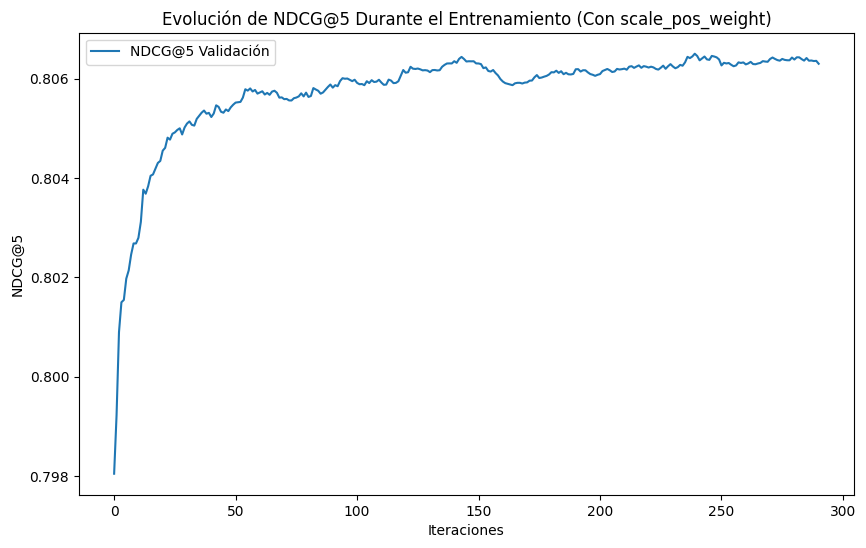

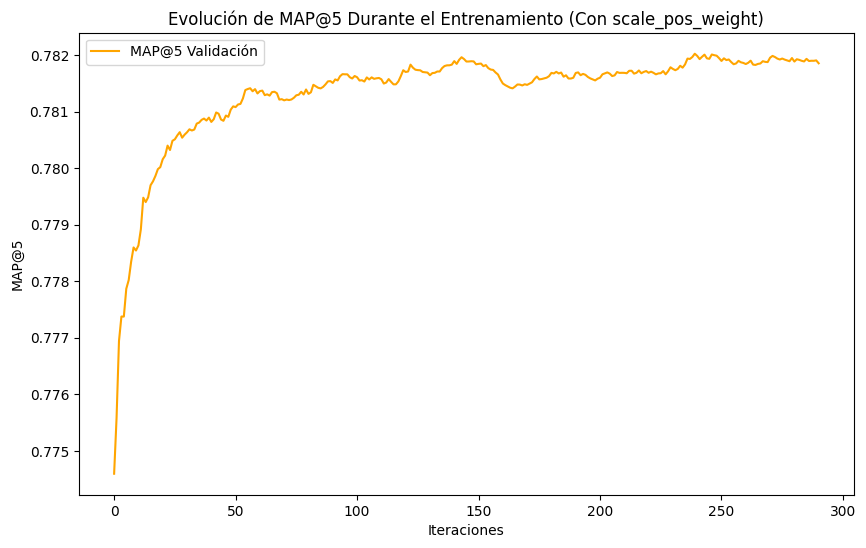

In [7]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 📂 Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# Calcular pesos para balanceo de clases
class_counts = train["add_to_cart"].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"🔍 scale_pos_weight: {scale_pos_weight:.4f}")

# Crear nuevas características
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))
test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x))
test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# Seleccionar columnas de características
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 2️⃣ 🔄 División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()


# 📊 3️⃣ Configuración de Parámetros de LightGBM
params = {
    'learning_rate': 0.015,
    'min_data_in_leaf': 15,
    'num_leaves': 50,
    'scale_pos_weight': 15,
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'boosting_type': 'gbdt',
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
    }

# 4️⃣ 🚀 Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=150)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 5️⃣ 📊 Impresión de Métricas de Evaluación
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\nMétricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

print(params)

# 📊 Visualizar la evolución de NDCG@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento (Con scale_pos_weight)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# 📊 Visualizar la evolución de MAP@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'map@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAP@5')
    plt.title('Evolución de MAP@5 Durante el Entrenamiento (Con scale_pos_weight)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")


    


## Modelo cambiando rank_xendcg

🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's ndcg@1: 0.762772	valid_0's ndcg@3: 0.788699	valid_0's ndcg@5: 0.805722	valid_0's map@1: 0.762772	valid_0's map@3: 0.772391	valid_0's map@5: 0.781319

Mejor número de iteraciones: 968

📌 Métricas en el conjunto de validación:
NDCG@5: 0.1431
Precision@5: 0.0740
Recall@5: 0.1866


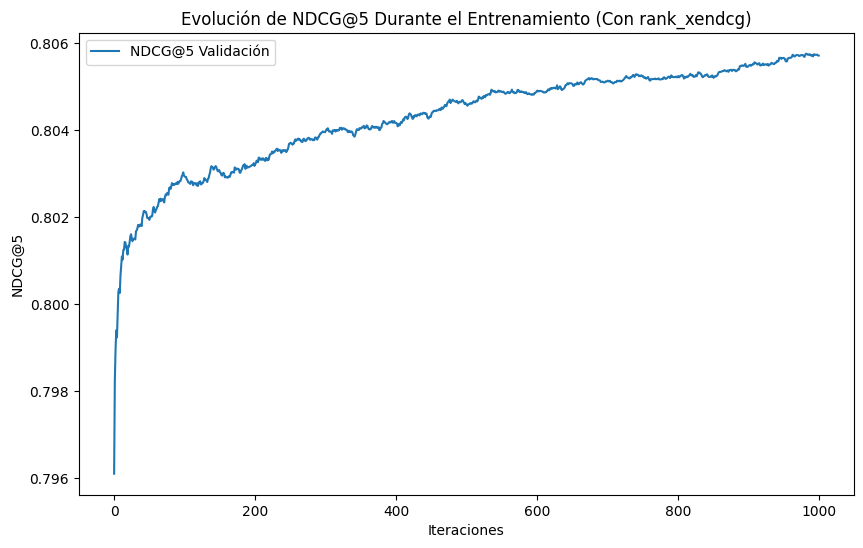

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 📂 1️⃣ Carga de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🔄 Balanceo de Clases
class_counts = train["add_to_cart"].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"🔍 scale_pos_weight: {scale_pos_weight:.4f}")

# 📊 Creación de Features
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Selección de Features
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 🎯 2️⃣ División en Train/Val
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# 🔄 Agrupación por Sesión
group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 📊 3️⃣ Parámetros con rank_xendcg
params = {
    'objective': 'rank_xendcg',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'boosting_type': 'gbdt', 
    'learning_rate': 0.015,
    'num_leaves': 50,
    'min_data_in_leaf': 15,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 🚀 4️⃣ Entrenamiento con Early Stopping
train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

callbacks = [lgb.early_stopping(stopping_rounds=150)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 📌 5️⃣ Evaluación del Modelo
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue
    true_labels = group['add_to_cart'].values
    scores = y_val_pred[group.reset_index(drop=True).index]

    ndcg_scores.append(ndcg_score([true_labels], [scores], k=5))
    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision_scores.append(np.sum(top_k_true) / 5.0)
    recall_scores.append(np.sum(top_k_true) / (np.sum(true_labels) + 1e-10))

# 📊 Resultados Finales
print("\n📌 Métricas en el conjunto de validación:")
print(f"NDCG@5: {np.mean(ndcg_scores):.4f}")
print(f"Precision@5: {np.mean(precision_scores):.4f}")
print(f"Recall@5: {np.mean(recall_scores):.4f}")

# 📈 Visualización de NDCG@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento (Con rank_xendcg)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")


## Modelo con LambdaRank y ajustes avanzados

Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[128]	valid_0's ndcg@1: 0.763184	valid_0's ndcg@3: 0.789411	valid_0's ndcg@5: 0.806351	valid_0's map@1: 0.763184	valid_0's map@3: 0.77291	valid_0's map@5: 0.781848

Mejor número de iteraciones: 128

Métricas en el conjunto de validación:
NDCG@5: 0.1551
Precision@5: 0.0811
Recall@5: 0.1985
{'objective': 'lambdarank', 'metric': ['ndcg', 'map'], 'ndcg_eval_at': [1, 3, 5], 'learning_rate': 0.015, 'num_leaves': 50, 'min_data_in_leaf': 15, 'is_unbalance': True, 'boosting_type': 'goss', 'verbose': -1, 'device': 'cpu', 'force_row_wise': True}


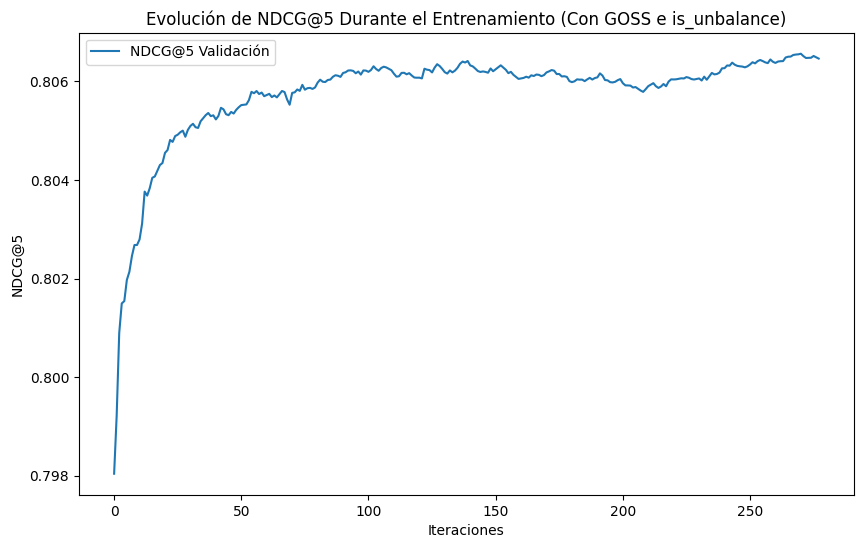

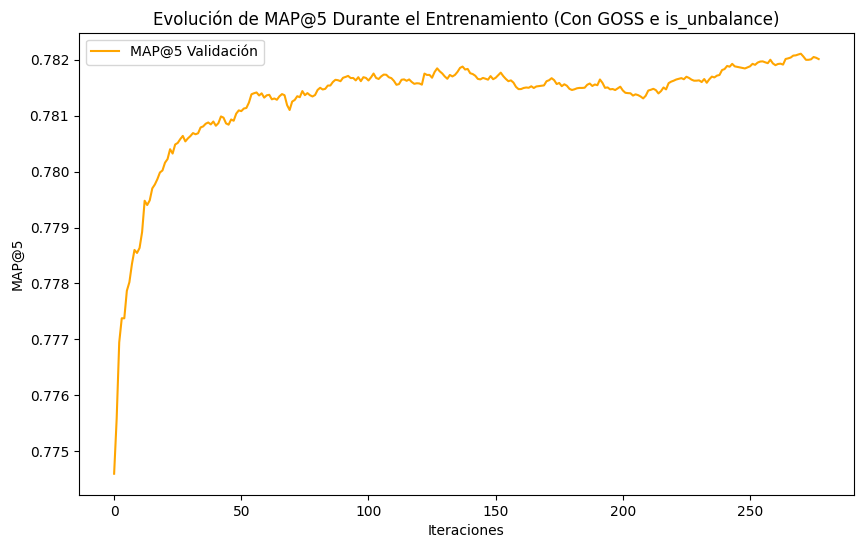

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 📂 Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"

train = pd.read_parquet(train_path)

# 🔢 Calcular embeddings_mean y embeddings_norm
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Seleccionar Features (excluir columnas irrelevantes)
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# 2️⃣ 🔄 División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 📊 3️⃣ Configuración de Parámetros de LightGBM con `is_unbalance=True` y `boosting_type='goss'`
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'learning_rate': 0.015,
    'num_leaves': 50,
    'min_data_in_leaf': 15,
    'is_unbalance': True,  # ⚠️ Activa balanceo automático
    'boosting_type': 'goss',  # ⚡ Usa Gradient-based One-Side Sampling
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 4️⃣ 🚀 Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=150)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 5️⃣ 📊 Evaluación del Modelo
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores, precision_scores, recall_scores = [], [], []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\nMétricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

print(params)

# 📊 6️⃣ Visualizar la evolución de NDCG@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento (Con GOSS e is_unbalance)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# 📊 Visualizar la evolución de MAP@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'map@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAP@5')
    plt.title('Evolución de MAP@5 Durante el Entrenamiento (Con GOSS e is_unbalance)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")


## Modelo utilizando GOSS

🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[128]	valid_0's ndcg@1: 0.763184	valid_0's ndcg@3: 0.789411	valid_0's ndcg@5: 0.806351	valid_0's map@1: 0.763184	valid_0's map@3: 0.77291	valid_0's map@5: 0.781848

Mejor número de iteraciones: 128

📌 Métricas en el conjunto de validación:
NDCG@5: 0.1551
Precision@5: 0.0811
Recall@5: 0.1985
{'objective': 'lambdarank', 'metric': ['ndcg', 'map'], 'ndcg_eval_at': [1, 3, 5], 'learning_rate': 0.015, 'num_leaves': 50, 'min_data_in_leaf': 15, 'is_unbalance': True, 'boosting_type': 'goss', 'top_rate': 0.2, 'other_rate': 0.1, 'verbose': -1, 'device': 'cpu', 'force_row_wise': True}


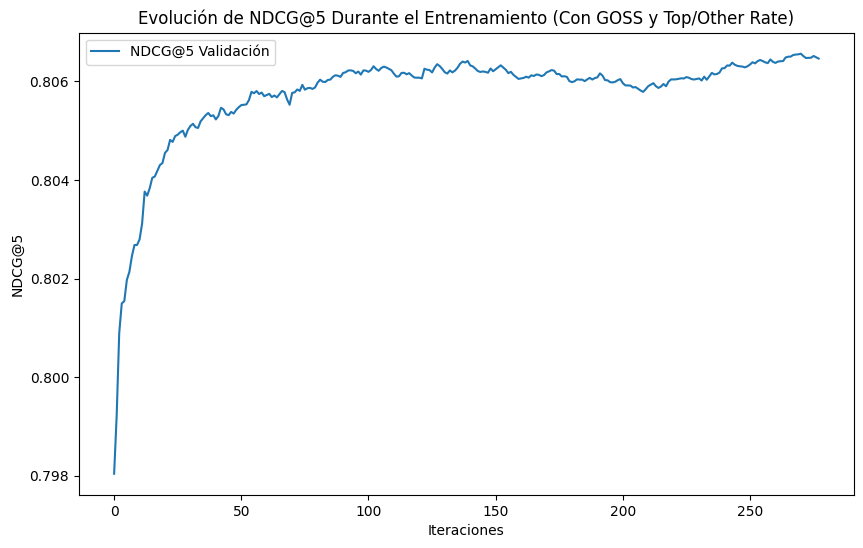

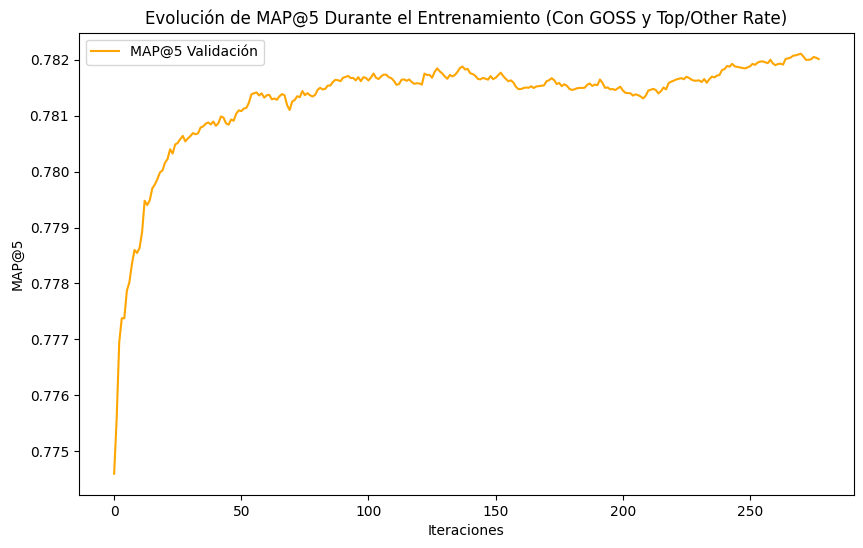

In [13]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# Calcular pesos para balanceo de clases
class_counts = train["add_to_cart"].value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"🔍 scale_pos_weight: {scale_pos_weight:.4f}")

# Crear nuevas características
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))
test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x))
test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# Seleccionar columnas de características
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced']
features_cols = [col for col in train.columns if col not in exclude_cols + ['add_to_cart']]

# 🔄 2️⃣ División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 📊 3️⃣ Configuración de Parámetros de LightGBM con GOSS y Top/Other Rate
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'learning_rate': 0.015,
    'num_leaves': 50,
    'min_data_in_leaf': 15,
    'is_unbalance': True,
    'boosting_type': 'goss',  
    'top_rate': 0.2,  # Selecciona el 20% con mayor gradiente
    'other_rate': 0.1,  # Selecciona aleatoriamente el 10% de los restantes
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 🚀 4️⃣ Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(
    X_train,
    label=y_train,
    group=group_train
)

val_dataset = lgb.Dataset(
    X_val,
    label=y_val,
    group=group_val,
    reference=train_dataset
)

callbacks = [lgb.early_stopping(stopping_rounds=150)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 📌 5️⃣ Evaluación del Modelo
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores = []
precision_scores = []
recall_scores = []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg = calculate_ndcg_at_k(true_labels, scores, k=5)
    ndcg_scores.append(ndcg)

    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision = np.sum(top_k_true) / 5.0
    recall = np.sum(top_k_true) / (np.sum(true_labels) + 1e-10)

    precision_scores.append(precision)
    recall_scores.append(recall)

average_ndcg = np.mean(ndcg_scores) if ndcg_scores else float('nan')
average_precision = np.mean(precision_scores) if precision_scores else float('nan')
average_recall = np.mean(recall_scores) if recall_scores else float('nan')

print(f"\n📌 Métricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

print(params)

# 📊 6️⃣ Visualizar la evolución de NDCG@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'ndcg@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
    plt.xlabel('Iteraciones')
    plt.ylabel('NDCG@5')
    plt.title('Evolución de NDCG@5 Durante el Entrenamiento (Con GOSS y Top/Other Rate)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de NDCG@5 en evals_result.")

# 📊 Visualizar la evolución de MAP@5
plt.figure(figsize=(10, 6))
if 'valid_0' in evals_result and 'map@5' in evals_result['valid_0']:
    plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
    plt.xlabel('Iteraciones')
    plt.ylabel('MAP@5')
    plt.title('Evolución de MAP@5 Durante el Entrenamiento (Con GOSS y Top/Other Rate)')
    plt.legend()
    plt.show()
else:
    print("No se encontró información de MAP@5 en evals_result.")


## Tabla

El mejor resultado hasta ahora ha sido con **GBDT** (Gradient Boosting Decision Trees)

### 🔍 Comparación de los mejores resultados:
| **Configuración**  | **NDCG@5** | **Precision@5** | **Recall@5** | **Mejor iteración** |
|---------------------|------------|-----------------|--------------|------------------|
| **GBDT (baseline óptimo)**  | **0.1554** | **0.0816** | **0.1999** | **141** |
| **GOSS + is_unbalance**  | 0.1551 | 0.0811 | 0.1985 | 128 |
| **GOSS + Top/Other Rate** | 0.1551 | 0.0811 | 0.1985 | 128 |
| **Rank_xendcg** | 0.1431 | 0.0740 | 0.1866 | 968 |



## Modelo GBDT Optimizado

🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's ndcg@1: 0.764597	valid_0's ndcg@3: 0.79054	valid_0's ndcg@5: 0.807606	valid_0's map@1: 0.764597	valid_0's map@3: 0.774089	valid_0's map@5: 0.783066
✅ Modelo guardado como 'best_model.txt'

Mejor número de iteraciones: 974

📌 Métricas en el conjunto de validación:
NDCG@5: 0.1573
Precision@5: 0.0821
Recall@5: 0.2010


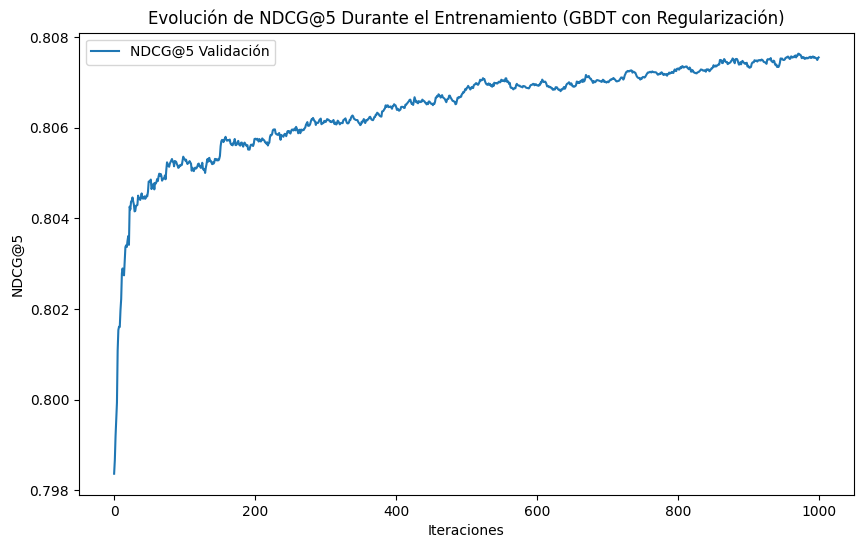

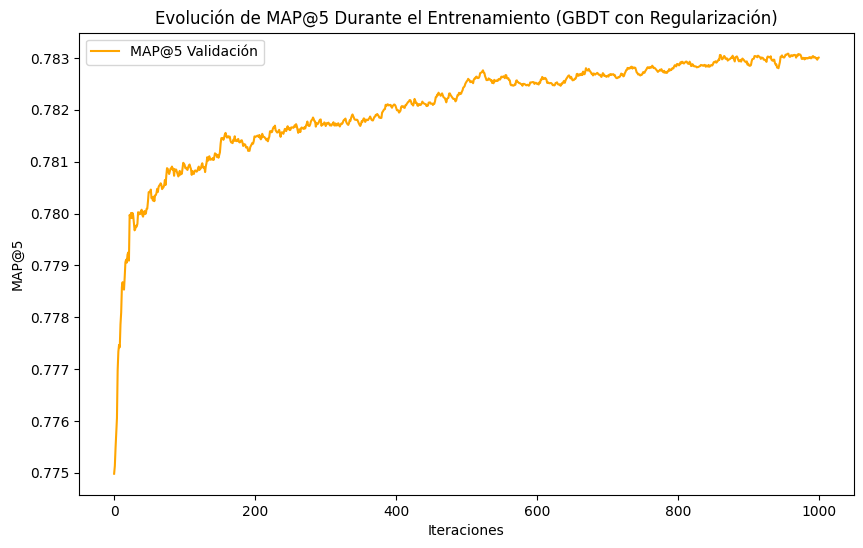

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🔢 Calcular embeddings_mean y embeddings_norm en train
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Seleccionar Features (excluir columnas irrelevantes)
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# 🔄 Balanceo de Clases con scale_pos_weight
pos_weight = train["add_to_cart"].value_counts()[0] / train["add_to_cart"].value_counts()[1]
print(f"🔍 scale_pos_weight: {pos_weight:.4f}")

# ⚙️ 2️⃣ División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)

train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train = train_df[features_cols]
y_train = train_df['add_to_cart']
X_val = val_df[features_cols]
y_val = val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 📊 3️⃣ Configuración de Parámetros de LightGBM
params = {
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'learning_rate': 0.015,
    'num_leaves': 50,
    'min_data_in_leaf': 15,
    'scale_pos_weight': pos_weight,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'max_depth': 8,
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}

# 🚀 4️⃣ Entrenamiento del Modelo con Early Stopping
train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

callbacks = [lgb.early_stopping(stopping_rounds=150)]
evals_result = {}

model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[val_dataset],
    callbacks=callbacks + [lgb.record_evaluation(evals_result)]
)

# 📌 5️⃣ Guardar el Mejor Modelo
model.save_model("best_model.txt")
print("✅ Modelo guardado como 'best_model.txt'")

# 📌 6️⃣ Evaluación del Modelo
best_iteration = model.best_iteration
print(f"\nMejor número de iteraciones: {best_iteration}")

y_val_pred = model.predict(X_val, num_iteration=best_iteration)

def calculate_ndcg_at_k(y_true, y_scores, k=5):
    return ndcg_score([y_true], [y_scores], k=k)

ndcg_scores, precision_scores, recall_scores = [], [], []

for session_id, group in val_df_reset.groupby('session_id'):
    if len(group) < 2:
        continue

    true_labels = group['add_to_cart'].values
    indices = group.index
    scores = y_val_pred[indices]

    ndcg_scores.append(calculate_ndcg_at_k(true_labels, scores, k=5))
    top_k_indices = np.argsort(scores)[-5:][::-1]
    top_k_true = true_labels[top_k_indices]

    precision_scores.append(np.sum(top_k_true) / 5.0)
    recall_scores.append(np.sum(top_k_true) / (np.sum(true_labels) + 1e-10))

# 📊 7️⃣ Resultados Finales
average_ndcg = np.mean(ndcg_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print(f"\n📌 Métricas en el conjunto de validación:")
print(f"NDCG@5: {average_ndcg:.4f}")
print(f"Precision@5: {average_precision:.4f}")
print(f"Recall@5: {average_recall:.4f}")

# 📊 8️⃣ Visualizar la evolución de NDCG@5
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@5'], label='NDCG@5 Validación')
plt.xlabel('Iteraciones')
plt.ylabel('NDCG@5')
plt.title('Evolución de NDCG@5 Durante el Entrenamiento (GBDT con Regularización)')
plt.legend()
plt.show()

# 📊 Visualizar la evolución de MAP@5
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['map@5'], label='MAP@5 Validación', color='orange')
plt.xlabel('Iteraciones')
plt.ylabel('MAP@5')
plt.title('Evolución de MAP@5 Durante el Entrenamiento (GBDT con Regularización)')
plt.legend()
plt.show()


### Prediciones - _optimized

In [ ]:
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics.pairwise import cosine_similarity

# 📂 1️⃣ Cargar el dataset de test
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
test = pd.read_parquet(test_path)

# 📌 2️⃣ Calcular embeddings_mean y embeddings_norm en test (para alinearlo con train)
test["embedding_mean"] = test["embedding_reduced"].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else 0)
test["embedding_norm"] = test["embedding_reduced"].apply(lambda x: np.linalg.norm(x) if isinstance(x, np.ndarray) else 0)

# 📌 3️⃣ Asegurar que test tenga exactamente las mismas columnas que train (menos 'add_to_cart')
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# Extraer solo las features para predicción sin eliminar 'session_id' del dataset original
test_features = test[features_cols]

# 📌 4️⃣ Cargar el modelo previamente guardado
best_model = lgb.Booster(model_file="best_model.txt")  # Cargar modelo entrenado
test["predicted_score"] = best_model.predict(test_features, num_iteration=best_model.best_iteration)

# 📌 5️⃣ Generar el top 5 de productos recomendados por sesión sin repeticiones
recommendations = {}
top_popular_products = train.groupby("partnumber")["add_to_cart"].mean().sort_values(ascending=False).index.tolist()

for session_id, group in test.groupby("session_id"):  # Ahora 'session_id' debe existir
    sorted_group = group.sort_values(by="predicted_score", ascending=False)
    top_5_products = list(dict.fromkeys(sorted_group["partnumber"].tolist()))[:5]

    # 🧐 Si faltan productos, buscar por embeddings similares
    if len(top_5_products) < 5 and "embedding_reduced" in group.columns:
        product_embeddings = np.vstack(group["embedding_reduced"].dropna().values)
        if product_embeddings.shape[0] > 1:
            similarity_matrix = cosine_similarity(product_embeddings)
            most_similar_products = group.iloc[np.argsort(similarity_matrix.mean(axis=0))[-(5 - len(top_5_products)):]]["partnumber"].tolist()
            top_5_products.extend([p for p in most_similar_products if p not in top_5_products])

    # 🏆 Si aún faltan productos, completar con productos más populares
    top_5_products.extend([p for p in top_popular_products if p not in top_5_products][:5 - len(top_5_products)])

    recommendations[session_id] = top_5_products[:5]  # Garantizar que solo haya 5 productos únicos

# 📂 6️⃣ Guardar en formato JSON
output = {"target": recommendations}

with open("predictions_3_gbdt_optimized_fixed.json", "w") as f:
    json.dump(output, f, indent=4)

print("✅ Archivo predictions_3_gbdt_optimized_fixed.json generado correctamente.")


✅ Archivo predictions_3_gbdt_optimized_fixed.json generado correctamente.


## Modelo GBDT Optimizado v2 - Hyperparam Tuning - RandomizedSearch - NO MEJORA LOS RESULTADOS ANTERIORES



```python
{
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'learning_rate': 0.015,
    'max_depth': 6,
    'min_data_in_leaf': 10,
    'num_leaves': 40,
    'objective': 'lambdarank',
    'metric': ['ndcg', 'map'],
    'ndcg_eval_at': [1, 3, 5],
    'boosting_type': 'gbdt',
    'scale_pos_weight': 13.2069,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu',
    'force_row_wise': True
}
```

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# 📂 1️⃣ Carga y Preparación de Datos
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🔢 Calcular embeddings_mean y embeddings_norm en train
train["embedding_mean"] = train["embedding_reduced"].apply(lambda x: np.mean(x))
train["embedding_norm"] = train["embedding_reduced"].apply(lambda x: np.linalg.norm(x))

# 🔄 Seleccionar Features (excluir columnas irrelevantes)
exclude_cols = ['session_id', 'timestamp_local', 'embedding_reduced', 'add_to_cart']
features_cols = [col for col in train.columns if col not in exclude_cols]

# 🔄 Balanceo de Clases con scale_pos_weight
pos_weight = train["add_to_cart"].value_counts()[0] / train["add_to_cart"].value_counts()[1]
print(f"🔍 scale_pos_weight: {pos_weight:.4f}")

# ⚙️ 2️⃣ División de Datos en Entrenamiento y Validación
unique_sessions = train['session_id'].unique()
train_sessions, val_sessions = train_test_split(unique_sessions, test_size=0.2, random_state=42)
train_df = train[train['session_id'].isin(train_sessions)]
val_df = train[train['session_id'].isin(val_sessions)]

print(f"Total sesiones en train: {train_df['session_id'].nunique()}")
print(f"Total sesiones en val: {val_df['session_id'].nunique()}")

X_train, y_train = train_df[features_cols], train_df['add_to_cart']
X_val, y_val = val_df[features_cols], val_df['add_to_cart']

# Restablecer índices en validación para alinear predicciones
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_df_reset = val_df.reset_index(drop=True)

group_train = train_df.groupby('session_id').size().tolist()
group_val = val_df.groupby('session_id').size().tolist()

# 📊 3️⃣ Definir GridSearch Hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.015],
    'num_leaves': [40, 50],
    'min_data_in_leaf': [10, 15],
    'lambda_l1': [0.5, 1.0],
    'lambda_l2': [0.5, 1.0],
    'max_depth': [6, 8],
}

best_ndcg, best_params, best_model = -np.inf, None, None

# 🔄 4️⃣ Ejecutar GridSearch
for params in ParameterGrid(param_grid):
    params.update({
        'objective': 'lambdarank',
        'metric': ['ndcg', 'map'],
        'ndcg_eval_at': [1, 3, 5],
        'boosting_type': 'gbdt',
        'scale_pos_weight': pos_weight,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device': 'cpu',
        'force_row_wise': True
    })
    
    print(f"\n🚀 Probando configuración: {params}")
    train_dataset = lgb.Dataset(X_train, label=y_train, group=group_train)
    val_dataset = lgb.Dataset(X_val, label=y_val, group=group_val, reference=train_dataset)

    model = lgb.train(
        params,
        train_dataset,
        num_boost_round=1000,
        valid_sets=[val_dataset],
        callbacks=[lgb.early_stopping(stopping_rounds=150, verbose=True)]
    )
    
    y_val_pred = pd.Series(model.predict(X_val, num_iteration=model.best_iteration), index=X_val.index)
    
    ndcg_scores = [ndcg_score([group["add_to_cart"].values], [y_val_pred.loc[group.index]], k=5)
                    for session_id, group in val_df_reset.groupby("session_id") if len(group) > 1]
    
    avg_ndcg = np.mean(ndcg_scores)
    print(f"📌 NDCG@5 para configuración actual: {avg_ndcg:.4f}")
    
    if avg_ndcg > best_ndcg:
        best_ndcg, best_params, best_model = avg_ndcg, params.copy(), model

print(f"\n✅ Mejor configuración encontrada: {best_params}")
print(f"📌 Mejor NDCG@5: {best_ndcg:.4f}")

# 📊 5️⃣ Guardar Modelo
best_model.save_model("best_lgbm_model.txt")
with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)
print("✅ Modelo y parámetros guardados correctamente.")


🔍 scale_pos_weight: 13.2069
Total sesiones en train: 407608
Total sesiones en val: 101902

🚀 Probando configuración: {'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 40, 'objective': 'lambdarank', 'metric': ['ndcg', 'map'], 'ndcg_eval_at': [1, 3, 5], 'boosting_type': 'gbdt', 'scale_pos_weight': 13.206874089032564, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'device': 'cpu', 'force_row_wise': True}
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[207]	valid_0's ndcg@1: 0.761938	valid_0's ndcg@3: 0.787604	valid_0's ndcg@5: 0.804794	valid_0's map@1: 0.761938	valid_0's map@3: 0.771425	valid_0's map@5: 0.780551
📌 NDCG@5 para configuración actual: 0.1531

🚀 Probando configuración: {'lambda_l1': 0.5, 'lambda_l2': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_data_in_leaf': 10, 'num_leaves': 50, 'objective': 'lambdarank', 'metric': ['ndcg'

KeyboardInterrupt: 

## Reanalizamos los datasets finales

In [2]:
import pandas as pd
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

: 

: 

In [ ]:
print(train.info())
print(train.describe())
print(train.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6978928 entries, 0 to 6978927
Data columns (total 21 columns):
 #   Column               Dtype         
---  ------               -----         
 0   session_id           int32         
 1   timestamp_local      datetime64[ns]
 2   add_to_cart          int8          
 3   user_id              int32         
 4   country_x            int8          
 5   partnumber           int32         
 6   device_type          int8          
 7   low_interaction      int64         
 8   winsorized_sessions  int64         
 9   hour                 int32         
 10  is_anonymous         int64         
 11  discount             int8          
 12  color_id             int32         
 13  cod_section          int8          
 14  family               int32         
 15  embedding_reduced    object        
 16  country_y            int8          
 17  R                    float32       
 18  F                    float32       
 19  M                    

In [ ]:

print(test.info())
print(test.describe())
print(test.head(10))

# **Two-Tower Model en PyTorch**

## Código entrenamiento benchmark

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 📂 1️⃣ Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)

# 🚀 2️⃣ Separar características de usuario y producto
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour", 
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "color_id", "cod_section", "family", "discount", "country_y"]

# 📊 Extraer features y etiquetas
X_users = torch.tensor(train[user_features].values, dtype=torch.float32)
X_products = torch.tensor(np.stack(train["embedding_reduced"].values), dtype=torch.float32)
y = torch.tensor(train["add_to_cart"].values, dtype=torch.float32)

# 📊 3️⃣ División en train/val
X_users_train, X_users_val, X_products_train, X_products_val, y_train, y_val = train_test_split(
    X_users, X_products, y, test_size=0.2, random_state=42
)

# 🔹 Convertir a Tensores
train_dataset = torch.utils.data.TensorDataset(X_users_train, X_products_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_users_val, X_products_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 🏗 4️⃣ Definir el Two-Tower Model en PyTorch
class TwoTowerModel(nn.Module):
    def __init__(self, user_dim, product_dim, emb_size=64):
        super(TwoTowerModel, self).__init__()
        # Torre de Usuarios
        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 128),
            nn.ReLU(),
            nn.Linear(128, emb_size)
        )
        # Torre de Productos
        self.product_net = nn.Sequential(
            nn.Linear(product_dim, 128),
            nn.ReLU(),
            nn.Linear(128, emb_size)
        )

    def forward(self, users, products):
        user_emb = self.user_net(users)
        product_emb = self.product_net(products)
        return torch.sum(user_emb * product_emb, dim=1)  # Dot-product

# 🔧 5️⃣ Inicializar Modelo, Pérdida y Optimización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoTowerModel(user_dim=len(user_features), product_dim=X_products.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🎯 6️⃣ Entrenar el Modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for users, products, labels in train_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(users, products)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for users, products, labels in val_loader:
                users, products, labels = users.to(device), products.to(device), labels.to(device)
                outputs = model(users, products)
                val_loss += criterion(outputs, labels).item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# 📌 7️⃣ Guardar el Modelo
torch.save(model.state_dict(), "two_tower_model.pth")
print("✅ Modelo guardado como 'two_tower_model.pth'")


Epoch 1/10, Loss: 24.8143, Val Loss: 0.3248
Epoch 2/10, Loss: 1.0860, Val Loss: 0.2648
Epoch 3/10, Loss: 0.3809, Val Loss: 0.2613
Epoch 4/10, Loss: 0.2544, Val Loss: 0.2545
Epoch 5/10, Loss: 0.2540, Val Loss: 0.2528
Epoch 6/10, Loss: 0.2526, Val Loss: 0.2527
Epoch 7/10, Loss: 0.2530, Val Loss: 0.2527
Epoch 8/10, Loss: 0.2545, Val Loss: 0.2530
Epoch 9/10, Loss: 0.2522, Val Loss: 0.2526
Epoch 10/10, Loss: 0.2522, Val Loss: 0.2525
✅ Modelo guardado como 'two_tower_model.pth'


## Predicciones

In [56]:
import numpy as np
print(np.array(train["embedding_reduced"].iloc[0]).shape)  # ¿50 o 64?
user_feature_dim = len(user_features) 
print(user_feature_dim)

(50,)
11


In [62]:
import json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

# 📂 1️⃣ Cargar el dataset de test y train
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"

test = pd.read_parquet(test_path)
train = pd.read_parquet(train_path)

# 📌 2️⃣ Cargar el modelo Two-Tower
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwoTowerModel(torch.nn.Module):
    def __init__(self, user_dim, product_dim):
        super(TwoTowerModel, self).__init__()
        self.user_net = torch.nn.Sequential(
            torch.nn.Linear(user_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64)
        )
        self.product_net = torch.nn.Sequential(
            torch.nn.Linear(product_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64)
        )

    def forward(self, user_features, product_features):
        user_embedding = self.user_net(user_features)
        product_embedding = self.product_net(product_features)
        return (user_embedding * product_embedding).sum(dim=1)

# 📌 Cargar el modelo entrenado
user_feature_dim = 11
product_feature_dim = 50  # Tamaño real del embedding
model = TwoTowerModel(user_feature_dim, product_feature_dim).to(device)
model.load_state_dict(torch.load("two_tower_model.pth", map_location=device))
model.eval()

# 📌 3️⃣ Preprocesamiento del test para alinearlo con el entrenamiento
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour",
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "embedding_reduced"]

# Asegurar que `session_id` está en `test`
test = test[["session_id"] + user_features + product_features]

# 📌 4️⃣ Generar predicciones usando el modelo
user_tensor = torch.tensor(test[user_features].values, dtype=torch.float32).to(device)
product_tensor = torch.tensor(np.stack(test["embedding_reduced"].values), dtype=torch.float32).to(device)

test["predicted_score"] = model(user_tensor, product_tensor).detach().cpu().numpy()

# 📌 5️⃣ Crear las recomendaciones por sesión
recommendations = {}
for session_id, group in test.groupby("session_id"):
    sorted_group = group.sort_values(by="predicted_score", ascending=False)
    top_5_products = list(dict.fromkeys(sorted_group["partnumber"].tolist()))[:5]  # Asegurar unicidad
    recommendations[session_id] = top_5_products

# 📌 6️⃣ Ajustar recomendaciones para garantizar 5 productos únicos
# 🎯 Obtener embeddings de productos para similitud
product_embeddings = train.groupby("partnumber")["embedding_reduced"].first().dropna().to_dict()
product_keys = np.array(list(product_embeddings.keys()))
product_matrix = np.vstack(list(product_embeddings.values()))

# 🎯 Obtener productos más populares (por tasa de conversión)
popular_products = train.groupby("partnumber")["add_to_cart"].mean().sort_values(ascending=False).index.tolist()

def find_similar_products(product_id, num_needed=5):
    """ Encuentra productos similares basados en embeddings """
    if product_id not in product_embeddings:
        return []
    product_vector = np.array(product_embeddings[product_id]).reshape(1, -1)
    similarities = cosine_similarity(product_vector, product_matrix)[0]
    similar_indices = np.argsort(similarities)[::-1]  # Ordenar descendente
    similar_products = product_keys[similar_indices]
    return [p for p in similar_products if p != product_id][:num_needed]

# 🔄 Completar recomendaciones hasta 5 productos por sesión
for session_id, products in recommendations.items():
    products = list(dict.fromkeys(products))  # Eliminar duplicados
    if len(products) < 5:
        new_products = []
        for p in products:
            new_products.extend(find_similar_products(p, num_needed=5))
            if len(set(products + new_products)) >= 5:
                break
        
        # Evitar duplicados y asegurar 5 productos
        products.extend([p for p in new_products if p not in products][:5 - len(products)])

    if len(products) < 5:
        products.extend([p for p in popular_products if p not in products][:5 - len(products)])

    recommendations[session_id] = products[:5]  # Garantizar solo 5 únicos

# 📌 7️⃣ Guardar JSON con las predicciones
output = {"target": {int(session_id): [int(p) for p in products] for session_id, products in recommendations.items()}}

with open("predictions_two_tower_fixed.json", "w") as f:
    json.dump(output, f, indent=4)

print("✅ Archivo predictions_two_tower_fixed.json generado correctamente.")


/tmp/ipykernel_614101/4271380877.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("two_tower_model.pth", map_location=device))


✅ Archivo predictions_two_tower_fixed.json generado correctamente.


## Código  optimizado

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, ndcg_score

# 📂 1️⃣ Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🚀 2️⃣ Separar características de usuario y producto
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour", 
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "color_id", "cod_section", "family", "discount", "country_y"]

# 📊 Extraer features y etiquetas
X_users = torch.tensor(train[user_features].values, dtype=torch.float32)
X_products = torch.tensor(np.stack(train["embedding_reduced"].values), dtype=torch.float32)
y = torch.tensor(train["add_to_cart"].values, dtype=torch.float32)

# 📊 3️⃣ División en train/val
X_users_train, X_users_val, X_products_train, X_products_val, y_train, y_val = train_test_split(
    X_users, X_products, y, test_size=0.2, random_state=42
)

# 🔹 Convertir a Tensores
target_train = y_train.unsqueeze(1)
target_val = y_val.unsqueeze(1)

# 🔹 Balanceo de Clases (Sobremuestreo)
pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

train_dataset = torch.utils.data.TensorDataset(X_users_train, X_products_train, target_train)
val_dataset = torch.utils.data.TensorDataset(X_users_val, X_products_val, target_val)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 🏗 4️⃣ Definir el Two-Tower Model Mejorado
class TwoTowerModel(nn.Module):
    def __init__(self, user_dim, product_dim, emb_size=128):
        super(TwoTowerModel, self).__init__()
        
        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, emb_size)
        )
        
        self.product_net = nn.Sequential(
            nn.Linear(product_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, emb_size)
        )
    
    def forward(self, users, products):
        user_emb = self.user_net(users)
        product_emb = self.product_net(products)
        return torch.sum(user_emb * product_emb, dim=1)

# 🔧 5️⃣ Inicializar Modelo, Pérdida y Optimización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoTowerModel(user_dim=len(user_features), product_dim=X_products.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 🎯 6️⃣ Entrenar el Modelo con Early Stopping y Métricas
def precision_at_k(y_true, y_pred, k=5):
    top_k_indices = torch.argsort(y_pred, descending=True)[:k]
    return torch.sum(y_true[top_k_indices]) / k

def recall_at_k(y_true, y_pred, k=5):
    top_k_indices = torch.argsort(y_pred, descending=True)[:k]
    return torch.sum(y_true[top_k_indices]) / torch.sum(y_true + 1e-10)

def auc_roc(y_true, y_pred):
    return roc_auc_score(y_true.cpu().numpy(), y_pred.cpu().numpy())

def ndcg_at_k(y_true, y_pred, k=5):
    """
    Calcula NDCG@k asegurando que las dimensiones sean correctas.
    """
    y_true_np = y_true.cpu().numpy().reshape(1, -1)  # Asegura que sea (1, N)
    y_pred_np = y_pred.cpu().numpy().reshape(1, -1)
    
    return ndcg_score(y_true_np, y_pred_np, k=k)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7):
    best_score = float('-inf')
    patience = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for users, products, labels in train_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(users, products)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        val_loss, precision, recall, auc, ndcg = 0, 0, 0, 0, 0
        with torch.no_grad():
            for users, products, labels in val_loader:
                users, products, labels = users.to(device), products.to(device), labels.to(device)
                outputs = model(users, products)
                
                val_loss += criterion(outputs.squeeze(), labels.squeeze()).item()
                precision += precision_at_k(labels, outputs).item()
                recall += recall_at_k(labels, outputs).item()
                auc += auc_roc(labels, outputs)
                ndcg += ndcg_at_k(labels, outputs)
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_precision = precision / len(val_loader)
        avg_recall = recall / len(val_loader)
        avg_auc = auc / len(val_loader)
        avg_ndcg = ndcg / len(val_loader)
        
        # 🎯 Score de validación con ponderación para optimización
        score = (0.5 * avg_ndcg) + (0.3 * avg_auc) + (0.2 * avg_precision)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"P@5: {avg_precision:.4f}, R@5: {avg_recall:.4f}, AUC: {avg_auc:.4f}, NDCG@5: {avg_ndcg:.4f}, Score: {score:.4f}")

        scheduler.step(avg_val_loss)

        if score > best_score:
            best_score = score
            patience = 0
            torch.save(model.state_dict(), "two_tower_model.pth")
            print("✅ Nuevo mejor modelo guardado")
        else:
            patience += 1
            if patience >= early_stopping:
                print("⏹ Early Stopping activado")
                break

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7)
print("✅ Entrenamiento completado y modelo guardado")


Epoch 1/35, Train Loss: 1.3298, Val Loss: 1.2731, P@5: 0.1654, R@5: 0.0230, AUC: 0.5766, NDCG@5: 0.1673, Score: 0.2897
✅ Nuevo mejor modelo guardado
Epoch 2/35, Train Loss: 1.2729, Val Loss: 1.2666, P@5: 0.1790, R@5: 0.0250, AUC: 0.5881, NDCG@5: 0.1822, Score: 0.3033
✅ Nuevo mejor modelo guardado
Epoch 3/35, Train Loss: 1.2646, Val Loss: 1.2624, P@5: 0.1760, R@5: 0.0244, AUC: 0.5952, NDCG@5: 0.1799, Score: 0.3037
✅ Nuevo mejor modelo guardado
Epoch 4/35, Train Loss: 1.2605, Val Loss: 1.2597, P@5: 0.1809, R@5: 0.0252, AUC: 0.5999, NDCG@5: 0.1836, Score: 0.3079
✅ Nuevo mejor modelo guardado
Epoch 5/35, Train Loss: 1.2583, Val Loss: 1.2581, P@5: 0.1829, R@5: 0.0254, AUC: 0.6028, NDCG@5: 0.1872, Score: 0.3110
✅ Nuevo mejor modelo guardado
Epoch 6/35, Train Loss: 1.2566, Val Loss: 1.2565, P@5: 0.1866, R@5: 0.0259, AUC: 0.6054, NDCG@5: 0.1904, Score: 0.3142
✅ Nuevo mejor modelo guardado
Epoch 7/35, Train Loss: 1.2556, Val Loss: 1.2555, P@5: 0.1820, R@5: 0.0252, AUC: 0.6071, NDCG@5: 0.1863, S

In [72]:
print(user_feature_dim, product_feature_dim)


11 50


In [77]:
import json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

# 📂 1️⃣ Cargar el dataset de test y train
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"

test = pd.read_parquet(test_path)
train = pd.read_parquet(train_path)

# 📌 2️⃣ Definir el modelo Two-Tower
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwoTowerModel(torch.nn.Module):
    def __init__(self, user_dim, product_dim):
        super(TwoTowerModel, self).__init__()
        self.user_net = torch.nn.Sequential(
            torch.nn.Linear(user_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        )
        self.product_net = torch.nn.Sequential(
            torch.nn.Linear(product_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        )

    def forward(self, user_features, product_features):
        user_embedding = self.user_net(user_features)
        product_embedding = self.product_net(product_features)
        return (user_embedding * product_embedding).sum(dim=1)

# 📌 3️⃣ Cargar el modelo entrenado con `strict=False` para evitar errores
user_feature_dim = 11
product_feature_dim = 50  # Tamaño real del embedding
model = TwoTowerModel(user_feature_dim, product_feature_dim).to(device)

checkpoint = torch.load("two_tower_model.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)  # Permite cargar parcialmente si hay cambios
model.eval()

print("✅ Modelo cargado correctamente.")

# 📌 4️⃣ Preprocesamiento del test para alinearlo con el entrenamiento
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour",
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "embedding_reduced"]

# Asegurar que `session_id` está en `test`
test = test[["session_id"] + user_features + product_features]

# 📌 5️⃣ Generar predicciones usando el modelo
user_tensor = torch.tensor(test[user_features].values, dtype=torch.float32).to(device)
product_tensor = torch.tensor(np.stack(test["embedding_reduced"].values), dtype=torch.float32).to(device)

test["predicted_score"] = model(user_tensor, product_tensor).detach().cpu().numpy()

# 📌 6️⃣ Crear las recomendaciones por sesión
recommendations = {}
for session_id, group in test.groupby("session_id"):
    sorted_group = group.sort_values(by="predicted_score", ascending=False)
    top_5_products = list(dict.fromkeys(sorted_group["partnumber"].tolist()))[:5]  # Asegurar unicidad
    recommendations[session_id] = top_5_products

# 📌 7️⃣ Ajustar recomendaciones para garantizar 5 productos únicos
# 🎯 Obtener embeddings de productos para similitud
product_embeddings = train.groupby("partnumber")["embedding_reduced"].first().dropna().to_dict()
product_keys = np.array(list(product_embeddings.keys()))
product_matrix = np.vstack(list(product_embeddings.values()))

# 🎯 Obtener productos más populares (por tasa de conversión)
popular_products = train.groupby("partnumber")["add_to_cart"].mean().sort_values(ascending=False).index.tolist()

def find_similar_products(product_id, num_needed=5):
    """ Encuentra productos similares basados en embeddings """
    if product_id not in product_embeddings:
        return []
    product_vector = np.array(product_embeddings[product_id]).reshape(1, -1)
    similarities = cosine_similarity(product_vector, product_matrix)[0]
    similar_indices = np.argsort(similarities)[::-1]  # Ordenar descendente
    similar_products = product_keys[similar_indices]
    return [p for p in similar_products if p != product_id][:num_needed]

# 🔄 Completar recomendaciones hasta 5 productos por sesión
for session_id, products in recommendations.items():
    products = list(dict.fromkeys(products))  # Eliminar duplicados
    if len(products) < 5:
        new_products = []
        for p in products:
            new_products.extend(find_similar_products(p, num_needed=5))
            if len(set(products + new_products)) >= 5:
                break
        
        # Evitar duplicados y asegurar 5 productos
        products.extend([p for p in new_products if p not in products][:5 - len(products)])

    if len(products) < 5:
        products.extend([p for p in popular_products if p not in products][:5 - len(products)])

    recommendations[session_id] = products[:5]  # Garantizar solo 5 únicos

# 📌 8️⃣ Guardar JSON con las predicciones
output = {"target": {int(session_id): [int(p) for p in products] for session_id, products in recommendations.items()}}

with open("predictions_two_tower_v2.json", "w") as f:
    json.dump(output, f, indent=4)

print("✅ Archivo predictions_two_tower_v2.json generado correctamente.")


/tmp/ipykernel_614101/3766848061.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("two_tower_model.pth", map_location=device)


✅ Modelo cargado correctamente.
✅ Archivo predictions_two_tower_v2.json generado correctamente.


---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, ndcg_score

# 📂 1️⃣ Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🚀 2️⃣ Separar características de usuario y producto
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour",
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "color_id", "cod_section", "family", "discount", "country_y"]

# 📊 Extraer features y etiquetas
X_users = torch.tensor(train[user_features].values, dtype=torch.float32)
X_products = torch.tensor(np.stack(train["embedding_reduced"].values), dtype=torch.float32)
y = torch.tensor(train["add_to_cart"].values, dtype=torch.float32)

# 📊 3️⃣ División en train/val
X_users_train, X_users_val, X_products_train, X_products_val, y_train, y_val = train_test_split(
    X_users, X_products, y, test_size=0.2, random_state=42
)

# 🔹 Convertir a Tensores
target_train = y_train.unsqueeze(1)
target_val = y_val.unsqueeze(1)

# 🔹 Balanceo de Clases (Peso para BCEWithLogitsLoss)
pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

train_dataset = torch.utils.data.TensorDataset(X_users_train, X_products_train, target_train)
val_dataset = torch.utils.data.TensorDataset(X_users_val, X_products_val, target_val)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 🏗 4️⃣ Definir el Two-Tower Model Mejorado
class TwoTowerModel(nn.Module):
    def __init__(self, user_dim, product_dim, emb_size=128):
        super(TwoTowerModel, self).__init__()

        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, emb_size)
        )

        self.product_net = nn.Sequential(
            nn.Linear(product_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, emb_size),
            nn.BatchNorm1d(emb_size),
            nn.ReLU()
        )

        self.final_layer = nn.Sequential(
            nn.Linear(3 * emb_size, 1),
            nn.Sigmoid()
        )

        # ✅ Inicialización de Pesos con Xavier
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, users, products):
        user_emb = self.user_net(users)
        product_emb = self.product_net(products)
        interaction = torch.cat((user_emb, product_emb, user_emb * product_emb), dim=1)
        return self.final_layer(interaction)

# 🔧 5️⃣ Inicializar Modelo, Pérdida y Optimización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TwoTowerModel(user_dim=len(user_features), product_dim=X_products.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def precision_at_k(y_true, y_pred, k=5):
    """
    Calcula Precision@K: Cuántos de los productos en el top-K fueron relevantes.
    """
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)  # Convertir (batch_size,) → (batch_size, 1)
    
    num_items = y_pred.shape[1]
    k = min(k, num_items)  # Evitar que k sea mayor que el número de productos disponibles

    _, top_k_indices = torch.topk(y_pred, k, dim=1)
    relevant = torch.gather(y_true, 1, top_k_indices)
    
    return relevant.sum(dim=1).float().mean() / k  # Promedio de precisión en el batch

def recall_at_k(y_true, y_pred, k=5):
    """
    Calcula Recall@K: De todos los productos relevantes, cuántos están en el top-K.
    """
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)

    num_items = y_pred.shape[1]
    k = min(k, num_items)

    _, top_k_indices = torch.topk(y_pred, k, dim=1)
    relevant = torch.gather(y_true, 1, top_k_indices)
    
    return (relevant.sum(dim=1).float() / (y_true.sum(dim=1) + 1e-10)).mean()


def auc_roc(y_true, y_pred):
    return roc_auc_score(y_true.cpu().numpy(), y_pred.cpu().numpy())

def ndcg_at_k(y_true, y_pred, k=5):
    y_true_np = y_true.cpu().numpy().reshape(1, -1)
    y_pred_np = y_pred.cpu().numpy().reshape(1, -1)
    return ndcg_score(y_true_np, y_pred_np, k=k)

# 🚀 7️⃣ Entrenamiento del Modelo con Métricas
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7):
    best_score = float('-inf')
    patience = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for users, products, labels in train_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(users, products)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss, precision, recall, auc, ndcg = 0, 0, 0, 0, 0
        batch_count = 0

        with torch.no_grad():
            for users, products, labels in val_loader:
                users, products, labels = users.to(device), products.to(device), labels.to(device)
                outputs = model(users, products)

                val_loss += criterion(outputs, labels).item()
                precision += precision_at_k(labels, outputs).item()
                recall += recall_at_k(labels, outputs).item()
                auc += auc_roc(labels, outputs)
                ndcg += ndcg_at_k(labels, outputs)
                batch_count += 1

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / batch_count
        avg_precision = precision / batch_count
        avg_recall = recall / batch_count
        avg_auc = auc / batch_count
        avg_ndcg = ndcg / batch_count

        # 🎯 Score ponderado
        score = (0.4 * avg_ndcg) + (0.3 * avg_auc) + (0.3 * avg_precision)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"P@5: {avg_precision:.4f}, R@5: {avg_recall:.4f}, AUC: {avg_auc:.4f}, NDCG@5: {avg_ndcg:.4f}, Score: {score:.4f}")

        scheduler.step(avg_val_loss)

        if score > best_score:
            best_score = score
            patience = 0
            torch.save(model.state_dict(), "two_tower_model_v5.pth")
            print("✅ Nuevo mejor modelo guardado")
        else:
            patience += 1
            if patience >= early_stopping:
                print("⏹ Early Stopping activado")
                break

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7)
print("✅ Entrenamiento completado y modelo guardado")


Epoch 1/35, Train Loss: 1.2761, Val Loss: 1.2748, P@5: 0.0705, R@5: 0.0705, AUC: 0.5758, NDCG@5: 0.1821, Score: 0.2668
✅ Nuevo mejor modelo guardado
Epoch 2/35, Train Loss: 1.2732, Val Loss: 1.2740, P@5: 0.0705, R@5: 0.0705, AUC: 0.5779, NDCG@5: 0.1865, Score: 0.2692
✅ Nuevo mejor modelo guardado
Epoch 3/35, Train Loss: 1.2719, Val Loss: 1.2724, P@5: 0.0705, R@5: 0.0705, AUC: 0.5796, NDCG@5: 0.1868, Score: 0.2697
✅ Nuevo mejor modelo guardado
Epoch 4/35, Train Loss: 1.2712, Val Loss: 1.2720, P@5: 0.0705, R@5: 0.0705, AUC: 0.5802, NDCG@5: 0.1914, Score: 0.2718
✅ Nuevo mejor modelo guardado
Epoch 5/35, Train Loss: 1.2707, Val Loss: 1.2718, P@5: 0.0705, R@5: 0.0705, AUC: 0.5811, NDCG@5: 0.1891, Score: 0.2711


KeyboardInterrupt: 

In [5]:
import json
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity

# 📂 1️⃣ Cargar el dataset de test y train
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"

test = pd.read_parquet(test_path)
train = pd.read_parquet(train_path)

# 📌 2️⃣ Definir el modelo Two-Tower
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwoTowerModel(torch.nn.Module):
    def __init__(self, user_dim, product_dim):
        super(TwoTowerModel, self).__init__()
        self.user_net = torch.nn.Sequential(
            torch.nn.Linear(user_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        )
        self.product_net = torch.nn.Sequential(
            torch.nn.Linear(product_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128)
        )

    def forward(self, user_features, product_features):
        user_embedding = self.user_net(user_features)
        product_embedding = self.product_net(product_features)
        return (user_embedding * product_embedding).sum(dim=1)

# 📌 3️⃣ Cargar el modelo entrenado con `strict=False` para evitar errores
user_feature_dim = 11
product_feature_dim = 50  # Tamaño real del embedding
model = TwoTowerModel(user_feature_dim, product_feature_dim).to(device)

checkpoint = torch.load("two_tower_model.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)  # Permite cargar parcialmente si hay cambios
model.eval()

print("✅ Modelo cargado correctamente.")

# 📌 4️⃣ Preprocesamiento del test para alinearlo con el entrenamiento
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour",
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "embedding_reduced"]

# Asegurar que `session_id` está en `test`
test = test[["session_id"] + user_features + product_features]

# 📌 5️⃣ Generar predicciones usando el modelo
user_tensor = torch.tensor(test[user_features].values, dtype=torch.float32).to(device)
product_tensor = torch.tensor(np.stack(test["embedding_reduced"].values), dtype=torch.float32).to(device)

test["predicted_score"] = model(user_tensor, product_tensor).detach().cpu().numpy()

# 📌 6️⃣ Crear las recomendaciones por sesión
recommendations = {}
for session_id, group in test.groupby("session_id"):
    sorted_group = group.sort_values(by="predicted_score", ascending=False)
    top_5_products = list(dict.fromkeys(sorted_group["partnumber"].tolist()))[:5]  # Asegurar unicidad
    recommendations[session_id] = top_5_products

# 📌 7️⃣ Ajustar recomendaciones para garantizar 5 productos únicos
# 🎯 Obtener embeddings de productos para similitud
product_embeddings = train.groupby("partnumber")["embedding_reduced"].first().dropna().to_dict()
product_keys = np.array(list(product_embeddings.keys()))
product_matrix = np.vstack(list(product_embeddings.values()))

# 🎯 Obtener productos más populares (por tasa de conversión)
popular_products = train.groupby("partnumber")["add_to_cart"].mean().sort_values(ascending=False).index.tolist()

def find_similar_products(product_id, num_needed=5):
    """ Encuentra productos similares basados en embeddings """
    if product_id not in product_embeddings:
        return []
    product_vector = np.array(product_embeddings[product_id]).reshape(1, -1)
    similarities = cosine_similarity(product_vector, product_matrix)[0]
    similar_indices = np.argsort(similarities)[::-1]  # Ordenar descendente
    similar_products = product_keys[similar_indices]
    return [p for p in similar_products if p != product_id][:num_needed]

# 🔄 Completar recomendaciones hasta 5 productos por sesión
for session_id, products in recommendations.items():
    products = list(dict.fromkeys(products))  # Eliminar duplicados
    if len(products) < 5:
        new_products = []
        for p in products:
            new_products.extend(find_similar_products(p, num_needed=5))
            if len(set(products + new_products)) >= 5:
                break
        
        # Evitar duplicados y asegurar 5 productos
        products.extend([p for p in new_products if p not in products][:5 - len(products)])

    if len(products) < 5:
        products.extend([p for p in popular_products if p not in products][:5 - len(products)])

    recommendations[session_id] = products[:5]  # Garantizar solo 5 únicos

# 📌 8️⃣ Guardar JSON con las predicciones
output = {"target": {int(session_id): [int(p) for p in products] for session_id, products in recommendations.items()}}

with open("predictions_two_tower_v4.json", "w") as f:
    json.dump(output, f, indent=4)

print("✅ Archivo predictions_two_tower_v4.json generado correctamente.")


/tmp/ipykernel_898045/3180001638.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("two_tower_model.pth", map_location=device)


✅ Modelo cargado correctamente.
✅ Archivo predictions_two_tower_v4.json generado correctamente.


---

# **Modelo Wide & Deep**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# 📂 1️⃣ Cargar datasets
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# 📂 1️⃣ Cargar dataset
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# 🚀 2️⃣ Definir características de usuario y producto
user_features = ["user_id", "country_x", "device_type", "winsorized_sessions", "hour", 
                 "is_anonymous", "low_interaction", "is_new_user", "R", "F", "M"]
product_features = ["partnumber", "color_id", "cod_section", "family", "discount", "country_y"]

# 📊 Extraer features y etiquetas
X_users = torch.tensor(train[user_features].values, dtype=torch.float32)
X_products = torch.tensor(np.stack(train["embedding_reduced"].values), dtype=torch.float32)
y = torch.tensor(train["add_to_cart"].values, dtype=torch.float32)

# 🔍 Verificación de NaNs e Inf en datos
assert not torch.isnan(X_users).any(), "Error: Hay NaNs en X_users"
assert not torch.isnan(X_products).any(), "Error: Hay NaNs en X_products"
assert not torch.isnan(y).any(), "Error: Hay NaNs en etiquetas"

# 📊 3️⃣ División en train/val
X_users_train, X_users_val, X_products_train, X_products_val, y_train, y_val = train_test_split(
    X_users, X_products, y, test_size=0.2, random_state=42
)

# 🔹 Convertir a Tensores
target_train = y_train.unsqueeze(1)
target_val = y_val.unsqueeze(1)

# 🔹 Balanceo de Clases (Focal Loss)
pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

train_dataset = torch.utils.data.TensorDataset(X_users_train, X_products_train, target_train)
val_dataset = torch.utils.data.TensorDataset(X_users_val, X_products_val, target_val)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 🎯 4️⃣ Implementación de Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# 🏗 5️⃣ Definir el Modelo Wide & Deep
class WideDeepModel(nn.Module):
    def __init__(self, user_dim, product_dim, emb_size=64):
        super(WideDeepModel, self).__init__()
        
        # 🔹 Deep Network (Parte profunda)
        self.user_net = nn.Sequential(
            nn.Linear(user_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, emb_size)
        )
        
        self.product_net = nn.Sequential(
            nn.Linear(product_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, emb_size),
            nn.BatchNorm1d(emb_size),
            nn.ReLU()
        )
        
        # 🔹 Wide Network (Parte ancha, input sin embeddings)
        self.wide_net = nn.Linear(user_dim + product_dim, 1)

        # 🔹 Final Combination Layer
        self.final_layer = nn.Sequential(
            nn.Linear(3 * emb_size + 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, users, products):
        user_emb = self.user_net(users)
        product_emb = self.product_net(products)
        
        # ✅ Verificación de embeddings antes de concatenar
        assert user_emb.shape == product_emb.shape, "Mismatch en dimensiones de embeddings"

        # 🔹 Wide Input (sin embeddings)
        wide_input = torch.cat((users, products), dim=1)
        wide_output = self.wide_net(wide_input)

        # 🔹 Deep Input (concatenación de embeddings)
        deep_input = torch.cat((user_emb, product_emb, user_emb * product_emb, wide_output), dim=1)
        
        return self.final_layer(deep_input)

# 🔧 6️⃣ Inicializar Modelo, Pérdida y Optimización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WideDeepModel(user_dim=len(user_features), product_dim=X_products.shape[1]).to(device)

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, 
                                                steps_per_epoch=len(train_loader), epochs=35)

# 🚀 7️⃣ Entrenamiento con Debugging
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7):
    best_score = float('-inf')
    patience = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for users, products, labels in train_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(users, products)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        model.eval()
        val_loss, auc = 0, 0
        with torch.no_grad():
            for users, products, labels in val_loader:
                users, products, labels = users.to(device), products.to(device), labels.to(device)
                outputs = model(users, products)
                
                val_loss += criterion(outputs, labels).item()
                auc += roc_auc_score(labels.cpu().numpy(), outputs.cpu().numpy())

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_auc = auc / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, AUC: {avg_auc:.4f}")

        scheduler.step(avg_val_loss)

        if avg_auc > best_score:
            best_score = avg_auc
            patience = 0
            torch.save(model.state_dict(), "wide_deep_model.pth")
            print("✅ Nuevo mejor modelo guardado")
        else:
            patience += 1
            if patience >= early_stopping:
                print("⏹ Early Stopping activado")
                break

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=35, early_stopping=7)
print("✅ Entrenamiento completado y modelo guardado")


Epoch 1/35, Train Loss: 0.0500, Val Loss: 0.0433, AUC: 0.5013
✅ Nuevo mejor modelo guardado


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5013


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5012


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 4/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5009


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5009


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5009


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5000


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8/35, Train Loss: 0.0433, Val Loss: 0.0433, AUC: 0.5005
⏹ Early Stopping activado
✅ Entrenamiento completado y modelo guardado


/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/.env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


# Resultados que no están a la altura. Re-analizamos los datasets

## Train

In [2]:
import pandas as pd
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

: 

: 

In [3]:
print(train["add_to_cart"].value_counts(normalize=True))


add_to_cart
0    0.929612
1    0.070388
Name: proportion, dtype: float64


In [4]:
print(train.describe())  # Para ver si hay outliers o problemas en los datos


         session_id                timestamp_local   add_to_cart  \
count  6.978928e+06                        6978928  6.978928e+06   
mean   2.576832e+06  2024-06-07 21:42:11.548803840  7.038846e-02   
min    6.000000e+00     2024-06-01 02:00:00.056000  0.000000e+00   
25%    1.284617e+06  2024-06-04 08:49:25.266500096  0.000000e+00   
50%    2.570968e+06  2024-06-07 19:34:25.972999936  0.000000e+00   
75%    3.870836e+06  2024-06-11 06:21:05.634749952  0.000000e+00   
max    5.171826e+06     2024-06-15 03:45:33.530000  1.000000e+00   
std    1.494706e+06                            NaN  2.558006e-01   

            user_id     country_x    partnumber   device_type  \
count  6.978928e+06  6.978928e+06  6.978928e+06  6.978928e+06   
mean   2.782872e+05  2.500240e+01  2.163529e+04  1.055295e+00   
min    1.000000e+00  2.500000e+01  3.000000e+00  1.000000e+00   
25%    1.380020e+05  2.500000e+01  1.105200e+04  1.000000e+00   
50%    2.780940e+05  2.500000e+01  2.162400e+04  1.000000e+00 

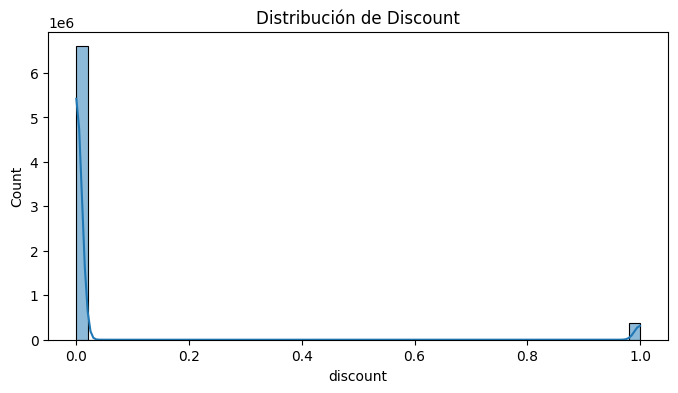

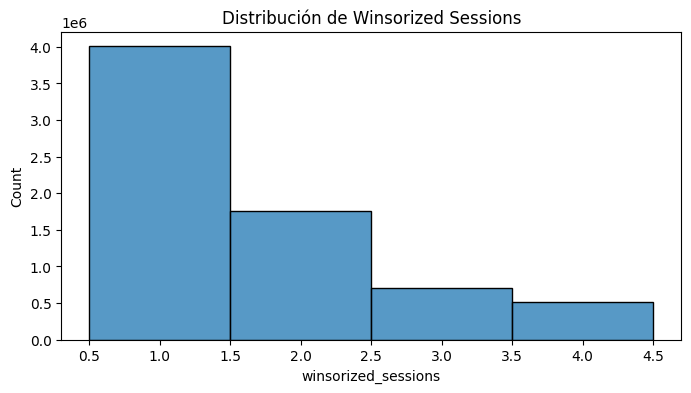

add_to_cart            1.000000
cod_section            0.048354
device_type            0.047851
M                      0.032167
family                 0.025730
F                      0.013974
discount               0.012630
country_x              0.003478
low_interaction        0.002295
country_y              0.001812
color_id               0.000488
user_id                0.000296
session_id            -0.000015
partnumber            -0.000935
hour                  -0.004296
winsorized_sessions   -0.005699
R                     -0.010907
Name: add_to_cart, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 1️⃣ Eliminar columnas irrelevantes
train = train.drop(columns=["is_anonymous", "is_new_user"], errors="ignore")

# 📊 2️⃣ Visualizar distribución de `discount`
plt.figure(figsize=(8, 4))
sns.histplot(train["discount"], bins=50, kde=True)
plt.title("Distribución de Discount")
plt.show()

# 📊 3️⃣ Visualizar distribución de `winsorized_sessions`
plt.figure(figsize=(8, 4))
sns.histplot(train["winsorized_sessions"], bins=10, discrete=True)
plt.title("Distribución de Winsorized Sessions")
plt.show()

# 🛠 4️⃣ Convertir columnas no numéricas a numéricas antes de calcular correlaciones
train_numeric = train.select_dtypes(include=[np.number])

# 📊 5️⃣ Revisión de correlaciones con `add_to_cart`
correlations = train_numeric.corr()["add_to_cart"].sort_values(ascending=False)
print(correlations)


In [1]:
import pandas as pd
import numpy as np

# 📂 Cargar dataset
train_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final.parquet"
train = pd.read_parquet(train_path)

# ✂️ Eliminar columnas irrelevantes
drop_cols = ["is_anonymous", "is_new_user", "session_id", "partnumber"]
train = train.drop(columns=[col for col in drop_cols if col in train.columns])

# ✅ Verificar si 'discount' existe antes de crear 'has_discount'
if "discount" in train.columns:
    train["has_discount"] = (train["discount"] > 0).astype(int)
    train = train.drop(columns=["discount"])  # Eliminar 'discount' después de binarizar

# 🏷 Convertir `winsorized_sessions` en categórica numérica
if "winsorized_sessions" in train.columns:
    train["winsorized_sessions"] = train["winsorized_sessions"].astype("category").cat.codes

# 📊 Expansión de `embedding_reduced`
if "embedding_reduced" in train.columns:
    embedding_dim = len(train["embedding_reduced"].iloc[0])  # Detecta la dimensión
    embedding_cols = [f"embedding_{i}" for i in range(embedding_dim)]
    embedding_df = pd.DataFrame(train["embedding_reduced"].tolist(), columns=embedding_cols)
    train = pd.concat([train.drop(columns=["embedding_reduced"]), embedding_df], axis=1)

# 🏷 Convertir variables categóricas a índices
cat_features = ["country_x", "country_y", "device_type", "cod_section", "family", "color_id"]
for col in cat_features:
    if col in train.columns:
        train[col] = train[col].astype("category").cat.codes

# 🏷 Normalizar `R`, `F`, `M`
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in ["R", "F", "M"]:
    if col in train.columns:
        train[[col]] = scaler.fit_transform(train[[col]])

# 📊 Verificar cambios
print(train.head())


          timestamp_local  add_to_cart  user_id  country_x  device_type  \
0 2024-06-04 08:21:13.476            0   480729          0            0   
1 2024-06-04 08:21:09.139            0   480729          0            0   
2 2024-06-04 08:21:11.955            0   480729          0            0   
3 2024-06-09 12:27:26.632            0   389707          0            0   
4 2024-06-01 09:25:20.260            0   350824          0            0   

   low_interaction  winsorized_sessions  hour  color_id  cod_section  ...  \
0                1                    0     8        72            0  ...   
1                1                    0     8        72            0  ...   
2                1                    0     8        71            0  ...   
3                1                    1    12       323            0  ...   
4                1                    1     9        54            2  ...   

   embedding_40  embedding_41  embedding_42  embedding_43  embedding_44  \
0      0.35

In [2]:
# 🔍 Verificar que no hay valores NaN
print(train.isna().sum())

# 📊 Resumen estadístico de las columnas numéricas
print(train.describe())

# 📊 Verificar distribución de clases en `add_to_cart`
print(train["add_to_cart"].value_counts(normalize=True))

# 🔹 Revisar si `has_discount` existe y está bien binarizado
if "has_discount" in train.columns:
    print(train["has_discount"].value_counts())
else:
    print("⚠️ Warning: 'has_discount' no está en el dataset.")

# 🔹 Verificar el rango de `R`, `F`, `M`
print(train[["R", "F", "M"]].describe())


timestamp_local    0
add_to_cart        0
user_id            0
country_x          0
device_type        0
                  ..
embedding_45       0
embedding_46       0
embedding_47       0
embedding_48       0
embedding_49       0
Length: 66, dtype: int64
                     timestamp_local   add_to_cart       user_id  \
count                        6978928  6.978928e+06  6.978928e+06   
mean   2024-06-07 21:42:11.548803840  7.038846e-02  2.782872e+05   
min       2024-06-01 02:00:00.056000  0.000000e+00  1.000000e+00   
25%    2024-06-04 08:49:25.266500096  0.000000e+00  1.380020e+05   
50%    2024-06-07 19:34:25.972999936  0.000000e+00  2.780940e+05   
75%    2024-06-11 06:21:05.634749952  0.000000e+00  4.177790e+05   
max       2024-06-15 03:45:33.530000  1.000000e+00  5.570060e+05   
std                              NaN  2.558006e-01  1.610820e+05   

          country_x   device_type  low_interaction  winsorized_sessions  \
count  6.978928e+06  6.978928e+06     6.978928e+06      

In [3]:
# 📂 Guardar dataset preprocesado
processed_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final_processed.parquet"
train.to_parquet(processed_path, index=False)

print(f"✅ Dataset preprocesado guardado en: {processed_path}")


✅ Dataset preprocesado guardado en: /home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/train_final_processed.parquet


## Test

In [ ]:
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"

test = pd.read_parquet(test_path)
print(test.info())
print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29591 entries, 0 to 29590
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   session_id           29591 non-null  int32         
 1   timestamp_local      29591 non-null  datetime64[ns]
 2   user_id              29591 non-null  int32         
 3   country_x            29591 non-null  int8          
 4   partnumber           29591 non-null  int32         
 5   device_type          29591 non-null  int8          
 6   winsorized_sessions  29591 non-null  int64         
 7   hour                 29591 non-null  int32         
 8   is_anonymous         29591 non-null  int64         
 9   low_interaction      29591 non-null  int64         
 10  discount             29591 non-null  int8          
 11  color_id             29591 non-null  int32         
 12  cod_section          29591 non-null  int8          
 13  family               29591 non-

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 📂 Cargar dataset de prueba
test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final.parquet"
test = pd.read_parquet(test_path)

# 🏷 Binarizar `has_discount` a partir de `discount`
test["has_discount"] = (test["discount"] > 0).astype(int)  # ✅ Corrección aquí

# ✂️ Eliminar columnas irrelevantes para que coincida con `train_final_processed`
drop_cols = ["is_anonymous", "is_new_user", "session_id", "partnumber", "discount"]
test = test.drop(columns=drop_cols)


# 🏷 Convertir `winsorized_sessions` en categórica numérica
test["winsorized_sessions"] = test["winsorized_sessions"].astype("category").cat.codes

# 📊 Expansión de `embedding_reduced`
embedding_dim = len(test["embedding_reduced"].iloc[0])  # Detecta la dimensión
embedding_cols = [f"embedding_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(test["embedding_reduced"].tolist(), columns=embedding_cols)

# 🔄 Concatenar con el dataset original sin `embedding_reduced`
test = pd.concat([test.drop(columns=["embedding_reduced"]), embedding_df], axis=1)

# 🏷 Convertir variables categóricas a índices
cat_features = ["country_x", "country_y", "device_type", "cod_section", "family", "color_id"]
for col in cat_features:
    test[col] = test[col].astype("category").cat.codes

# 🏷 Normalizar `R`, `F`, `M` con los mismos parámetros que `train`
scaler = MinMaxScaler()
test[["R", "F", "M"]] = scaler.fit_transform(test[["R", "F", "M"]])



In [12]:
test.columns

Index(['timestamp_local', 'user_id', 'country_x', 'device_type',
       'winsorized_sessions', 'hour', 'low_interaction', 'color_id',
       'cod_section', 'family', 'country_y', 'R', 'F', 'M', 'has_discount',
       'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3',
       'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7',
       'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11',
       'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15',
       'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19',
       'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23',
       'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27',
       'embedding_28', 'embedding_29', 'embedding_30', 'embedding_31',
       'embedding_32', 'embedding_33', 'embedding_34', 'embedding_35',
       'embedding_36', 'embedding_37', 'embedding_38', 'embedding_39',
       'embedding_40', 'embedding_41', 'embedding_42', 'embedding_43',
       'embedding_4

In [10]:
test.head()

,timestamp_local,user_id,country_x,device_type,winsorized_sessions,hour,low_interaction,color_id,cod_section,family,...,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49
0,2024-06-15 18:36:47.390,-1,3,0,2,18,0,300,0,20,...,-0.314889,-0.415484,0.391583,0.584044,0.016513,-0.380344,0.003756,0.142551,0.470092,0.215462
1,2024-06-15 18:37:04.052,-1,3,0,2,18,0,163,0,102,...,-0.674646,-0.887718,0.017524,1.342808,-0.136059,-0.455638,1.041524,-0.524855,-0.262293,0.109344
2,2024-06-15 18:37:48.159,-1,3,0,2,18,0,60,0,37,...,0.173137,0.712604,-1.058112,0.550571,1.304830,0.699970,0.712640,0.256112,-0.340270,-0.122088
3,2024-06-15 18:38:19.899,-1,3,0,2,18,0,37,0,19,...,-0.659891,1.157834,0.654013,1.061690,-0.963456,0.934282,-0.838286,-0.736203,0.177847,-0.207290
4,2024-06-15 18:38:46.492,-1,3,0,2,18,0,137,0,35,...,-0.699615,0.642724,-0.163838,-0.486933,0.058465,-0.745485,-0.000806,-0.131937,0.233854,1.046505


In [11]:
test.describe()

,timestamp_local,user_id,country_x,device_type,winsorized_sessions,hour,low_interaction,color_id,cod_section,family,...,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49
count,29591,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,...,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000,29591.000000
mean,2024-06-16 01:09:49.993582848,54697.367105,1.408604,0.213038,1.591666,12.501504,0.067183,132.359772,0.599236,64.823392,...,-0.066279,0.039116,-0.054194,0.032442,-0.009966,-0.048395,0.010923,-0.046256,-0.011140,0.033203
min,2024-06-15 00:00:35.309000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.888691,-2.609756,-2.734598,-3.097658,-2.408901,-2.404644,-2.707654,-2.323177,-2.027562,-2.477818
25%,2024-06-15 13:50:26.757999872,-1.000000,0.000000,0.000000,2.000000,7.000000,0.000000,46.000000,0.000000,35.000000,...,-0.470922,-0.368367,-0.483853,-0.351796,-0.414615,-0.444777,-0.374277,-0.422012,-0.352225,-0.368382
50%,2024-06-16 00:17:29.008000,-1.000000,2.000000,0.000000,2.000000,13.000000,0.000000,101.000000,0.000000,50.000000,...,-0.053159,0.017379,-0.067392,0.020122,0.012749,-0.065769,0.003086,-0.057137,0.000004,0.028552
75%,2024-06-16 14:10:49.025499904,-1.000000,2.000000,0.000000,2.000000,18.000000,0.000000,228.000000,2.000000,109.000000,...,0.349064,0.422163,0.357606,0.406201,0.397568,0.325508,0.395000,0.318012,0.323064,0.418736
max,2024-06-16 23:55:50.519000,555819.000000,3.000000,2.000000,2.000000,23.000000,1.000000,401.000000,3.000000,150.000000,...,2.722427,3.755591,2.922398,2.783109,2.510584,2.363479,2.483537,2.706986,2.862335,2.158052
std,NaN,129008.024277,1.064760,0.603723,0.804497,6.656304,0.250342,109.757170,0.989064,39.920270,...,0.652774,0.649892,0.684740,0.610542,0.618129,0.599961,0.586486,0.584547,0.546150,0.583968


In [ ]:
# 📂 Guardar dataset preprocesado
processed_test_path = "/home/pablost/Hackathon_inditex_data_science/hackathon-inditex-data-recommender/data/processed/final/test_final_processed.parquet"
test.to_parquet(processed_test_path, index=False)

print(f"✅ Dataset de prueba preprocesado guardado en: {processed_test_path}")